# Data Analysis

## Table of Contents
- Load Data
- Sample Description
    - Loan Related
    - User Related
- RFM Analysis
    - Scores Definitions
    - Segment Definitions
- Segment Purchasing Behavior
- Segment Repayment Behavior
- Segment Loan Suitability

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd

# visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# plotly config
import plotly.io as pio
pio.renderers.default = "browser"

template = "plotly_white"
colors = {
    "red": "rgb(255,0,0)",
    "dark_blue": "rgb(30,144,255)",
    "medium_blue": "rgb(0,191,255)",
    "light_blue": "rgb(135,206,250)",
    "dark_purple": "rgb(202, 105, 157)",
    "medium_purple": "rgb(221, 136, 172)",
    "light_purple": "rgb(234, 169, 189)",
    "dark_gray": "rgb(169,169,169)",
    "medium_gray": "rgb(192,192,192)",
    "light_gray": "rgb(211,211,211)"
}
title_font_size = 22
font_size = 18

# Load Data

In [3]:
# analysis based on the training set loans and statistics
df_loans = pd.read_pickle("../data/interim/df_loans_train_raw.pkl")

df_loans

id  user_id  amount  total_amount  due_amount   due_date  \
0       86        1  6000.0       6045.28     6459.00 2022-05-03   
2     1744        3  6000.0       6045.28     6458.80 2022-07-18   
5     6428        4  6000.0       6045.28     7749.16 2022-12-18   
6     2222        5  6000.0       6045.28     6458.80 2022-07-21   
7     3380        5  6000.0       6045.28     6458.80 2022-08-25   
...    ...      ...     ...           ...         ...        ...   
6583  1186     3153  6000.0       6045.28     6458.80 2022-06-13   
6584  3111     3153  6000.0       6045.28     6458.80 2022-08-02   
6585  3856     3153  6000.0       6045.28     6458.78 2022-09-13   
6586  4358     3153  6000.0       6045.28     6458.80 2022-10-02   
6587  5568     3153  6000.0       6045.28     7749.16 2022-11-18   

               status created_at status_cleaned  loan_term  ... status_paid  \
0     debt_collection 2022-02-02           debt         90  ...           1   
2              repaid 2022-04-18         repaid         91  ...          18   
5              repaid 2022-09-19         repaid         90  ...          25   
6              repaid 2022-04-22         repaid         90  ...          28   
7              repaid 2022-05-27         repaid         90  ...          50   
...               ...        ...            ...        ...  ...         ...   
6583           repaid 2022-03-15         repaid         90  ...          28   
6584           repaid 2022-05-04         repaid         90  ...          13   
6585           repaid 2022-06-15         repaid         90  ...          13   
6586           repaid 2022-07-04         repaid         90  ...          17   
6587           repaid 2022-08-20         repaid         90  ...          24   

     rate_default median_repayment_amount num_repayments  ratio_repaid_total  \
0        0.000000                   39.00              1            0.006451   
2        0.052632                  270.00             19            1.037472   
5        0.074074                  169.50             27            1.068647   
6        0.000000                  129.58             28            1.011629   
7        0.019608                  115.06             51            1.023666   
...           ...                     ...            ...                 ...   
6583     0.034483                  101.25             29            1.017945   
6584     0.071429                  466.50             14            1.008317   
6585     0.000000                  207.00             13            1.010607   
6586     0.055556                   78.00             18            1.018403   
6587     0.000000                  195.00             24            1.089040   

     max_repayment_delay  due_date_exceeded num_late_repayment  \
0                      0                  0                  0   
2                      0                  0                  0   
5                      0                  0                  0   
6                      0                  0                  0   
7                      0                  0                  0   
...                  ...                ...                ...   
6583                 220                  1                  1   
6584                   0                  0                  0   
6585                   0                  0                  0   
6586                   0                  0                  0   
6587                   0                  0                  0   

      median_days_lag_repayment  loan_quality  
0                           1.0      bad_loan  
2                           3.0     good_loan  
5                           1.0      bad_loan  
6                           1.0     good_loan  
7                           1.0     good_loan  
...                         ...           ...  
6583                        1.0     good_loan  
6584                        1.0      bad_loan  
6585                        1.0     good_loan  
6586    

In [4]:
loan_ids = set(df_loans["id"].unique())

df_loan_repayments = pd.read_pickle("../data/processed/df_loan_repayments.pkl")
df_loan_repayments = df_loan_repayments[df_loan_repayments["loan_id"].isin(loan_ids)]

df_loan_repayments

id  loan_id       type   amount     status created_at  \
0            1        2  autopilot   269.70       paid 2022-02-01   
1            2        4  autopilot  2550.00       paid 2022-02-01   
2            3       53        pix  1500.00  defaulted 2022-02-01   
3            4       22  autopilot   630.00       paid 2022-02-02   
4            5       70  autopilot   120.00       paid 2022-02-02   
...        ...      ...        ...      ...        ...        ...   
172440  172441     4524        pix   362.75  defaulted 2023-03-21   
172441  172442     4524        pix   362.75   refunded 2023-03-22   
172442  172443     4524  autopilot   239.12   refunded 2023-03-22   
172443  172444     4524        pix   362.75  defaulted 2023-03-22   
172444  172445      785  autopilot    80.00   refunded 2023-06-17   

       status_cleaned  
0                paid  
1                paid  
2           defaulted  
3                paid  
4                paid  
...               ...  
172440      defaulted  
172441           paid  
172442           paid  
172443      defaulted  
172444           paid  

[138296 rows x 7 columns]

In [5]:
df_users = pd.read_pickle("../data/processed/df_users.pkl")

df_users["rate_transactions_installment"] = df_users["rate_transactions_installment"].astype(float)

df_users

user_id  recency  frequency   monetary  median_intallments  \
0           1      346         10   25154.18                 2.0   
1           2      340         35   66491.00                10.0   
2           3      191         78  117555.00                 5.0   
3           4       15        286  423169.31                 1.0   
4           5       54        793  440568.44                 1.0   
...       ...      ...        ...        ...                 ...   
3038     3149      216        231   96516.80                 1.0   
3039     3150        8        849  395379.93                 1.0   
3040     3151      140        227   73475.80                 2.0   
3041     3152       39       1118  359051.73                 3.0   
3042     3153       61        434  483916.07                 4.0   

      median_lag_transaction  rate_denied  rate_transactions_installment  \
0                        5.0     0.300000                       0.700000   
1                        1.0     0.057143                       0.971429   
2                        1.0     0.115385                       1.000000   
3                        0.0     0.090909                       0.419580   
4                        0.0     0.083228                       0.480454   
...                      ...          ...                            ...   
3038                     0.0     0.069264                       0.333333   
3039                     0.0     0.174323                       0.398115   
3040                     0.0     0.092511                       0.568282   
3041                     0.0     0.135063                       0.952594   
3042                     0.0     0.278802                       0.647465   

      rate_credit_debit  ratio_online_person   card_preference  rate_default  \
0              5.000000             0.090909  card_internation      0.000000   
1             17.500000             0.027778       card_brazil           NaN   
2             79.000000             0.025641  card_internation      0.052632   
3              1.666667             0.006993  card_internation      0.074074   
4            131.500000             0.001259  card_internation      0.012658   
...                 ...                  ...               ...           ...   
3038           2.065789             0.008658  card_internation      0.000000   
3039           2.590717             0.291351  card_internation      0.054795   
3040           2.271429             0.022321  card_internation      0.014493   
3041          61.222222             0.029412  card_internation      0.016949   
3042           3.791209             0.016317  card_internation      0.025424   

      median_repayment_amount  max_repayment_delay  median_days_lag_repayment  \
0                     39.0000                  0.0                        1.0   
1                         NaN                  NaN                        NaN   
2                    270.0000                  0.0                        3.0   
3                    169.5000                  0.0                        1.0   
4                    122.3200                  0.0                        1.0   
...                       ...                  ...                        ...   
3038                  40.8000                  8.0                        1.0   
3039                 217.1850                 10.0                        1.0   
3040                  87.5625                  1.0                        1.5   
3041                 110.5750                  0.0                        1.0   
3042                 171.0000                220.0                        1.0   

      num_loans  rate_due_date_exceeded  rate_late_repayment  \
0           1.0                0.000000             0.000000   
1           NaN                     NaN                  NaN   
2           1.0                0.000000             0.000000   
3           1.0                0.000000             0.000000   
4           2.0       

# Sample Description

- Loan Related
- User Related

In [6]:
df_loans["status"] = df_loans["status"].str.replace("_", " ")

In [7]:
df_loans["due_date_exceeded"] = df_loans["due_date_exceeded"].replace({0: "not exceeded", 1: "exceeded"})

In [8]:
df_loans["loan_quality"] = df_loans["loan_quality"].replace({"good_loan": "high", "bad_loan": "low"})

In [9]:
df_users["credit_debit_preference"] = np.where(df_users['rate_credit_debit'] <= 1, "debit", "credit")

In [10]:
df_users["median_intallments"] = df_users["median_intallments"].round()

In [11]:
df_users["online_person_preference"] = np.where(df_users["ratio_online_person"] <= 1, "in-person", "online")

In [12]:
df_users["has_defaulted"] = "hasn't defaulted"
df_users.loc[df_users["rate_default"] > 0, "has_defaulted"] = "has defaulted"

In [13]:
df_users["has_exceeded_due_date"] = "on time"
df_users.loc[df_users["rate_due_date_exceeded"] > 0, "has_exceeded_due_date"] = "overdue"

## Loan Debt

**Note:** 
- 23% of the loans have resulted in debt
- Loans that have resulted in debt, tend to be partially repaid up to 55%

In [14]:
fig = px.histogram(
    df_loans[df_loans["status"] != "error"],
    x="status",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>23% of the loans have resulted in debt</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="loan status",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

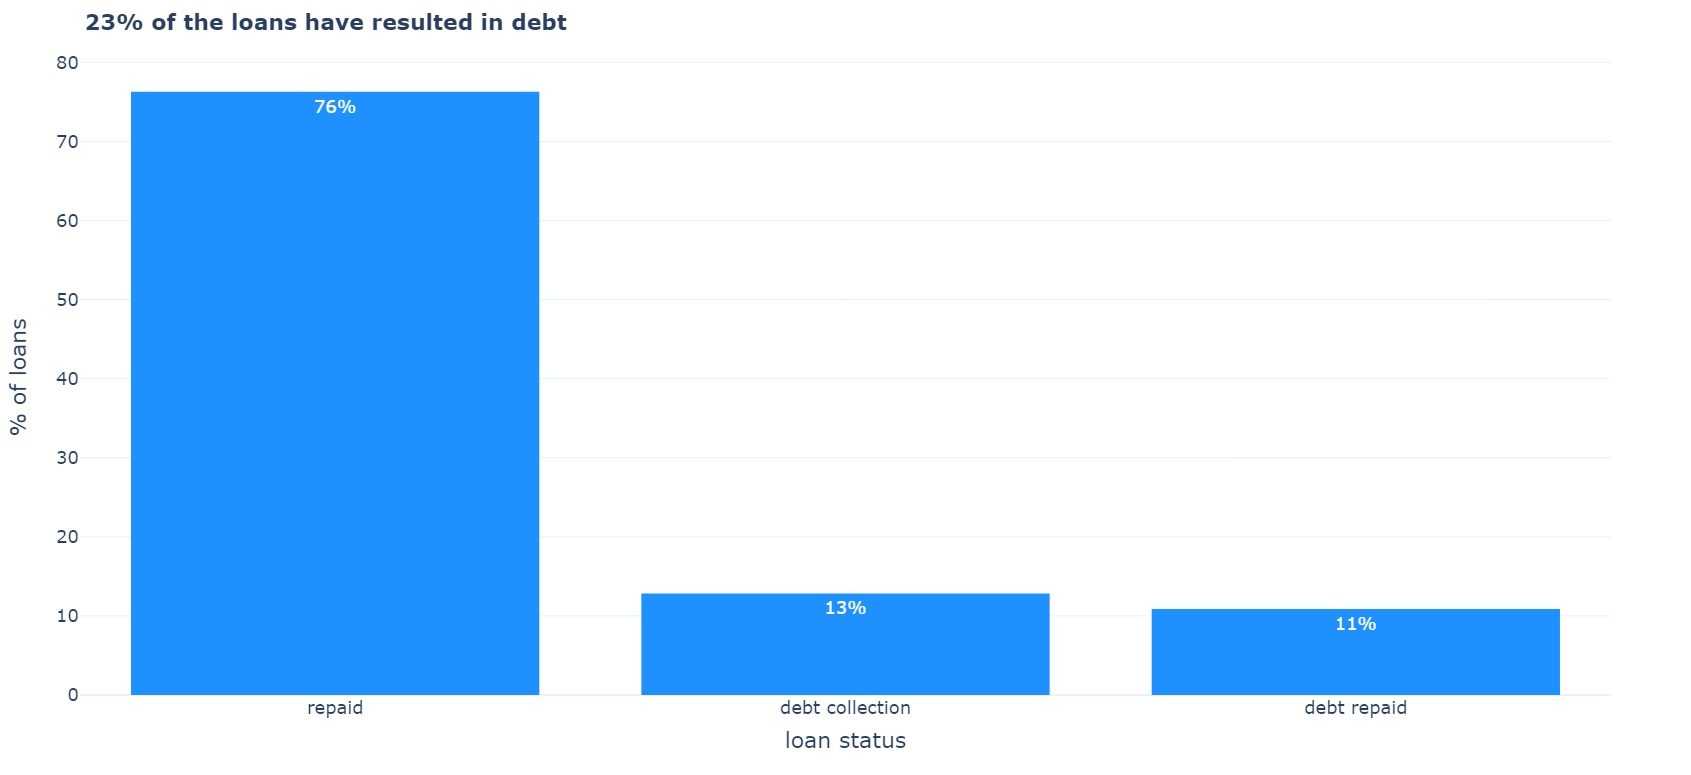

In [15]:
# repaid ratio distribution only for loans that resulted in debt
df_loans[df_loans["status_cleaned"] == "debt"]["ratio_repaid_total"].describe()

count    1195.000000
mean        0.355631
std         0.269146
min         0.000000
25%         0.117972
50%         0.315534
75%         0.554898
max         0.945293
Name: ratio_repaid_total, dtype: float64

## Loan Principal Amount

**Note:** Loans typically range from more than R$6k

In [16]:
fig = px.histogram(
    df_loans, 
    x='amount_bin', 
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title='<b>Loans typically range from more than R$6k</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="principal loan amount (R$)",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=["1k - 2k", "2k - 3k", "3k - 4k", "4k - 5k", "5k - 6k", "6k - 7k"]
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="outside"
)

fig.show()

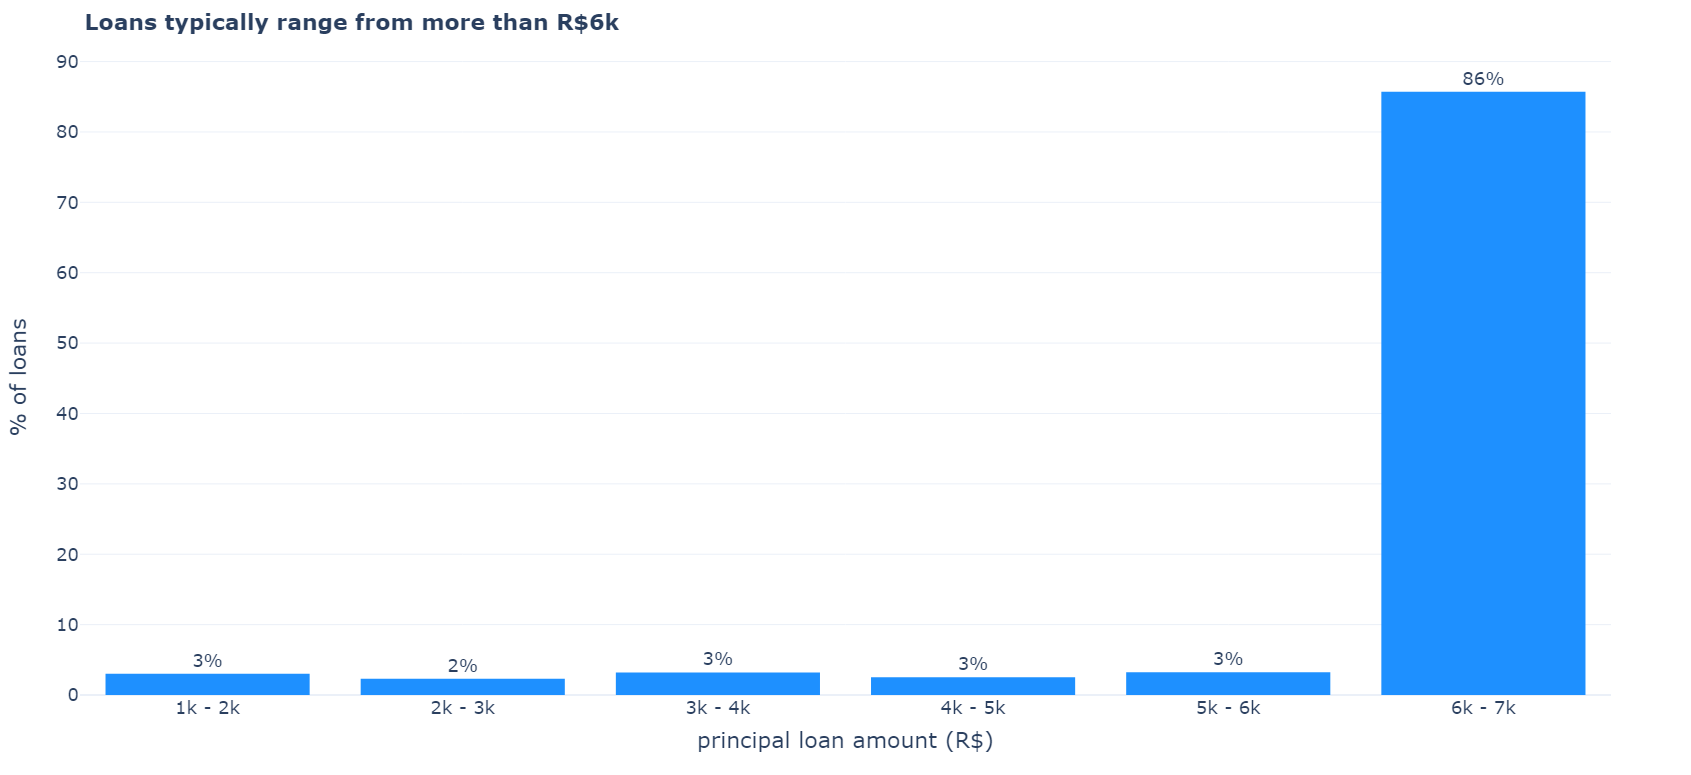

## Loan Fees

**Note:** Loan fees typically range from R$40-50

In [17]:
fig = px.histogram(
    df_loans, 
    x='loan_fees_bin', 
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title='<b>Loan fees typically range from R$40-50</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="loan fees (R$)",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=["0 - 10", "10 - 20", "20 - 30", "30 - 40", "40 - 50"]
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="outside"
)

fig.show()

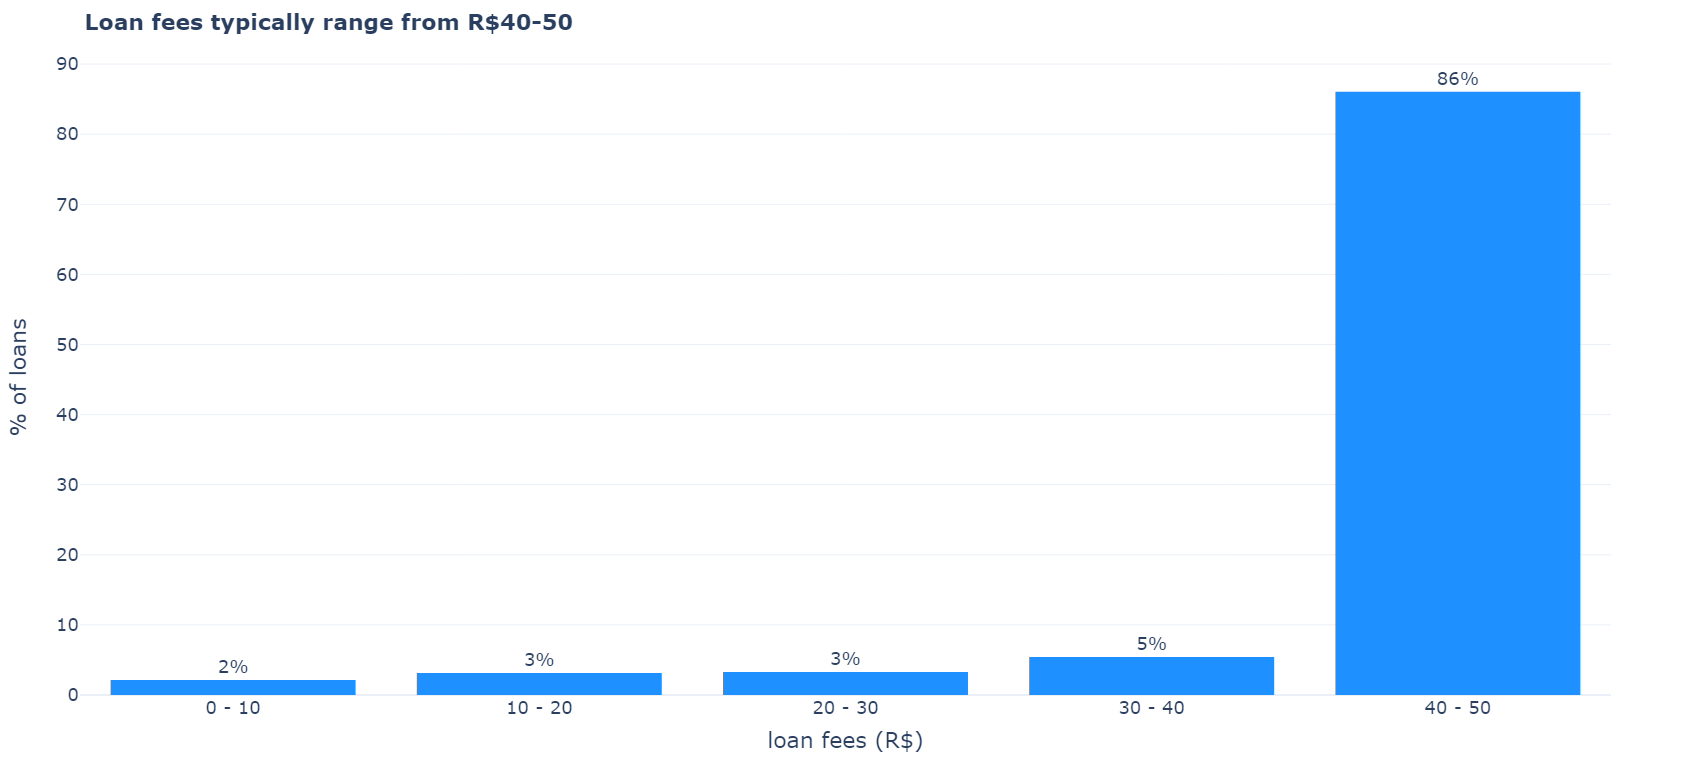

## Loan Due Amount

**Note:** Loans can range up to R$9k, if there are no repayments during the contract period

In [18]:
fig = px.histogram(
    df_loans, 
    x='due_amount_bin', 
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title='<b>Loans can range up to R$9k, if there are no repayments during the contract period</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="due loan amount (R$)",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=["1k - 2k", "2k - 3k", "3k - 4k", "4k - 5k", "5k - 6k", "6k - 7k", "7k - 8k", "8k - 9k"]
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="outside"
)

fig.show()

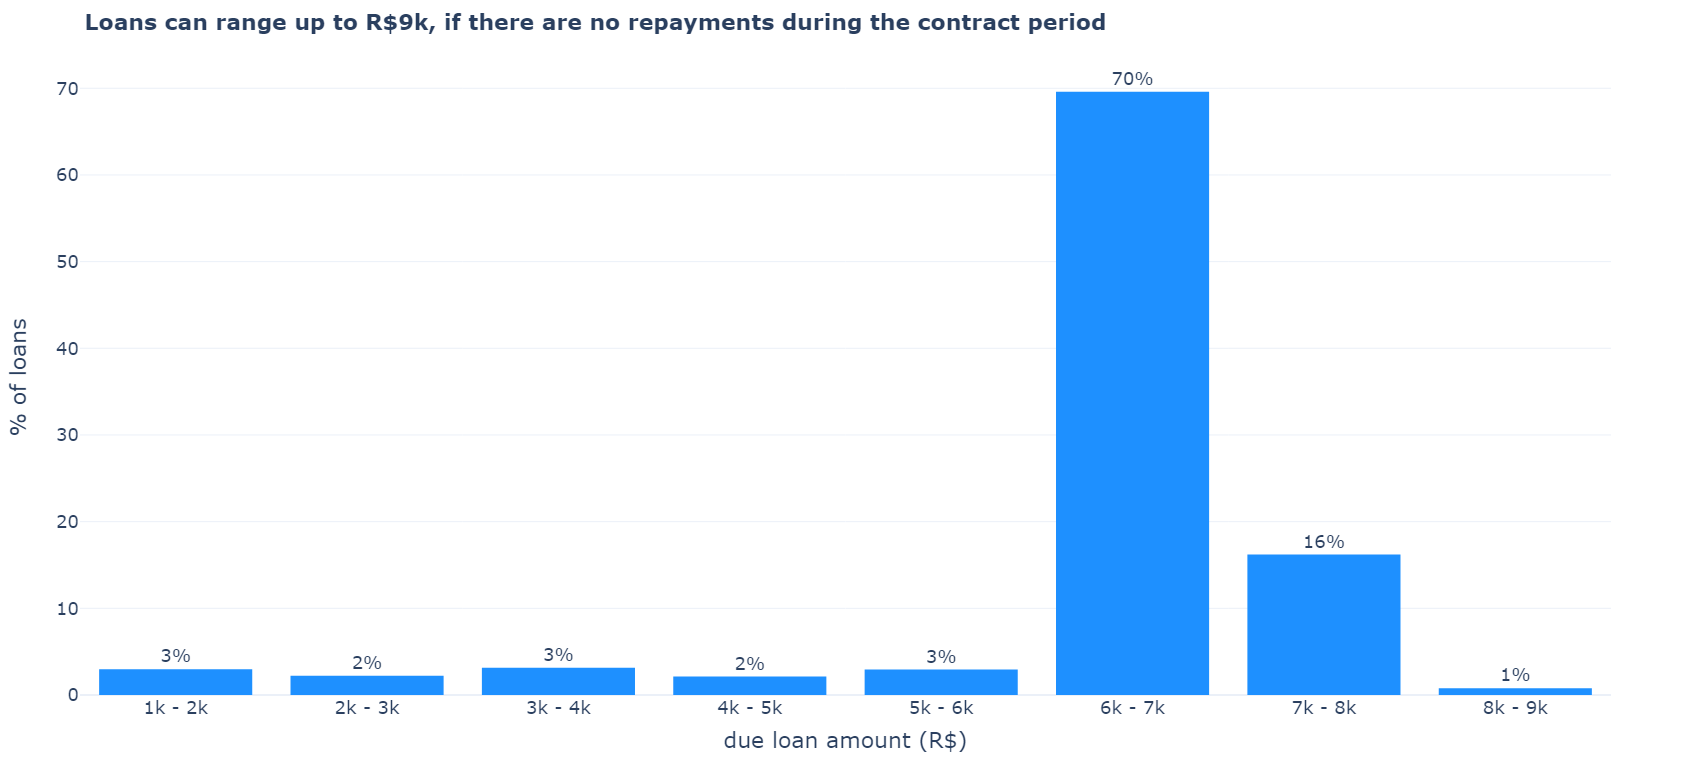

## Loan Interest Rate

**Note:** Only 18% of the loans have a high interest rate (exceeding 100%)

In [19]:
fig = px.histogram(
    df_loans, 
    x="interest_rate_bin", 
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title='<b>Only 18% of the loans have a high interest rate (exceeding 100%)</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="loan interest rate (%)",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=["small", "medium", "large"]
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="outside"
)

fig.show()

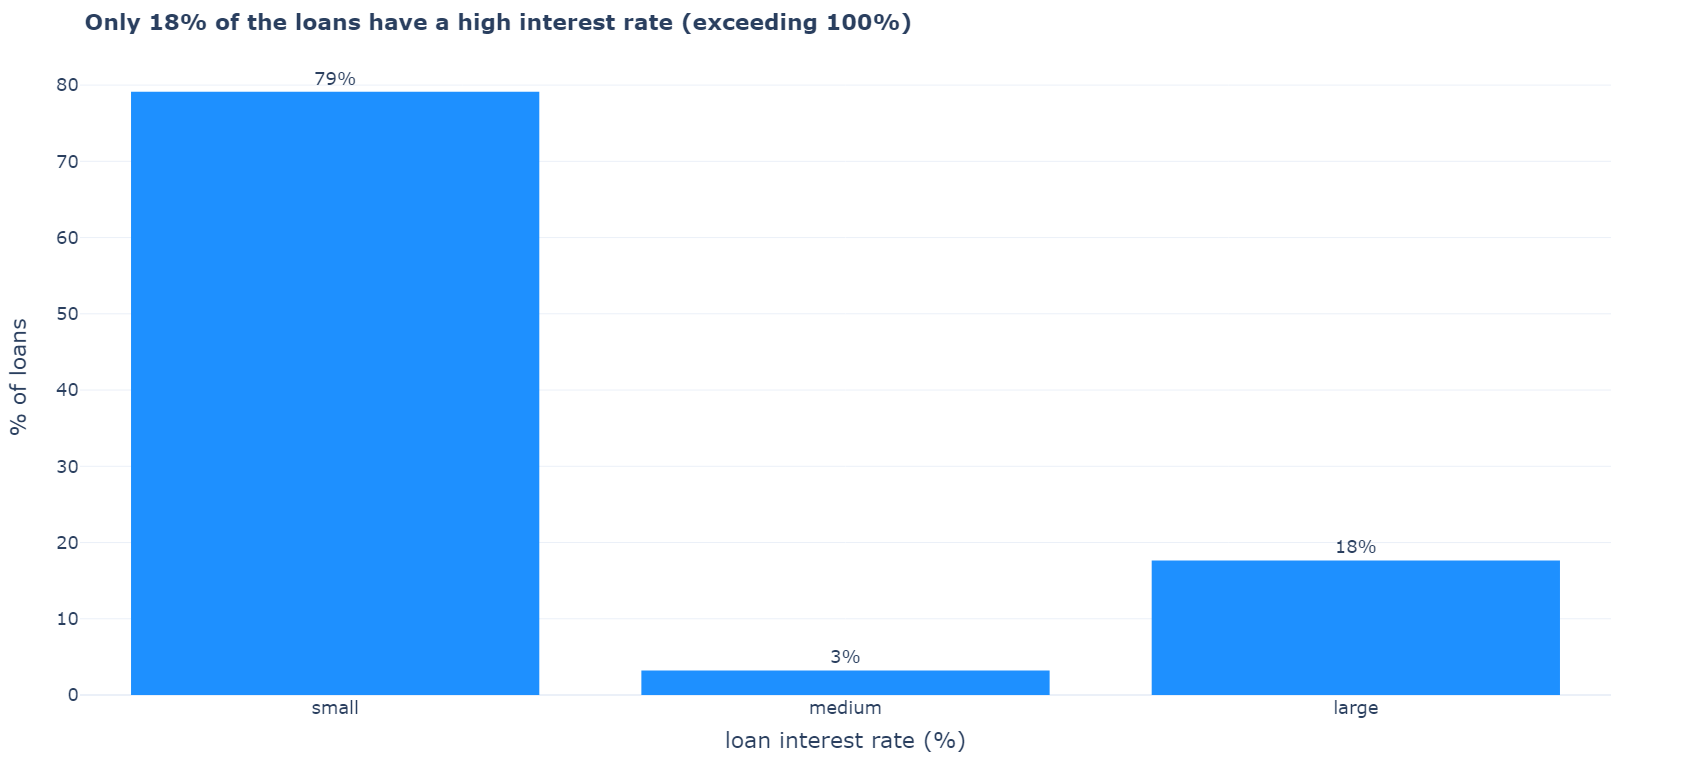

## Loan Term

**Note:** Loans typically need to be repaid in the next 3 months

In [20]:
df_loans['loan_term'].describe()

count    5270.000000
mean       90.058824
std         0.351707
min        90.000000
25%        90.000000
50%        90.000000
75%        90.000000
max        96.000000
Name: loan_term, dtype: float64

## Loan Repayment Default

**Note:** Only 5% of the loan repayments have gone to default

In [21]:
fig = px.histogram(
    df_loan_repayments,
    x="status_cleaned",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Only 5% of the loan repayments have gone to default</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="repayment status",
    yaxis_title="% of repayments",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

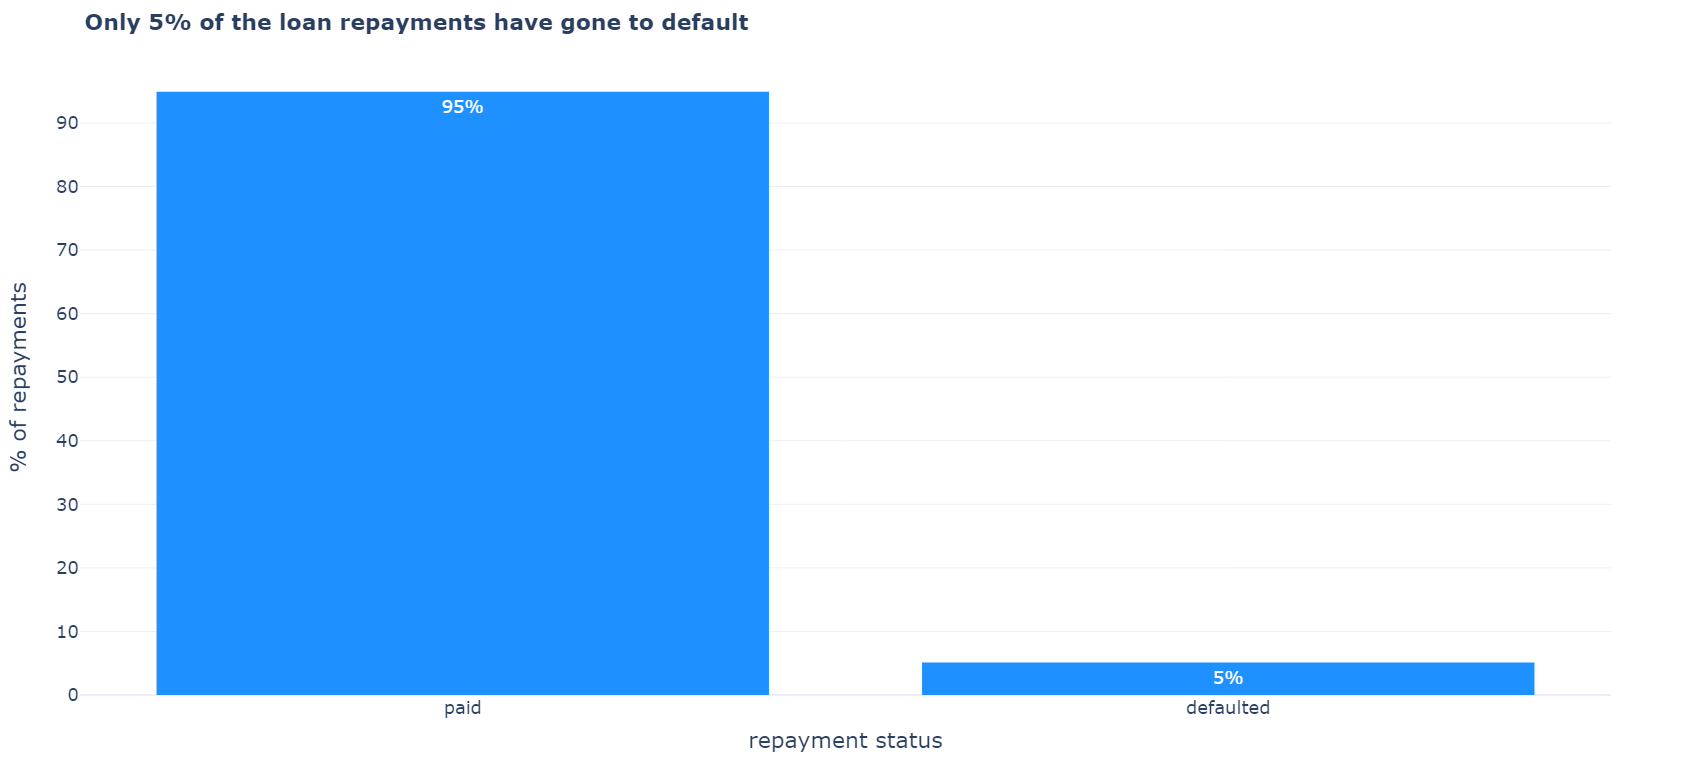

## Number of Loan Repayments

**Note:** Loans are typically repaid in 10-40 repayments

In [22]:
fig = px.histogram(
    df_loans,
    x="num_repayments",
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Loans are typically repaid in 10-40 repayments</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="number of repayments",
    yaxis_title="% of loans",
    template=template,
)

fig.show()

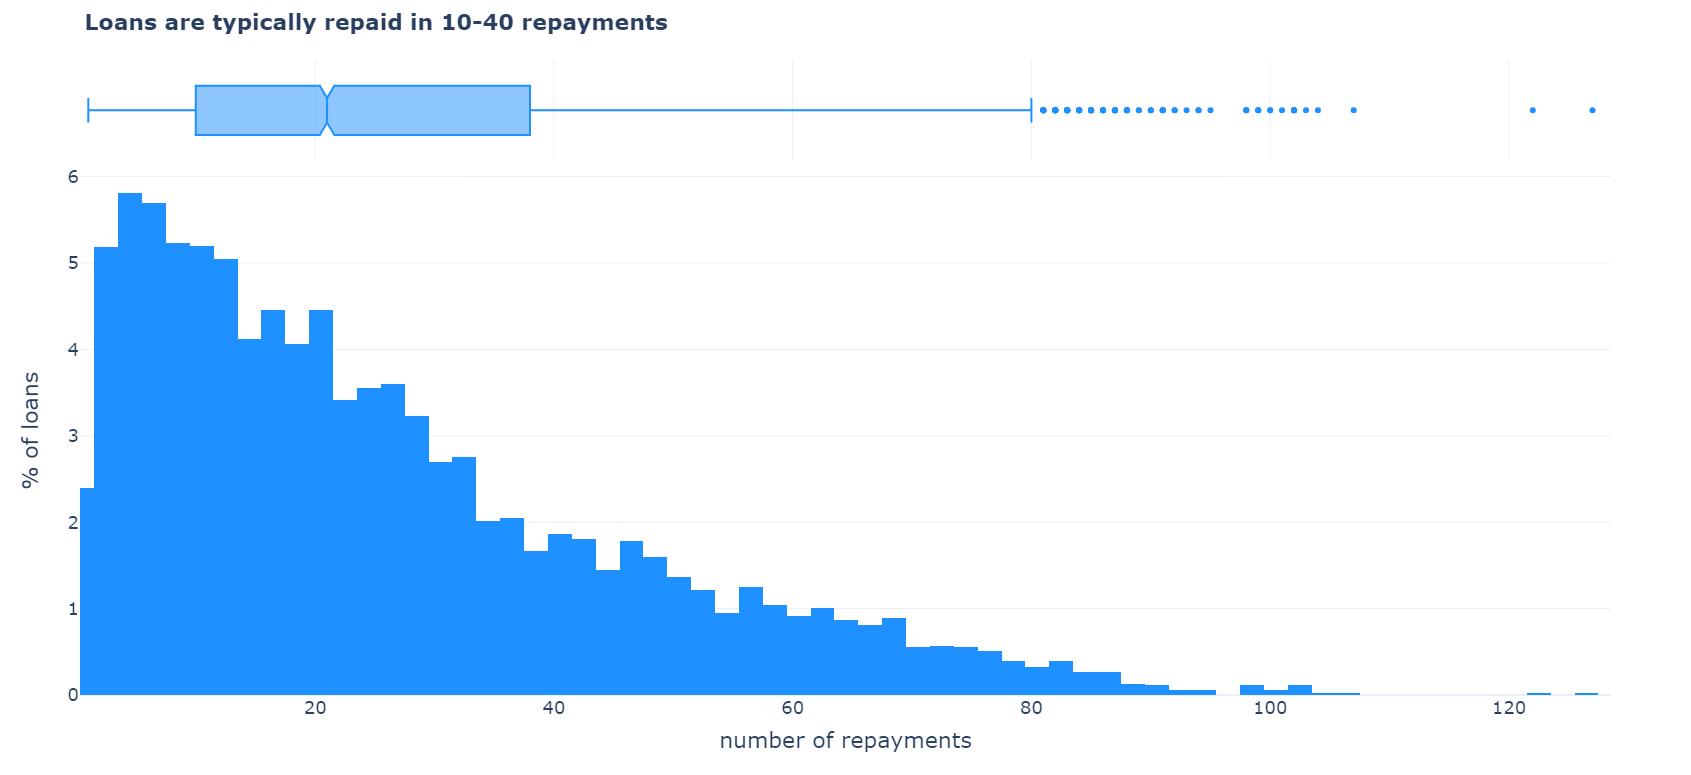

In [23]:
df_loans["num_repayments"].describe()

count    5270.000000
mean       26.242125
std        21.082838
min         1.000000
25%        10.000000
50%        21.000000
75%        38.000000
max       271.000000
Name: num_repayments, dtype: float64

## Loan Overdue

**Note:** 
- 81% of the loans have exceeded repayment due date
- On average, loans exceed due date by 2-6 repayments

In [24]:
fig = px.histogram(
    df_loans,
    x="due_date_exceeded",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>81% of the loans have exceeded repayment due date</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="due date exceeded",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

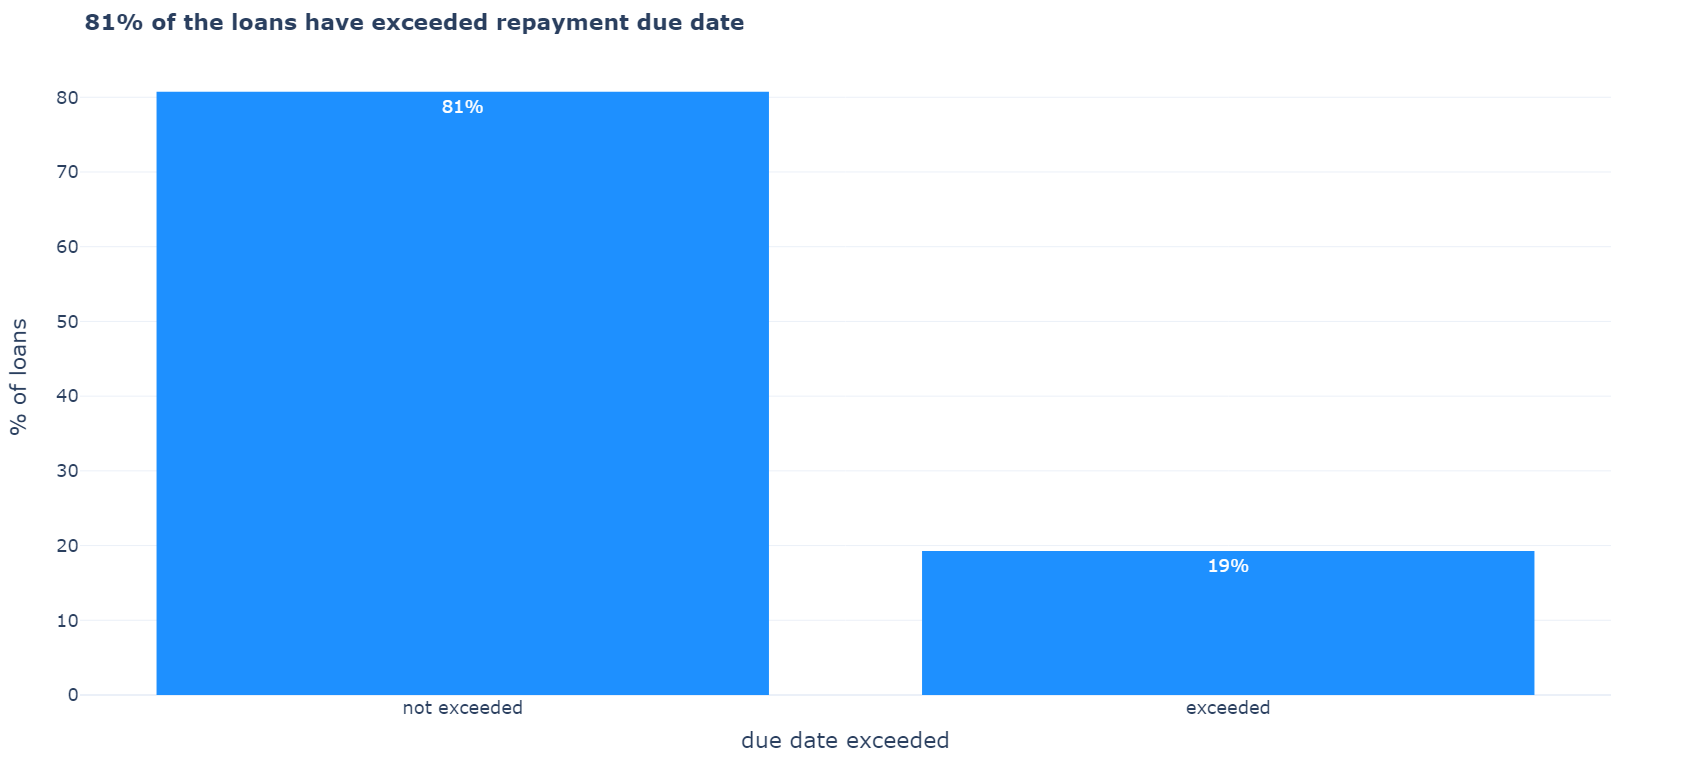

In [25]:
fig = px.histogram(
    df_loans[df_loans["due_date_exceeded"] == "exceeded"],
    x="num_late_repayment",
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>On average, loans exceed due date by 2-6 repayments</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="number of late repayments",
    yaxis_title="% of loans",
    template=template,
)

fig.show()

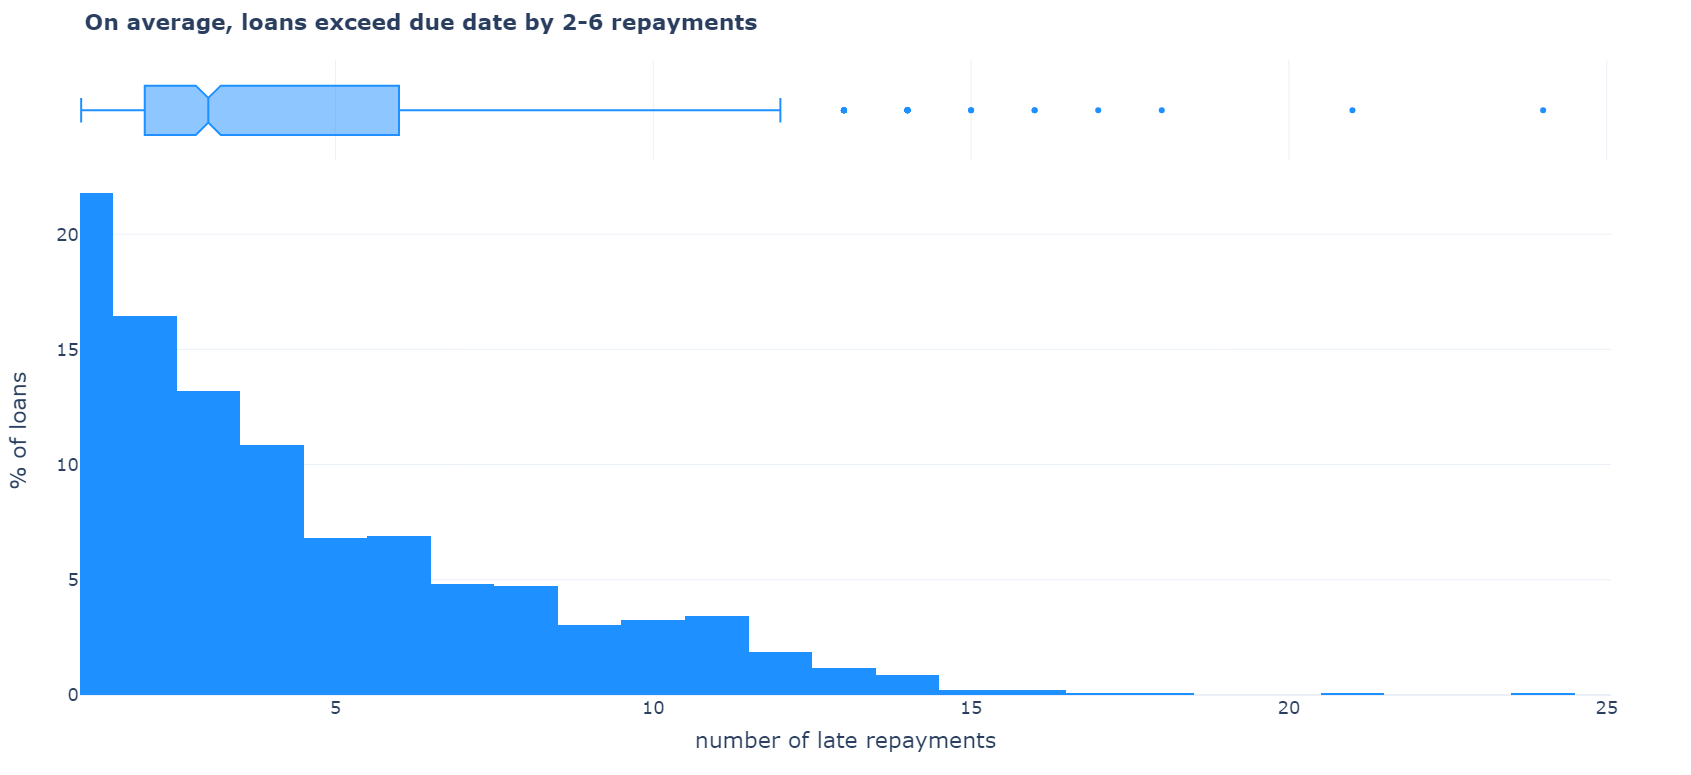

In [26]:
df_loans[df_loans["due_date_exceeded"] == "exceeded"]["num_late_repayment"].describe()

count    1015.00000
mean        4.46798
std         3.50777
min         1.00000
25%         2.00000
50%         3.00000
75%         6.00000
max        24.00000
Name: num_late_repayment, dtype: float64

## Loan Repayment Lag

**Note:** Repayments happen every 1-3 days

In [27]:
df_loans['median_days_lag_repayment'].describe()

count    5270.000000
mean        2.899620
std         7.023669
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       241.000000
Name: median_days_lag_repayment, dtype: float64

## Loan Quality

**Note:** 1/4 loans has led to repayment conditions that carry a degree of risk

In [28]:
fig = px.histogram(
    df_loans,
    x="loan_quality",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>43% of loans has led to repayment conditions that carry a degree of risk</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="loan quality",
    yaxis_title="% of loans",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

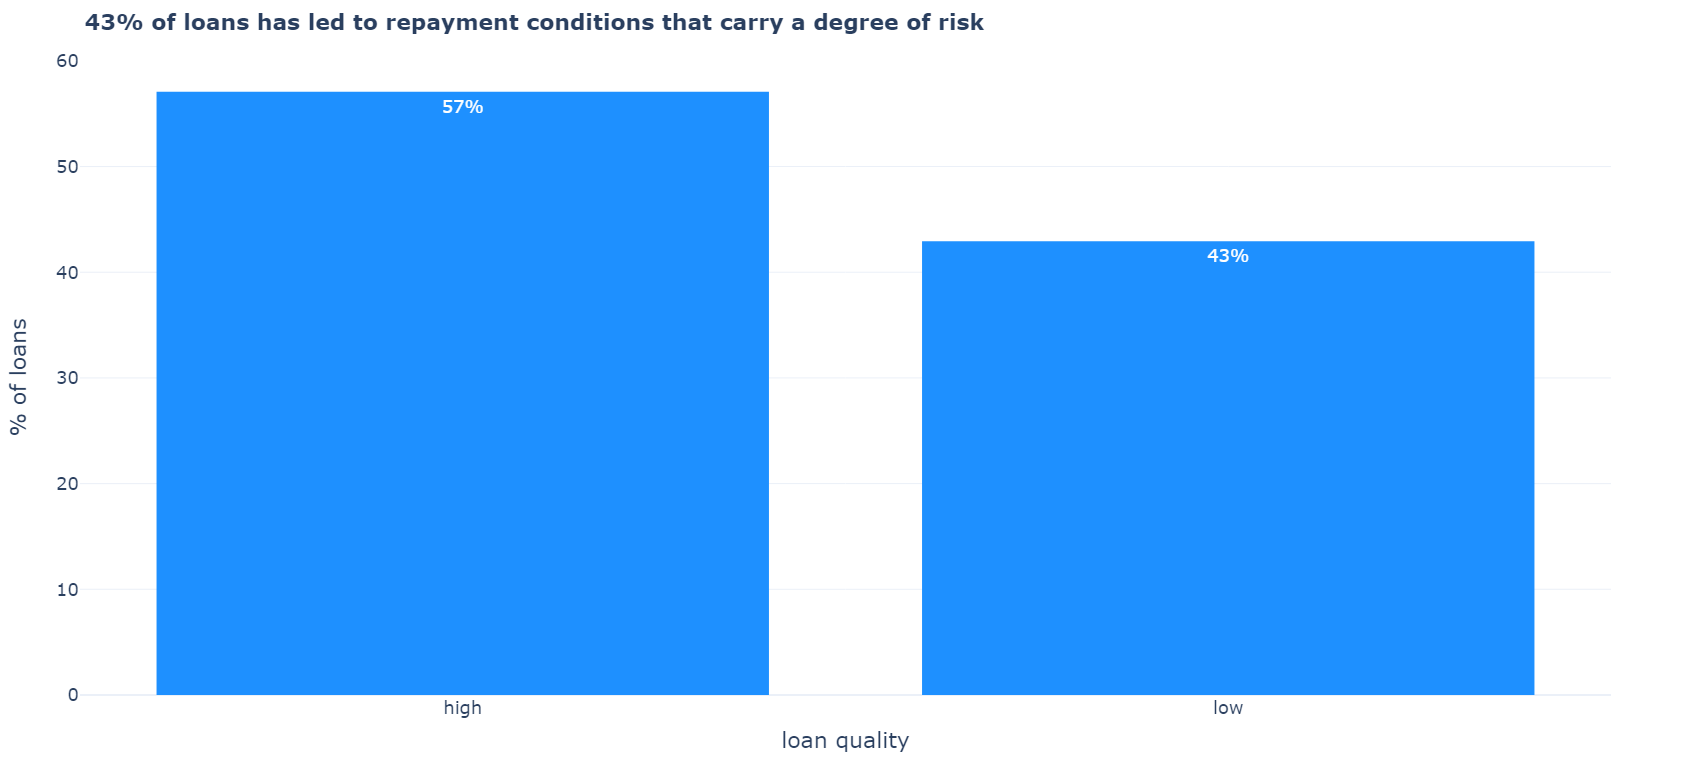

## Card Type Preference

**Note:** 82% of the users prefer to make purchases using a credit card

In [29]:
fig = px.histogram(
    df_users,
    x="credit_debit_preference",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>82% of the users prefer to make purchases using a credit card</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="card type preference",
    yaxis_title="% of users",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

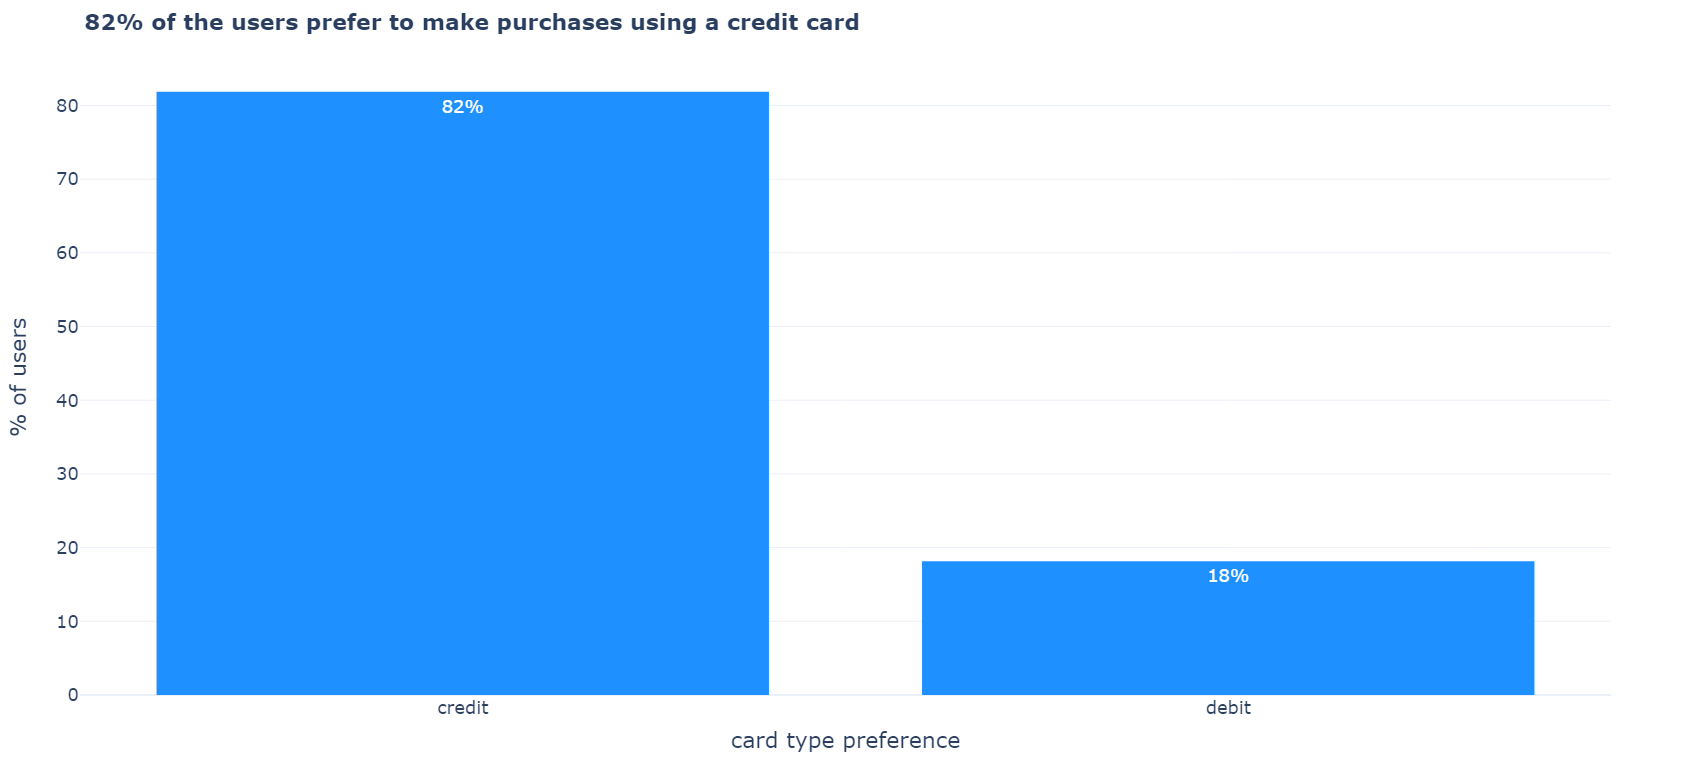

## Installment Preference

**Note:** Users typically finance 25% to 75% of their purchases through installment plans

In [30]:
fig = px.histogram(
    df_users,
    x="rate_transactions_installment",
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Users typically finance 25% to 75% of their purchases through installment plans</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="% of transactions with installments",
    yaxis_title="% of users",
    template=template,
)

fig.show()

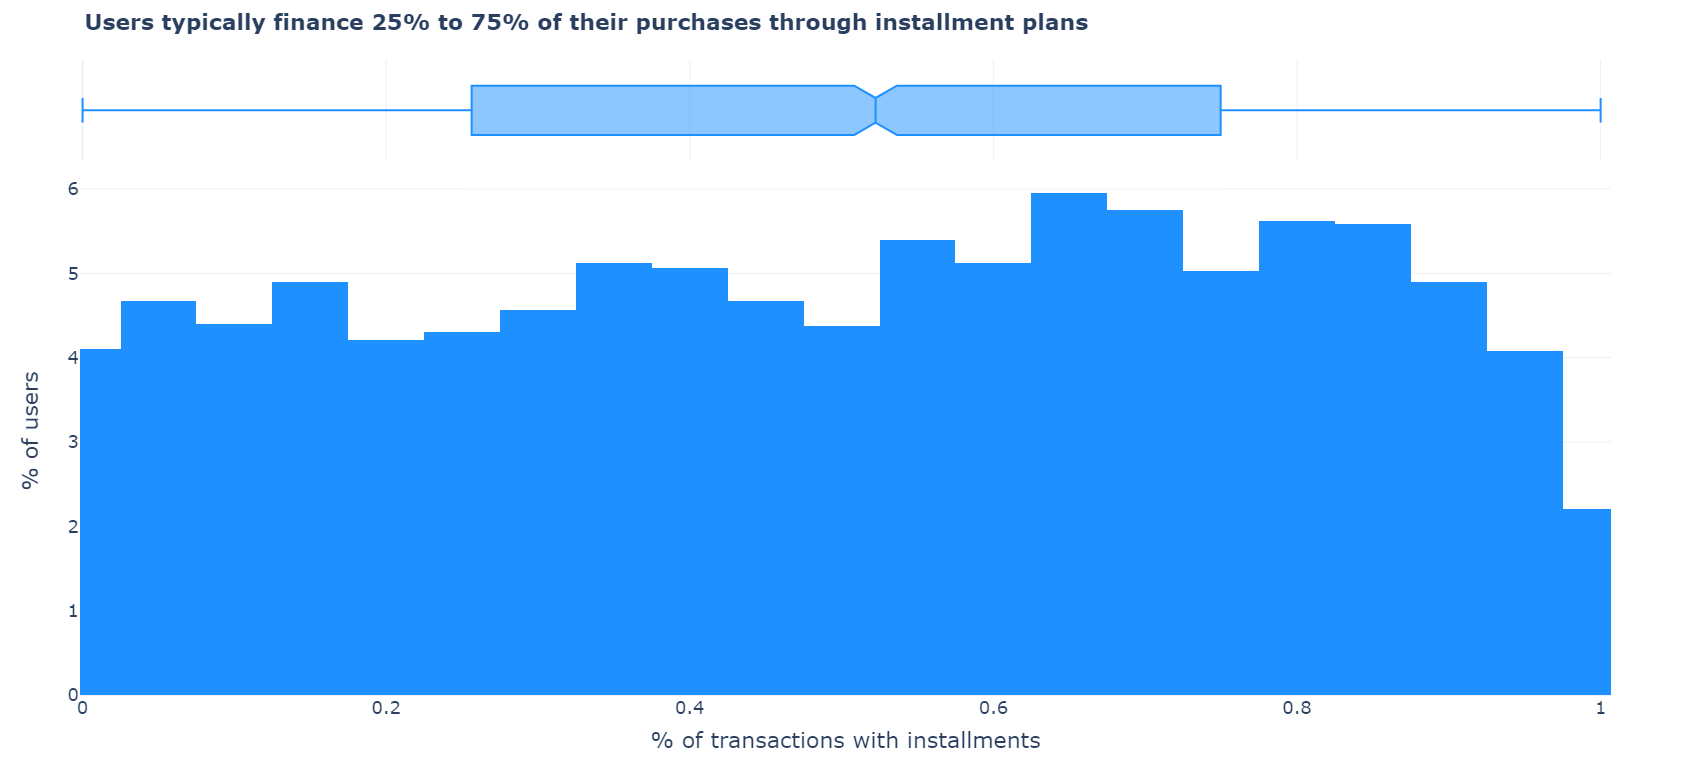

In [31]:
df_users["rate_transactions_installment"].astype(float).describe()

count    3043.000000
mean        0.502685
std         0.288692
min         0.000000
25%         0.256330
50%         0.522388
75%         0.749419
max         1.000000
Name: rate_transactions_installment, dtype: float64

## Installments

**Note:** Users typically opt for installment plans ranging from 2-4 payments for their purchases

In [32]:
fig = px.histogram(
    df_users,
    x="median_intallments",
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Users typically opt for installment plans ranging from 2-4 payments for their purchases</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="number of installments",
    yaxis_title="% of users",
    template=template,
)

fig.show()

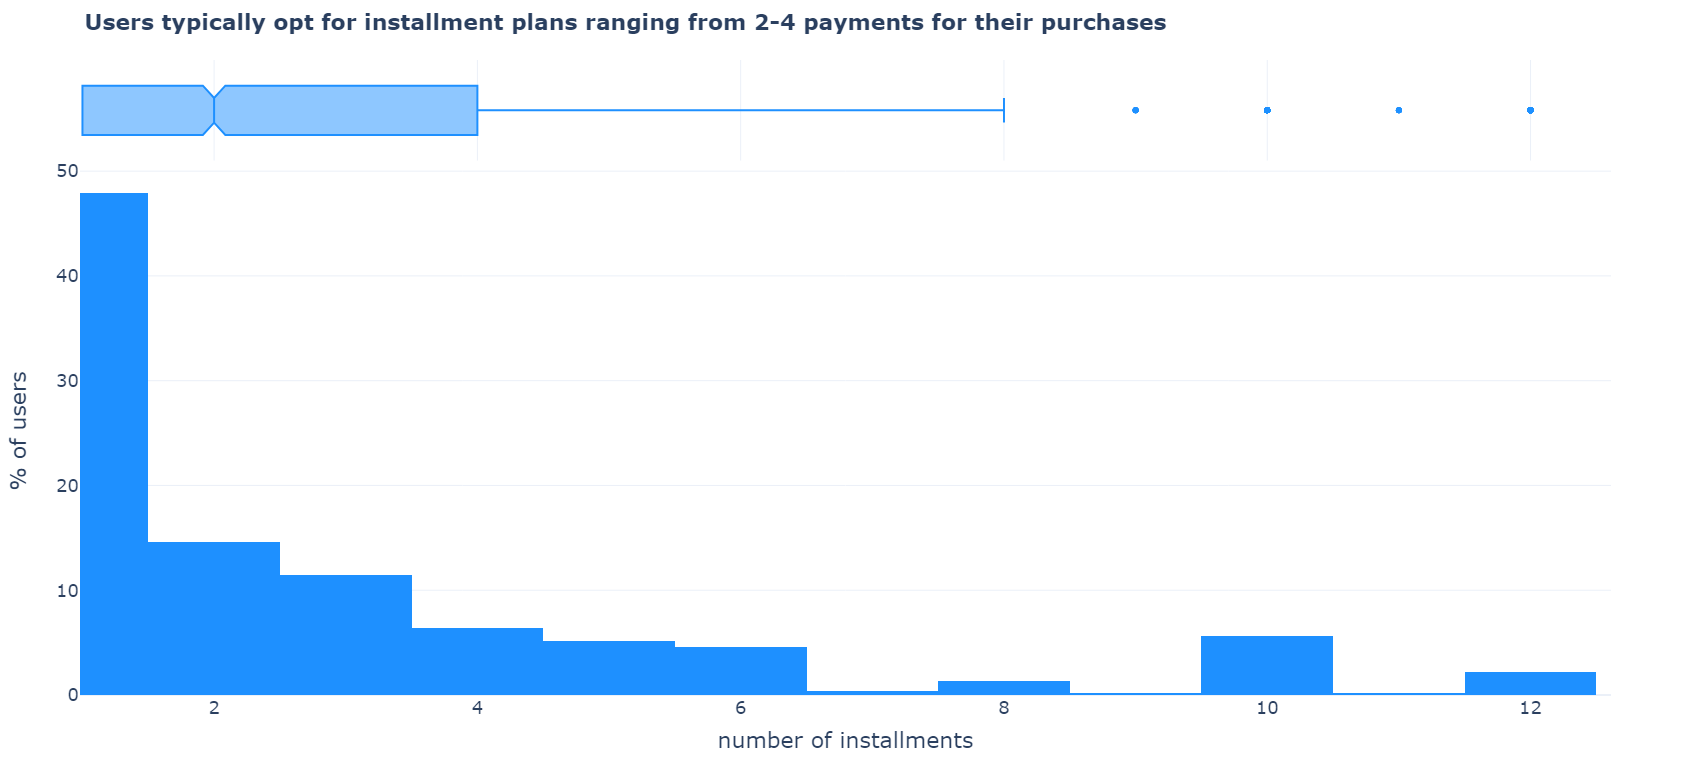

In [33]:
df_users["median_intallments"].describe()

count    3043.000000
mean        2.901084
std         2.801640
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        12.000000
Name: median_intallments, dtype: float64

## Denied Transactions

**Note:** Users encounter denied transactions, less than 20% of time

In [34]:
fig = px.histogram(
    df_users,
    x="rate_denied",
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Users encounter denied transactions, less than 20% of time</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="denied transactions ratio",
    yaxis_title="% of users",
    template=template,
)

fig.show()

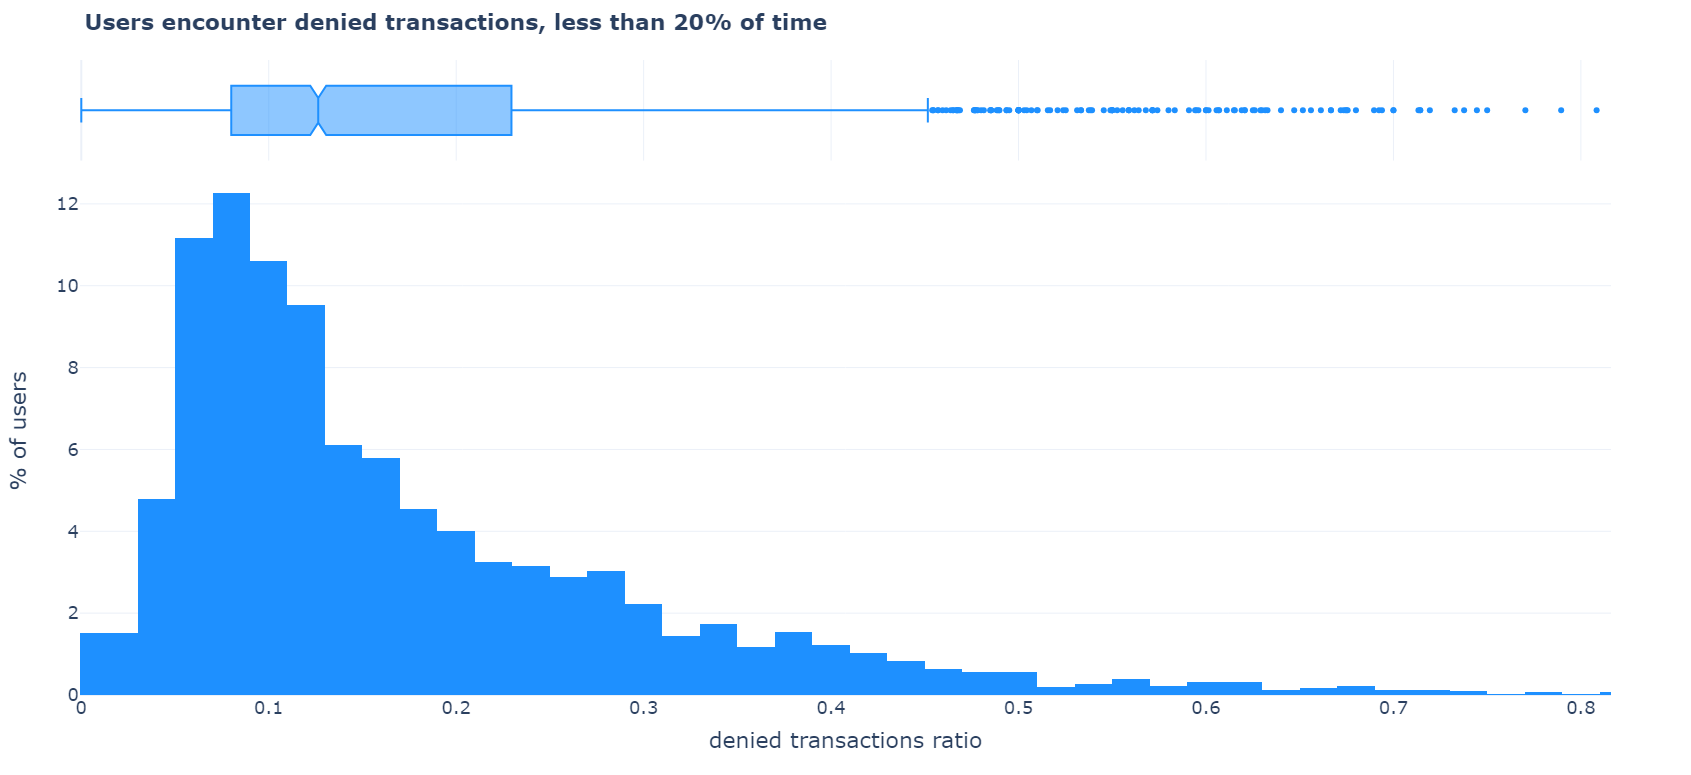

In [35]:
df_users["rate_denied"].describe()

count    3043.000000
mean        0.172152
std         0.133161
min         0.000000
25%         0.080000
50%         0.126404
75%         0.229460
max         0.857585
Name: rate_denied, dtype: float64

## Purchases Mode

**Note:** Our base consists of users who value in-person purchases

In [36]:
fig = px.histogram(
    df_users,
    x="online_person_preference",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Our base consists of users who value in-person purchases</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="purchase type",
    yaxis_title="% of users",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="outside"
)

fig.show()

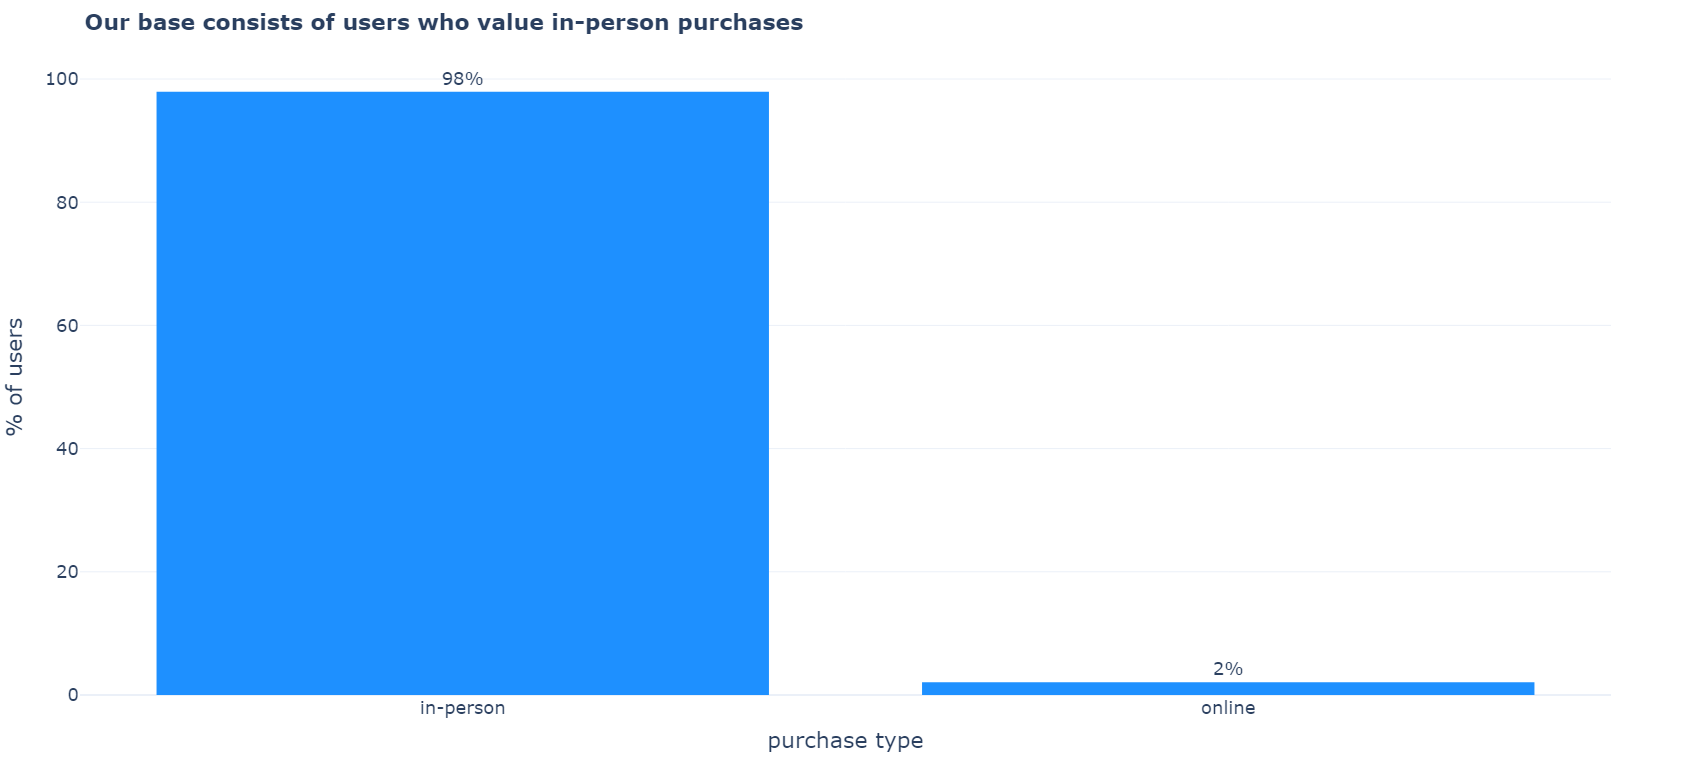

## User Number of Loans

**Note:** The majority of the users have taken 1 to 2 loans

In [37]:
df_users["num_loans"].describe()

count    2660.000000
mean        1.980451
std         1.648159
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        21.000000
Name: num_loans, dtype: float64

## User Default Rate

**Note:** 
- 65% of our users have defaulted at least once during the repayment process
- Individuals who default typically exhibit default rates ranging from 3%-10%

In [38]:
fig = px.histogram(
    df_users,
    x="has_defaulted",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>65% of our users have defaulted at least once during the repayment process</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title=None,
    yaxis_title="% of users",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

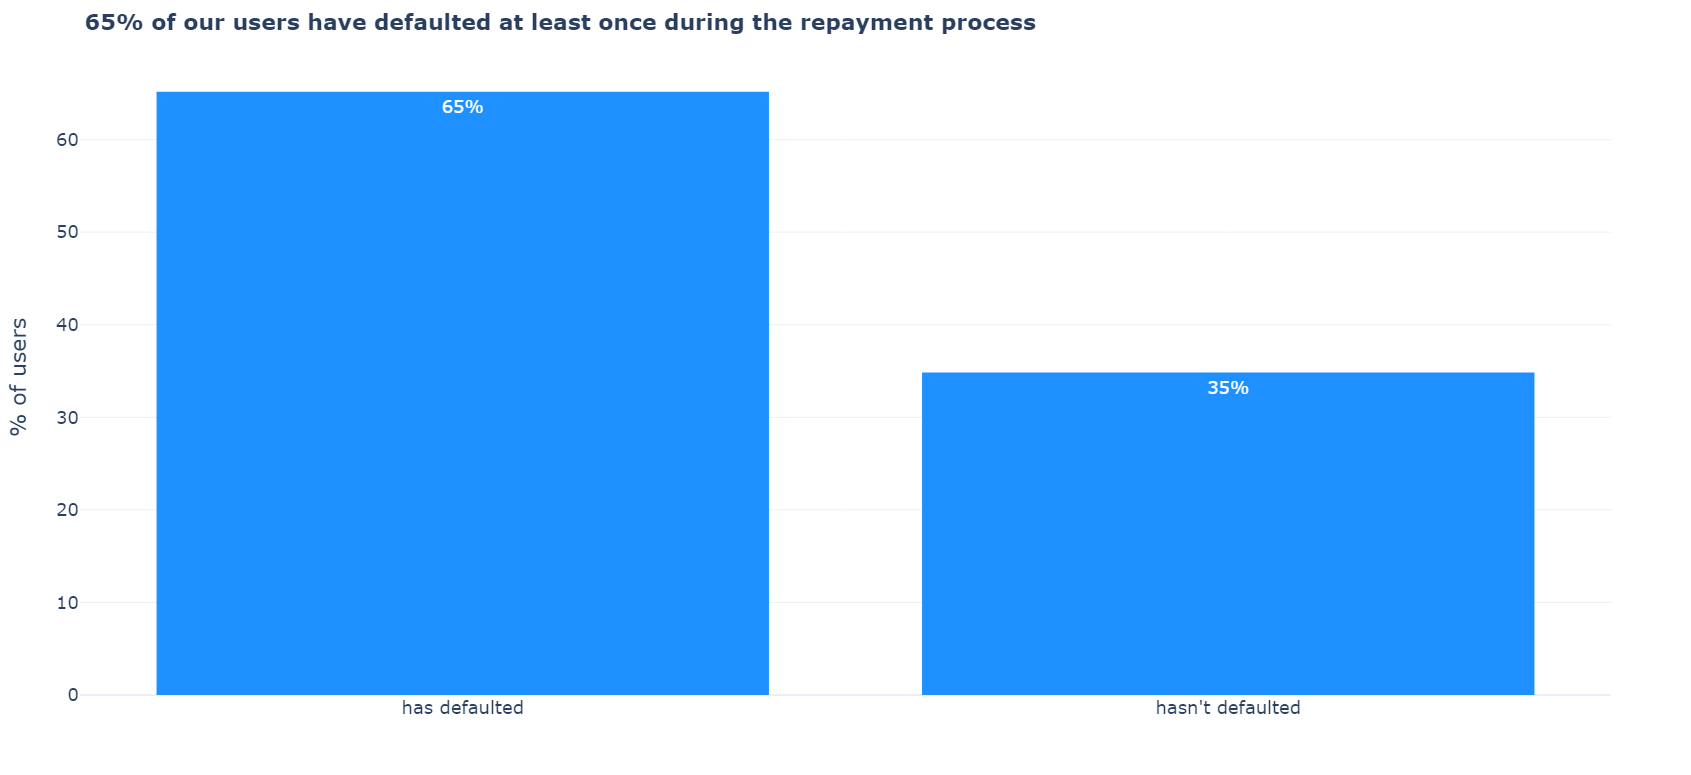

In [39]:
fig = px.histogram(
    x=df_users[df_users["has_defaulted"] == "has defaulted"]["rate_default"] * 100,
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Individuals who default typically exhibit default rates ranging from 3%-10%</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="default rate (%)",
    yaxis_title="% of users (default)",
    template=template,
)

fig.show()

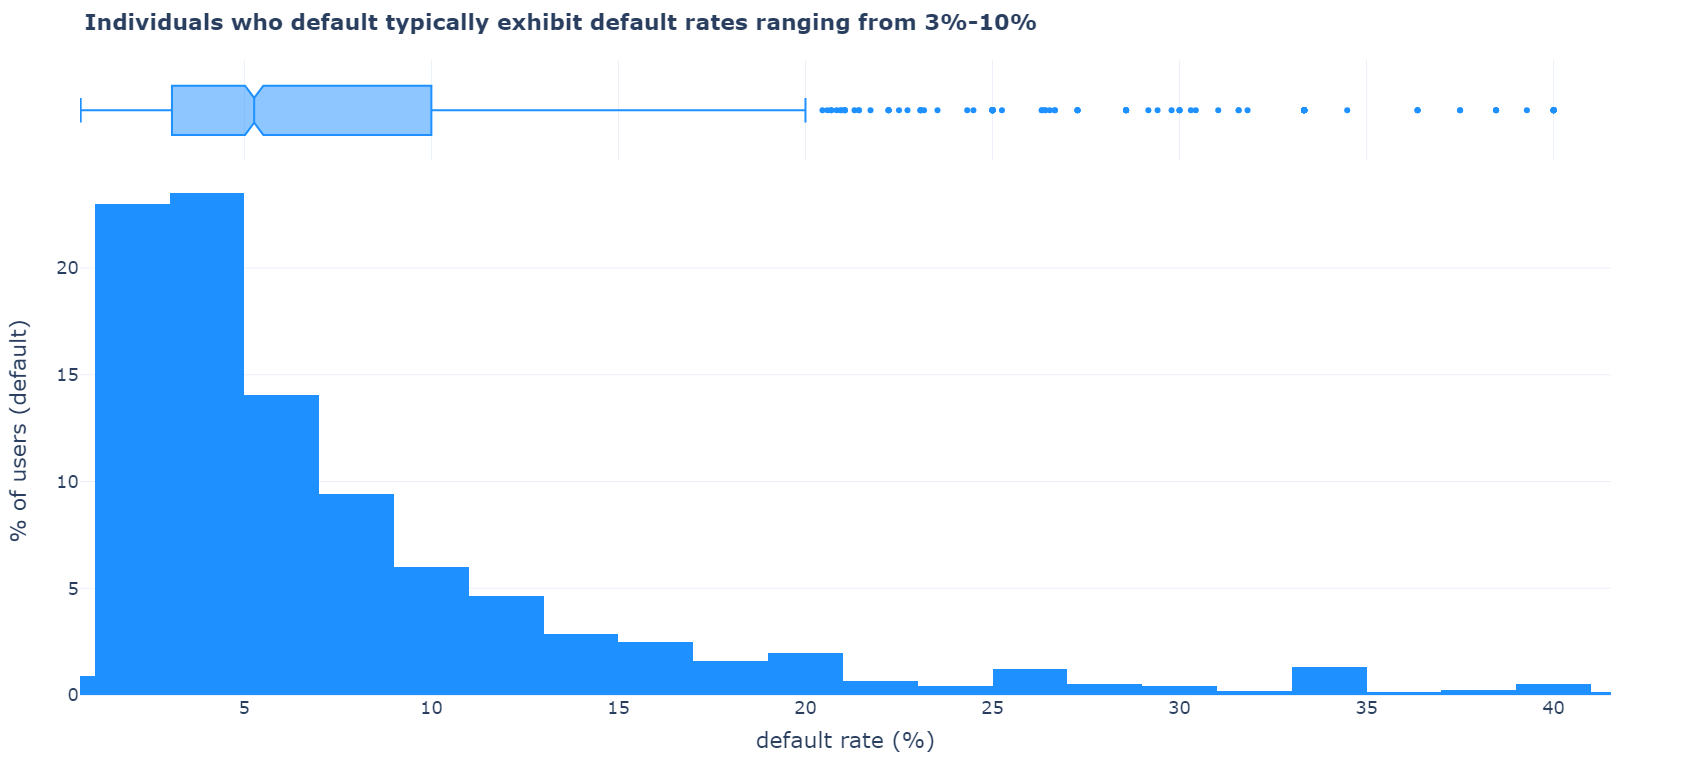

## User Overdue

**Note:**
- 31% of the users have exceeded loan due date at least once during the repayment process
- Individuals who exceed the due date, tend to delay between 4%-15% of the repayments
- Users who exceed the due date, tend to delay the repayments from 4-13 days

In [40]:
fig = px.histogram(
    df_users,
    x="has_exceeded_due_date",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>31% of the users have exceeded loan due date at least once during the repayment process</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title=None,
    yaxis_title="% of users",
    template=template,
)
fig.update_xaxes(
    categoryorder="total descending"
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

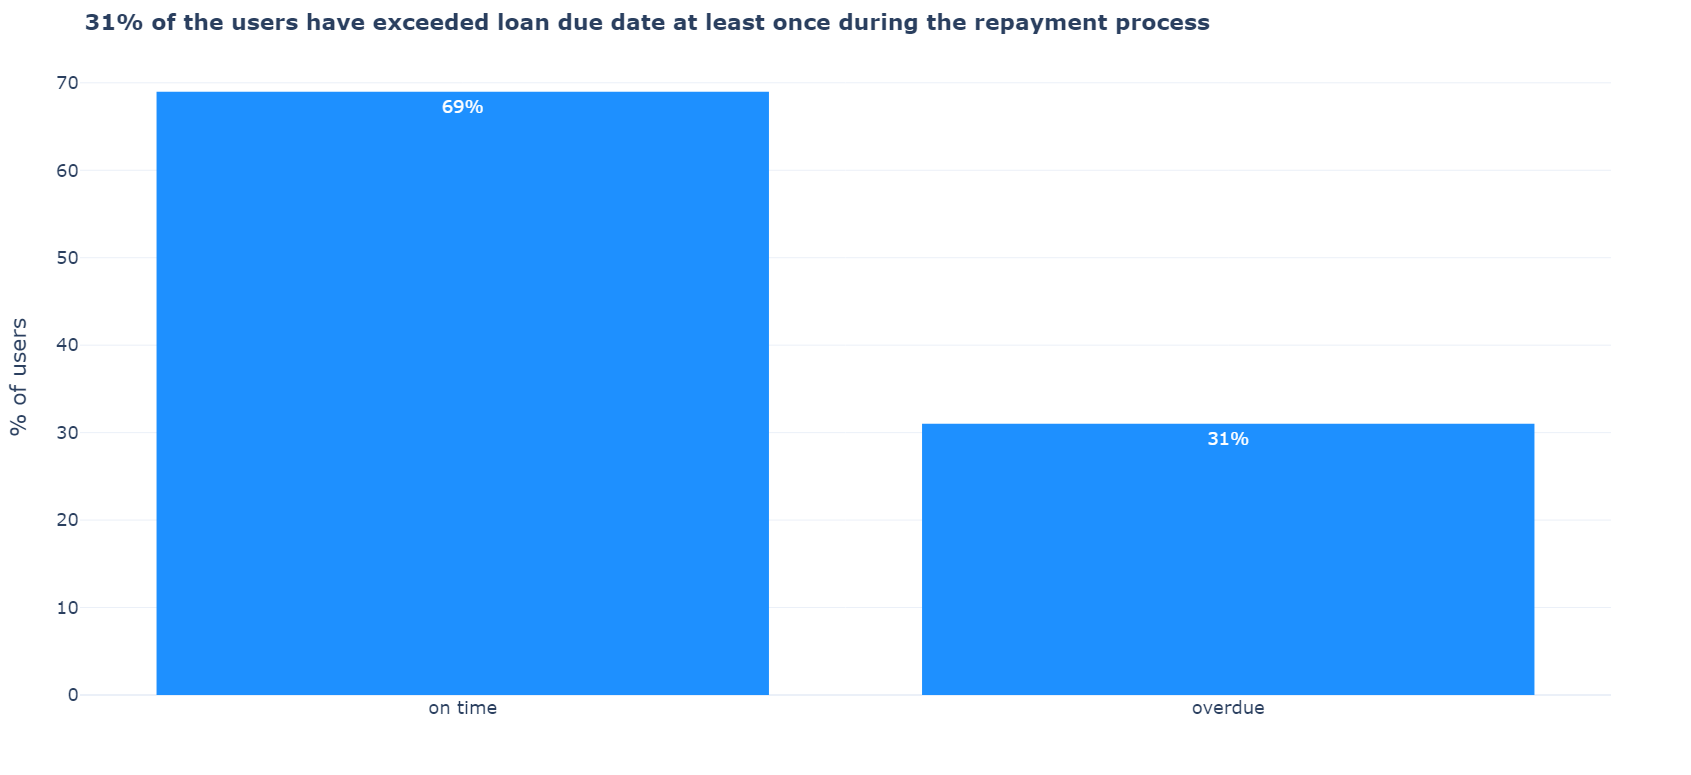

In [41]:
fig = px.histogram(
    x=df_users[df_users["has_exceeded_due_date"] == "overdue"]["rate_late_repayment"] * 100,
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>Users who exceed the due date, tend to delay between 4%-15% of the repayments</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="late repayments rate (%)",
    yaxis_title="% of users",
    template=template,
)

fig.show()

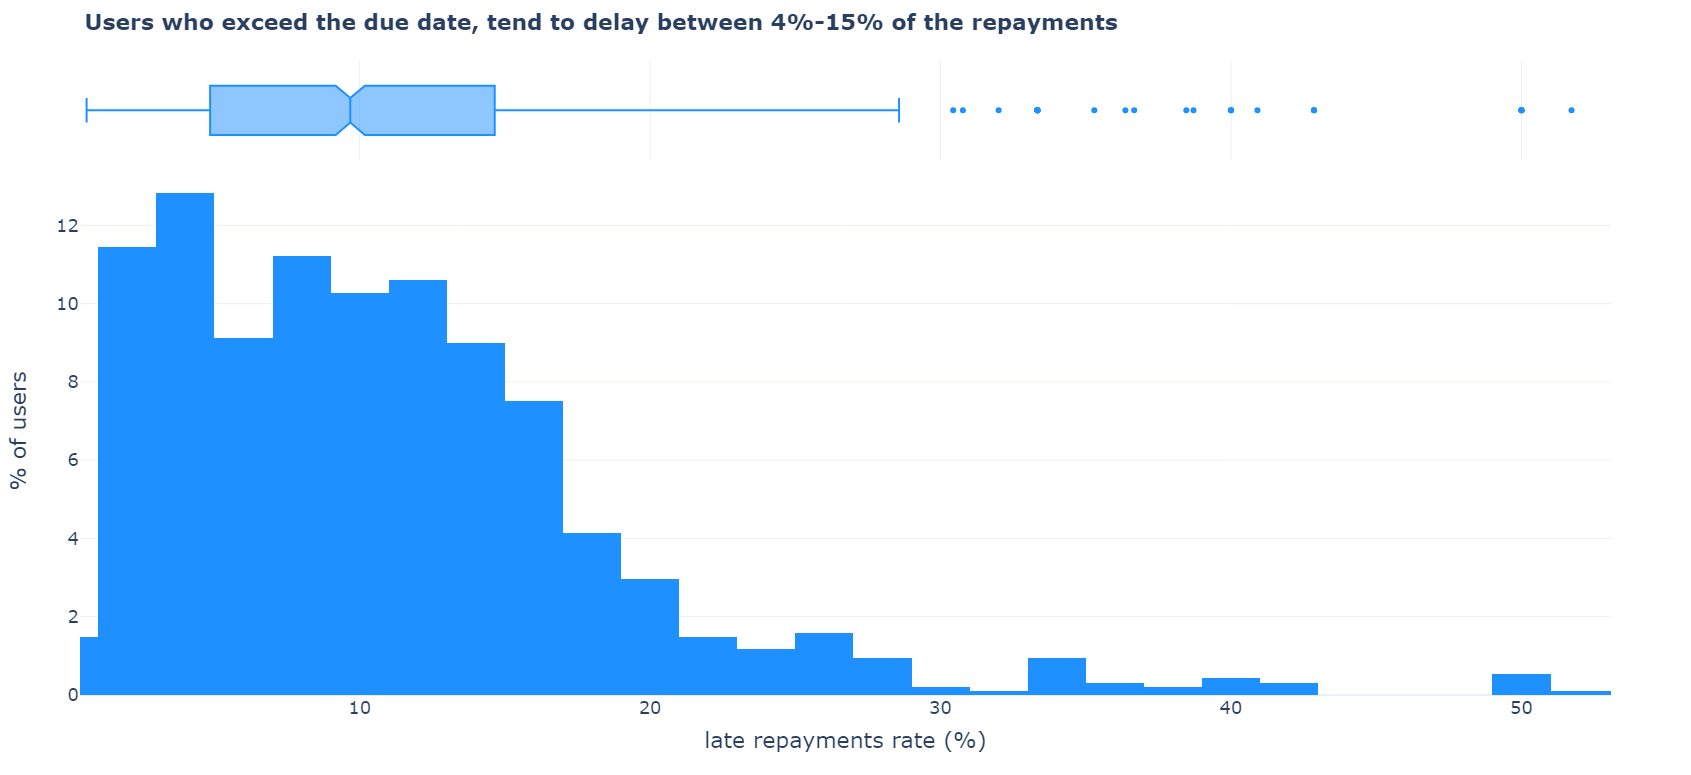

In [42]:
df_users[df_users["has_exceeded_due_date"] == "overdue"]["rate_late_repayment"].describe()

count    944.000000
mean       0.116205
std        0.109339
min        0.005988
25%        0.048583
50%        0.096774
75%        0.146423
max        1.000000
Name: rate_late_repayment, dtype: float64

In [43]:
# Users who exceed the due date, tend to delay the repayments from 4-13 days
df_users[df_users["max_repayment_delay"] > 0]["max_repayment_delay"].describe()

count    944.000000
mean       9.710805
std       17.185102
min        1.000000
25%        4.000000
50%       10.000000
75%       13.000000
max      391.000000
Name: max_repayment_delay, dtype: float64

## Manual Repayment Preference

**Note:** Users typically prefer an automated plan of loan repayment

In [44]:
fig = px.histogram(
    x=df_users["rate_manual_auto_repayments"],
    histnorm="percent",
    marginal="box",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.add_vline(x=1, 
              line_width=3, 
              line_dash="dash", 
              line_color=colors["dark_gray"],
              annotation_text="<b>baseline</b>",
              annotation_position="top right",
              annotation_font_size=font_size,
              annotation_yshift=25,
              annotation_xshift=-45,
              annotation_font_color=colors["dark_gray"])

fig.update_layout(
    title="<b>Users typically prefer an automated plan of loan repayment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="preference <br>manual to auto repayment (%)",
    yaxis_title="% of users",
    template=template,
)

fig.show()

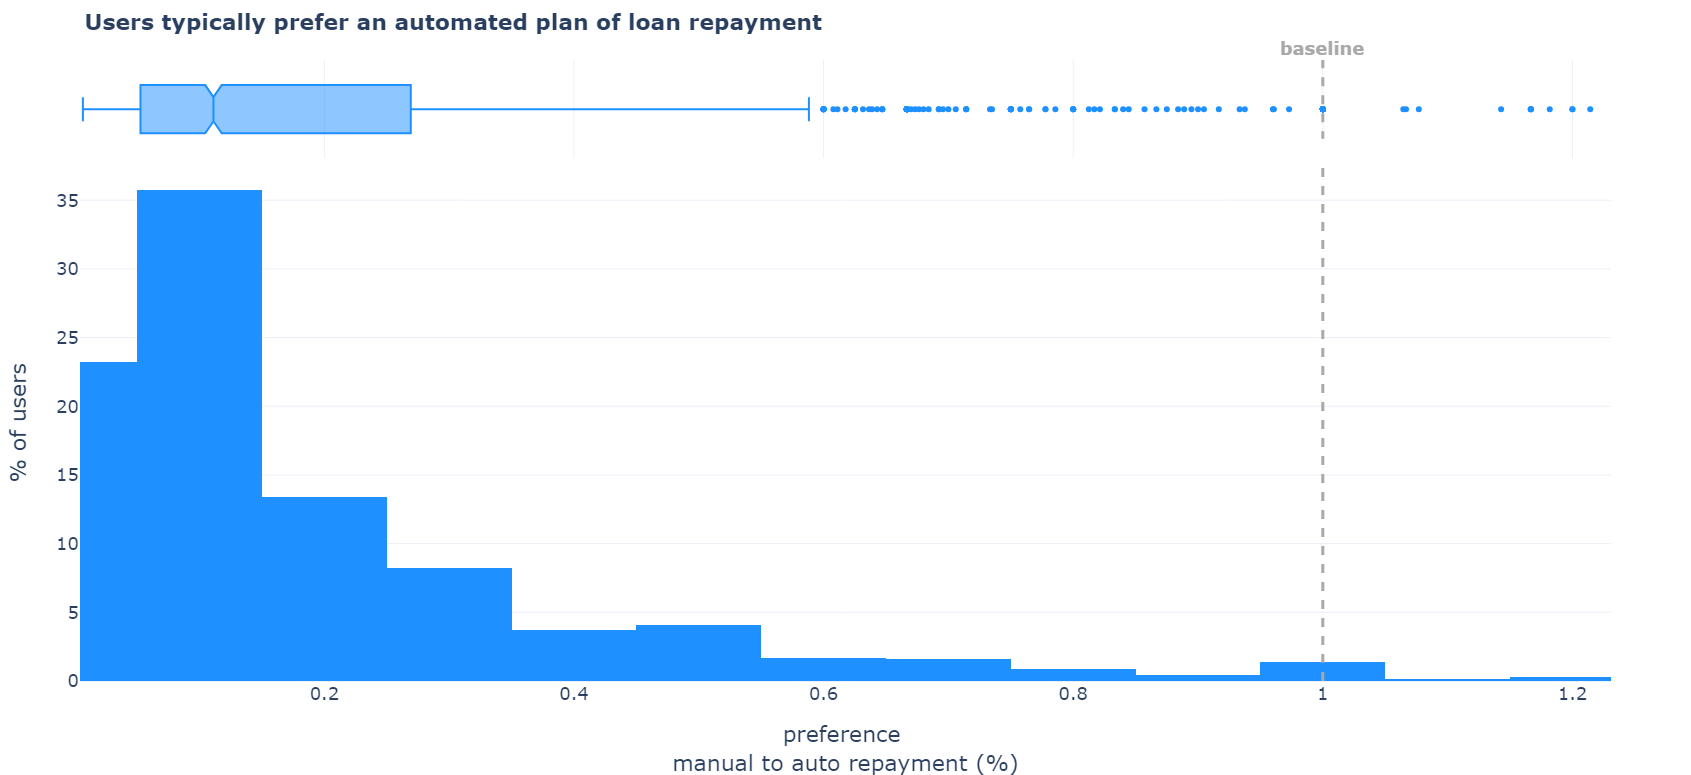

In [45]:
df_users["rate_manual_auto_repayments"].describe()

count    2660.000000
mean        0.331841
std         0.860075
min         0.006494
25%         0.052632
50%         0.111111
75%         0.269231
max        16.000000
Name: rate_manual_auto_repayments, dtype: float64

# RFM Analysis

- Customer (User) Segmentation based on RFM Analysis
- RFM segments the consumer (user) base by their purchasing patterns or habits based on Recency (R), Frequency (F) and Monetary Value (M)
- *Recency:* how long ago they made a purchase
- *Frequency:* how often they make purchases
- *Monetary Value:* how much money they spend

## Scores Definitions

Typically, RFM scores are in a scale of 1-5. 

However, for the purpose of loan repayment analysis, the scores are considered in a scale of 1-3 (the lower, the better the results for a customer) in order to avoid segments that have similar behavior regarding loan repayment.

| Recency | Frequency | Monetary |
| :-----: | :-------: | :------: |
| up to 1 month (1) | more than 500 (1) | more than R\\$ 500k (1) |
| 1 to 3 months (2) | 100 to 500 (2) | R\\$ 100k to 500k (2) |
| more than 3 months (3) | less than 100 (3) | less than R\\$100k (3) |t |

In [46]:
df_users[["recency", "frequency", "monetary"]].describe()

recency     frequency      monetary
count  3043.000000   3043.000000  3.043000e+03
mean    125.346369    473.829445  6.592698e+05
std      91.242729   1047.322255  1.951745e+07
min       0.000000      1.000000  4.150000e+01
25%      42.000000     74.000000  5.357745e+04
50%     105.000000    179.000000  1.032773e+05
75%     196.000000    463.000000  1.984965e+05
max     358.000000  25660.000000  1.000132e+09

In [47]:
# Recency buckets
# Higher values indicate users who haven't made a purchase for a long time (not active)
# q1, q3 = df_users["recency"].quantile(.25), df_users["recency"].quantile(.75)

df_users.loc[df_users["recency"] <= 30, "recency_bin"] = "1"
df_users.loc[df_users["recency"].between(30, 90, inclusive="right"), "recency_bin"] = "2"
df_users.loc[df_users["recency"] > 90, "recency_bin"] = "3"

In [48]:
# Frequency buckets
# Higher values indicate users who make frequent purchases (more active)
q1, q3 = df_users["frequency"].quantile(.25), df_users["frequency"].quantile(.75)

df_users.loc[df_users["frequency"] <= 100, "frequency_bin"] = "3"
df_users.loc[df_users["frequency"].between(100, 500, inclusive="right"), "frequency_bin"] = "2"
df_users.loc[df_users["frequency"] > 500, "frequency_bin"] = "1"

In [49]:
# Monetary buckets
# Higher values indicate users with higher spendings
q1, q3 = df_users["monetary"].quantile(.25), df_users["monetary"].quantile(.75)

df_users.loc[df_users["monetary"] <= 100_000, "monetary_bin"] = "3"
df_users.loc[df_users["monetary"].between(100_000, 500_000, inclusive="right"), "monetary_bin"] = "2"
df_users.loc[df_users["monetary"] > 500_000, "monetary_bin"] = "1"

## Segment Definitions

Customer (user) segments identified:
- **Champions:** Extremely active cutomers (high frequency and low recency) with moderate to high monetary value
- **Big Spenders:** Active customers (medium recency and frequency) with high monetary value
- **Promising:** Active customers (medium recency and frequency) with low to moderate monetary value
- **Recent:** Customers who entered our base recently (low frequency and moderate to high recency) with low to moderate monetary value
- **Inactive:** Customers with extremely low activity (low recency and low to moderate frequency); monetary value isn't a factor here

In [50]:
df_users["rfm_segment"] = df_users["recency_bin"] + df_users["frequency_bin"] + df_users["monetary_bin"]

In [51]:
# define customer clusters based on RFM Analysis
cluster_1 = ["111", "113", "112"]  # Champions
cluster_2 = ["121", "231", "221", "211"]  # Big Spenders
cluster_3 = ["213", "122", "123", "212", "222", "223", "311", "313", "312"]  # Promising Customers
cluster_4 = ["131", "132", "133", "232", "233"]  # Recent Customers
cluster_5 = ["331", "332", "333", "321", "322", "323"]  # Inactive Customers

clusters = list(
    zip(
        [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5],
        ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]
    )
)

for cluster, label in clusters:
    df_users.loc[df_users["rfm_segment"].isin(cluster), "rfm_segment_desc"] = label

In [52]:
fig = px.histogram(
    df_users,
    x="rfm_segment_desc",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>83% of the users are frequent buyers, with moderate to modest spending habits<br><sub>(Promising and Inactive segments)</sub></b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="% of user",
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

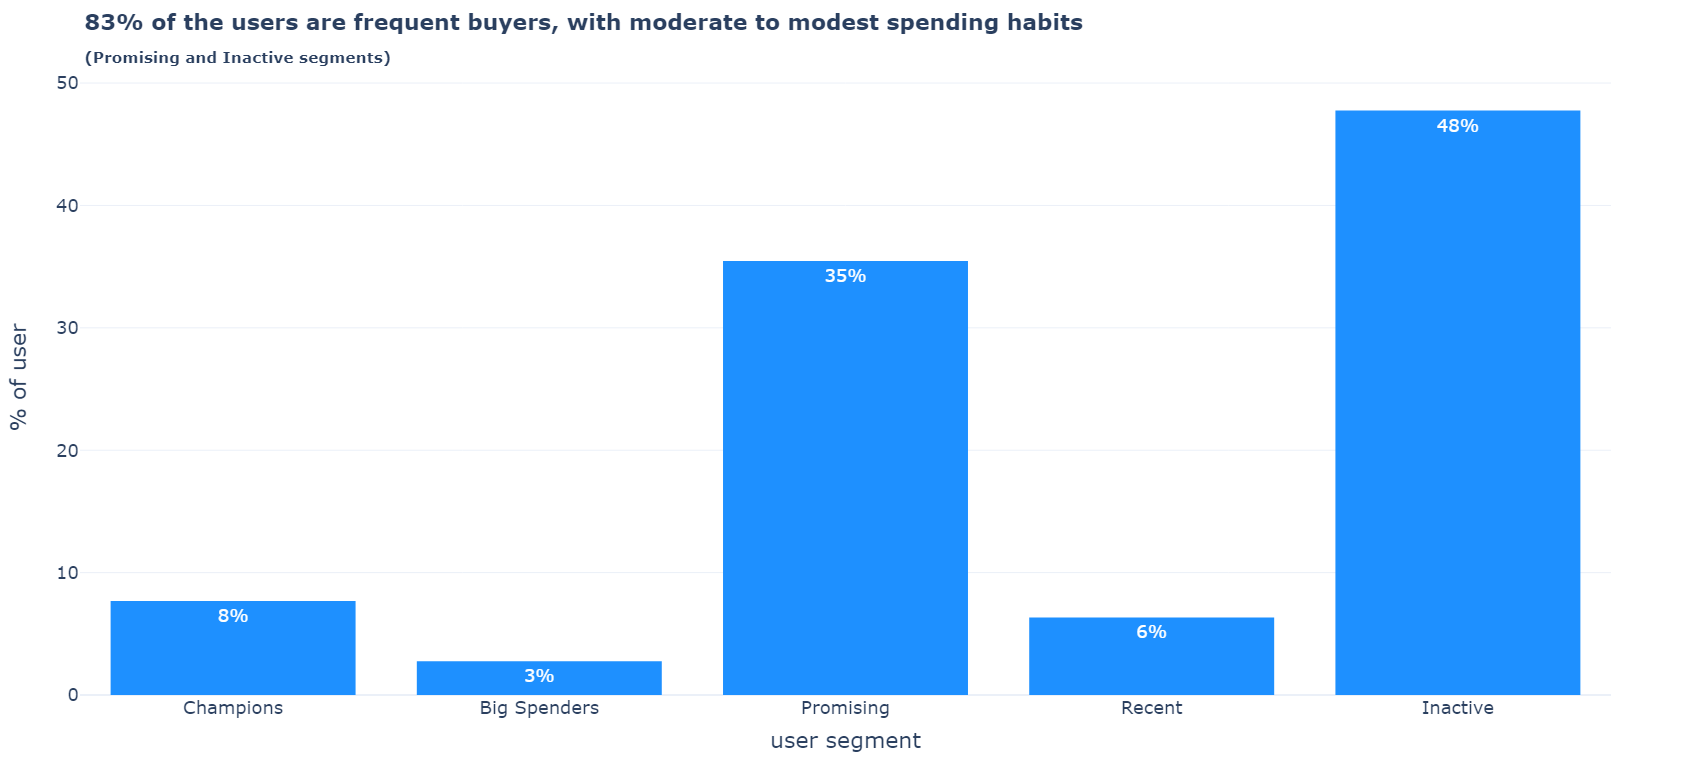

In [53]:
fig = px.box(
    df_users, 
    x="rfm_segment_desc", 
    y="recency",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Recency distribution per user (customer) segment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="Recency (days)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

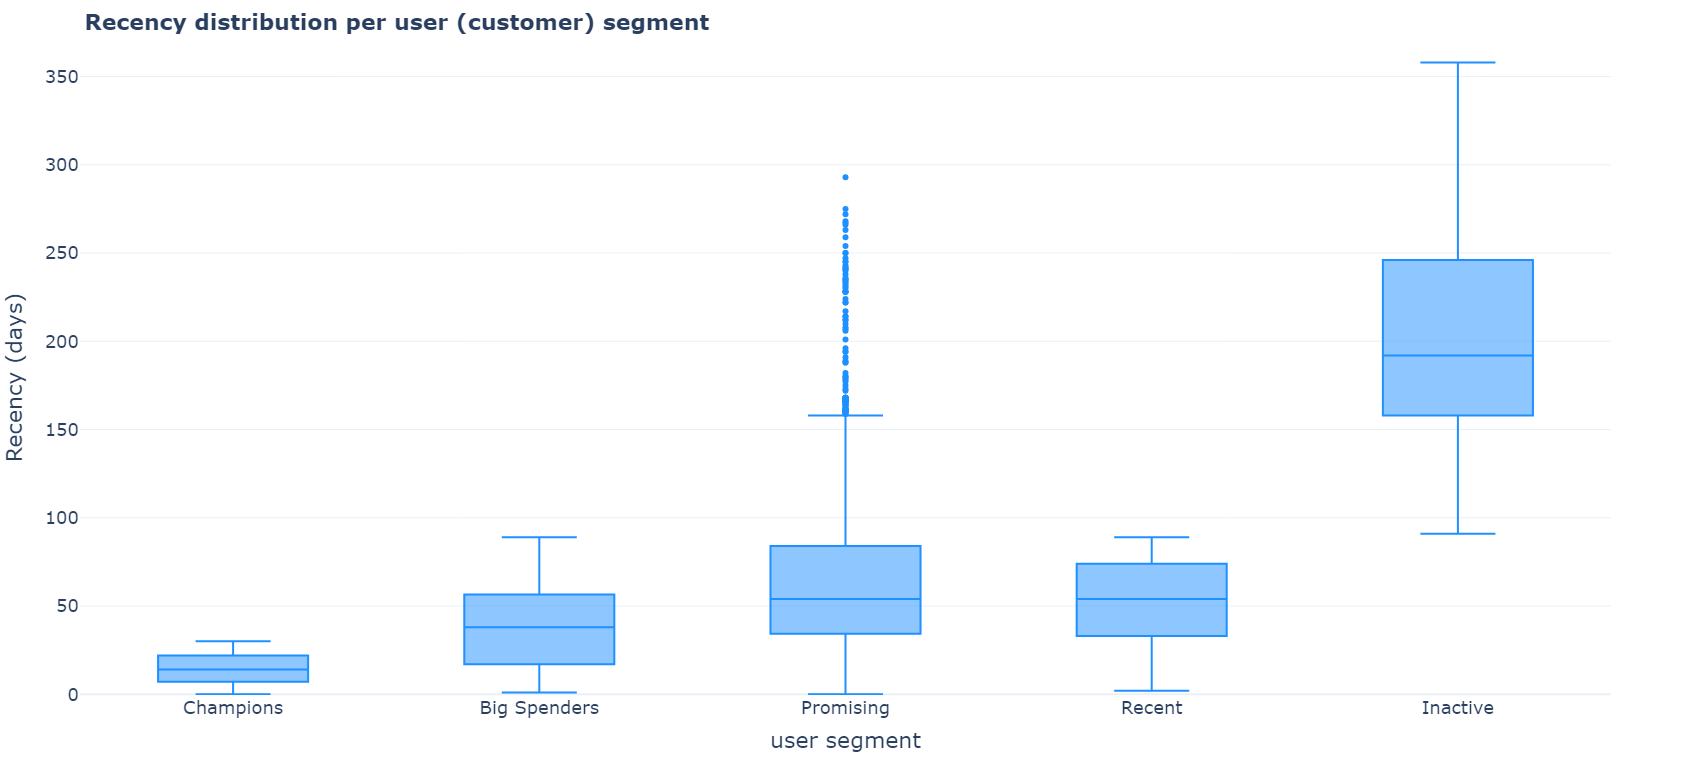

In [54]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["recency"].describe()

rfm_segment_desc   count        mean        std   min    25%    50%     75%  \
0     Big Spenders    84.0   38.654762  25.220710   1.0   17.0   38.0   56.25   
1        Champions   234.0   15.209402   8.483951   0.0    7.0   14.0   22.00   
2         Inactive  1453.0  200.197522  64.069835  91.0  158.0  192.0  246.00   
3        Promising  1079.0   68.266914  52.968671   0.0   34.5   54.0   84.00   
4           Recent   193.0   52.207254  24.212569   2.0   33.0   54.0   74.00   

     max  
0   89.0  
1   30.0  
2  358.0  
3  293.0  
4   89.0

In [55]:
fig = px.box(
    df_users, 
    x="rfm_segment_desc", 
    y="frequency",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Frequency distribution per user (customer) segment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="Frequency<br>(number of purchases)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

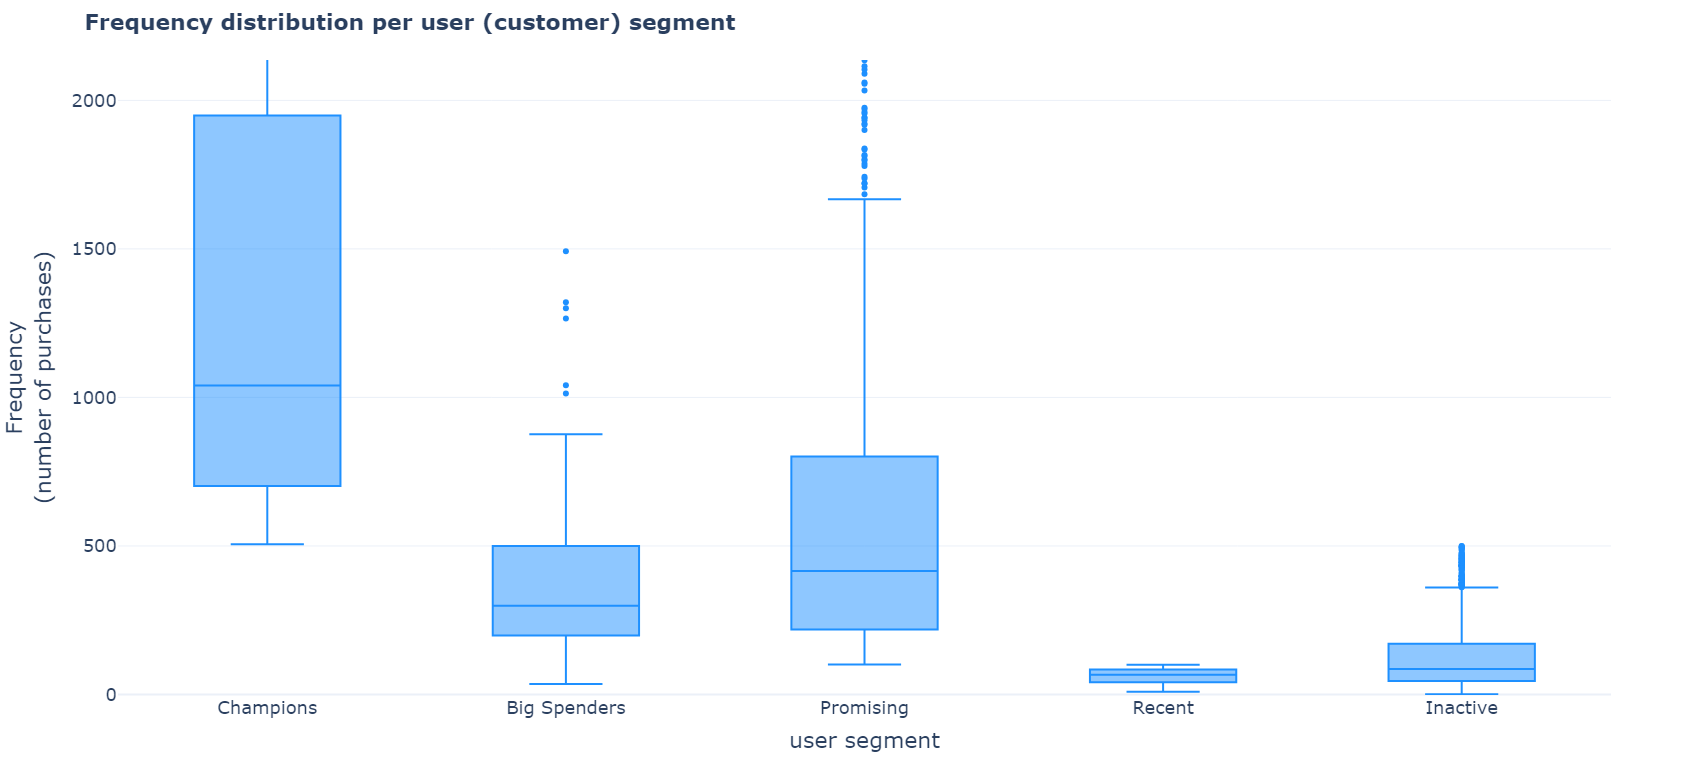

In [56]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["frequency"].describe()

rfm_segment_desc   count         mean          std    min     25%     50%  \
0     Big Spenders    84.0   665.071429  1467.146109   35.0  198.75   298.5   
1        Champions   234.0  1761.388889  1903.618172  506.0  704.75  1040.0   
2         Inactive  1453.0   124.800413   110.861813    1.0   45.00    86.0   
3        Promising  1079.0   723.357739  1228.848701  101.0  219.00   416.0   
4           Recent   193.0    62.145078    25.583598    9.0   41.00    66.0   

       75%      max  
0   498.25  10713.0  
1  1922.75  15517.0  
2   171.00    500.0  
3   800.00  25660.0  
4    84.00    100.0

In [57]:
fig = px.box(
    df_users, 
    x="rfm_segment_desc", 
    y="monetary",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Monetary amount distribution per user (customer) segment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="Monetary amount (R$)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

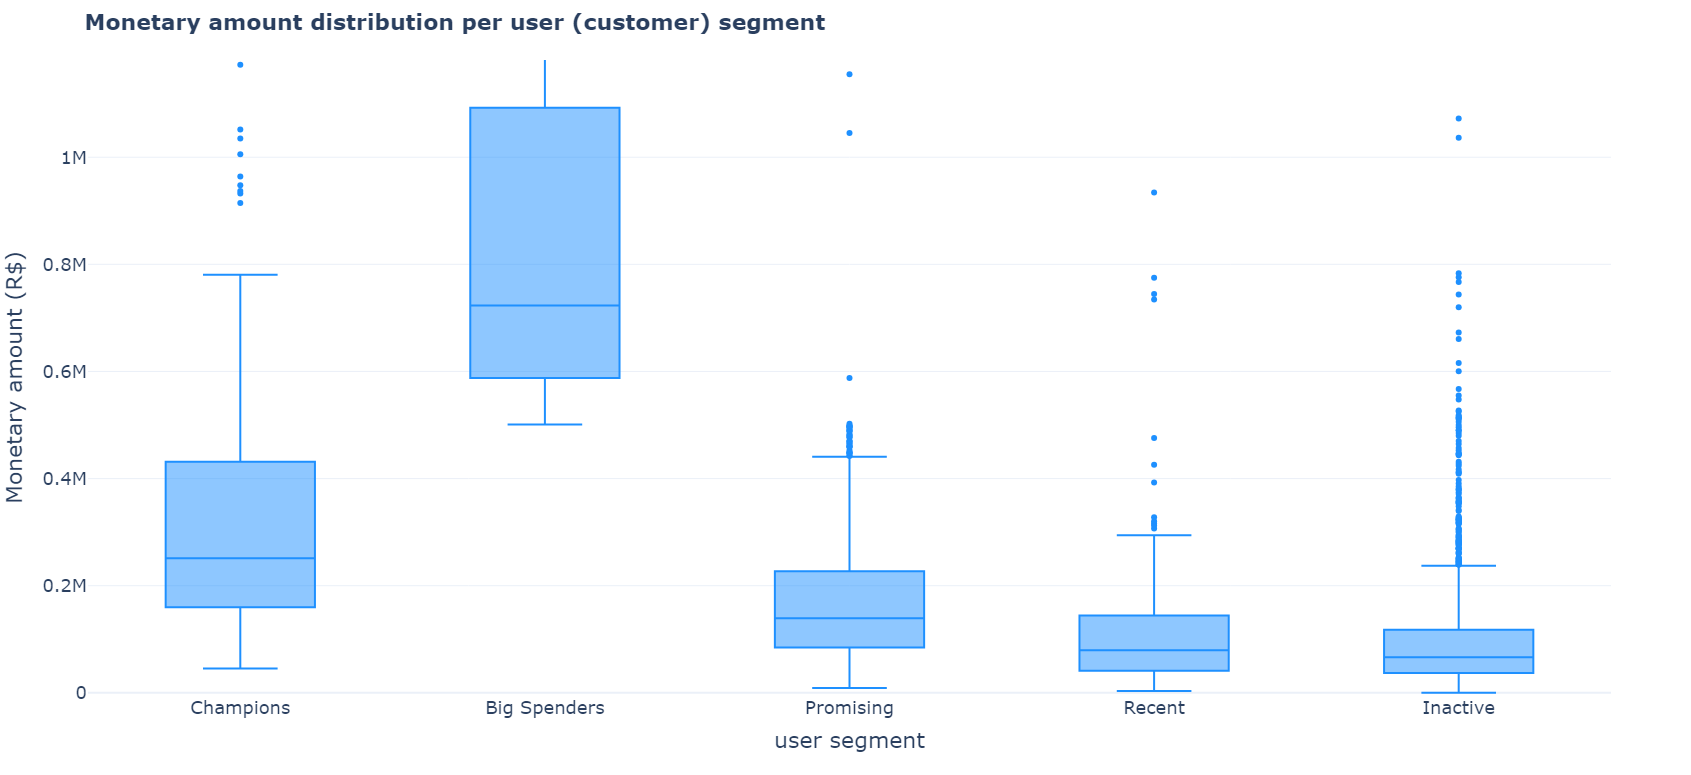

In [58]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["monetary"].describe()

rfm_segment_desc   count          mean           std        min  \
0     Big Spenders    84.0  1.788642e+07  1.167952e+08  500928.83   
1        Champions   234.0  3.575111e+05  3.672372e+05   45570.97   
2         Inactive  1453.0  1.267138e+05  5.941056e+05      41.50   
3        Promising  1079.0  1.973428e+05  5.962927e+05    8776.76   
4           Recent   193.0  1.191376e+05  1.315886e+05    3508.37   

           25%         50%          75%           max  
0  588990.5825  722995.250  1083493.380  1.000132e+09  
1  159925.9800  251296.575   430517.105  3.313743e+06  
2   37095.3000   66212.000   117817.980  2.046910e+07  
3   84446.8800  139180.370   226928.645  1.406241e+07  
4   41413.0400   79474.430   143526.500  9.340907e+05

## ✅ checkpoint

In [59]:
df_users_segments = df_users[["user_id", "rfm_segment_desc"]]

In [60]:
df_users_segments.to_pickle("../data/processed/df_users_segments.pkl")

# Segment Purchasing Behavior

## Card Type Preference

**Notes:** Champions and Promising customers equally prefer purchasing with credit and debit

In [61]:
fig = px.box(
    df_users, 
    y="rate_credit_debit", 
    x="rfm_segment_desc",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.add_hline(y=1, 
              line_width=3, 
              line_dash="dash", 
              line_color=colors["dark_gray"],
              annotation_text="<b>baseline</b>",
              annotation_position="top right",
              annotation_font_size=font_size,
              annotation_yshift=0,
              annotation_xshift=30,
              annotation_font_color=colors["dark_gray"])

fig.update_layout(
    title="<b>Champions and Promising customers equally prefer purchasing with credit and debit</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="credit to debit ratio",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

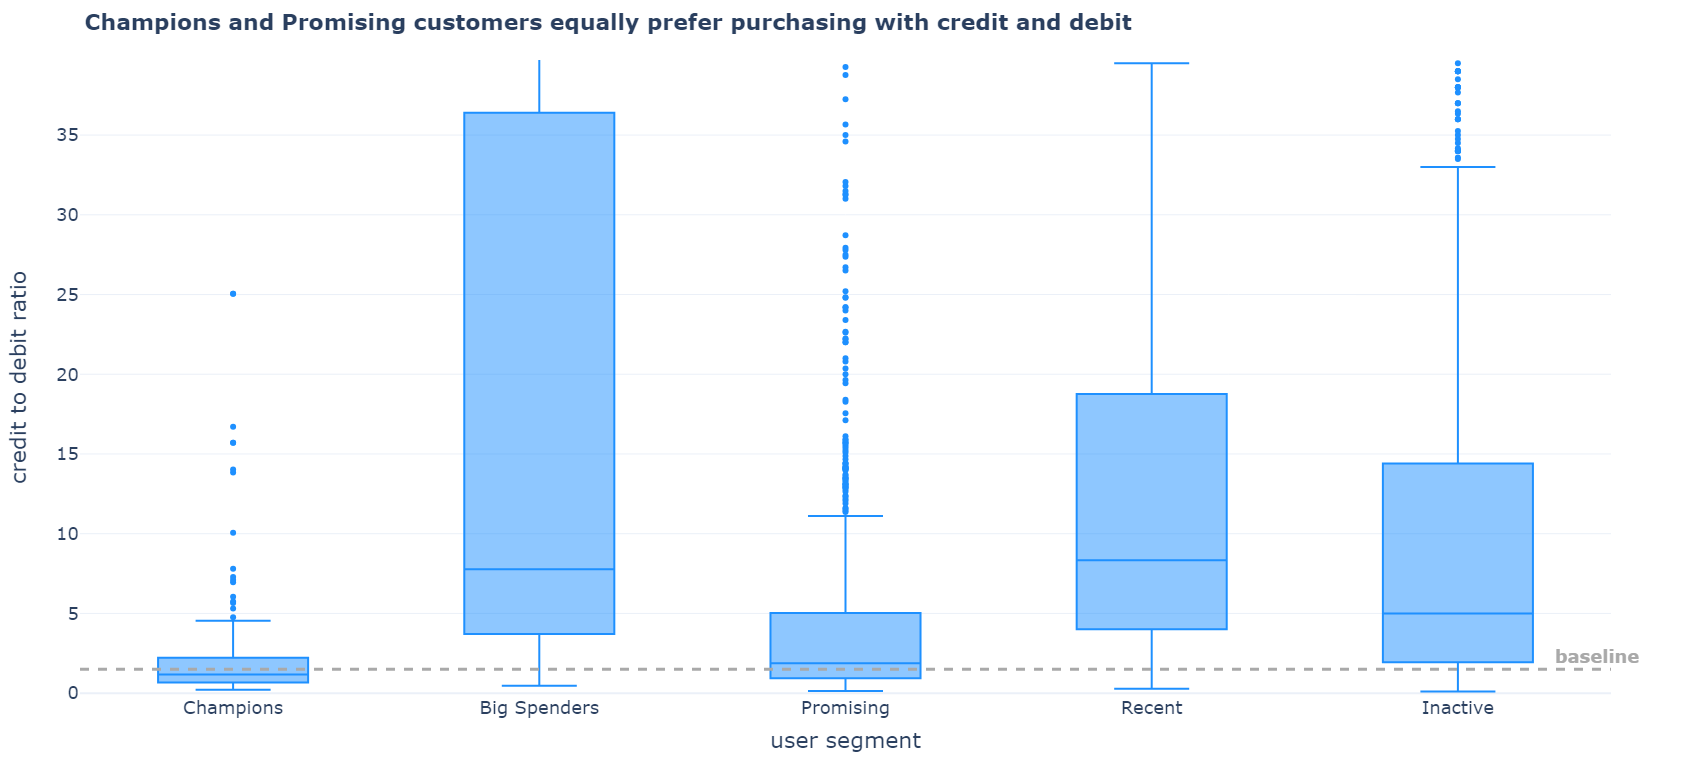

In [62]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["rate_credit_debit"].describe()

rfm_segment_desc   count       mean        std       min       25%  \
0     Big Spenders    84.0  39.723557  73.800987  0.459809  3.717568   
1        Champions   234.0   7.504539  36.576669  0.212894  0.662762   
2         Inactive  1453.0  13.977137  27.603383  0.104478  1.937500   
3        Promising  1079.0   7.645476  25.459517  0.133189  0.941023   
4           Recent   193.0  15.020980  17.405114  0.268293  4.000000   

        50%        75%    max  
0  7.766667  36.200000  339.0  
1  1.176209   2.220933  447.5  
2  5.000000  14.400000  358.0  
3  1.875000   5.020833  368.0  
4  8.333333  18.750000   97.0

## Purchases Mode

**Notes:** Big Spenders have a slight preference for online purchases

In [63]:
labels = ["Inactive", "Recent", "Promising", "Big Spenders", "Champions",]

fig = go.Figure([
    go.Bar(y=labels,
           x=[
               df_users[(df_users["rfm_segment_desc"] == label) & (df_users["online_person_preference"] == "in-person")]["user_id"].count() \
               / df_users[df_users["rfm_segment_desc"] == label]["user_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_blue"],
           orientation="h",
           name="in-person"),
    go.Bar(y=labels,
           x=[
               df_users[(df_users["rfm_segment_desc"] == label) & (df_users["online_person_preference"] == "online")]["user_id"].count() \
               / df_users[df_users["rfm_segment_desc"] == label]["user_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_gray"],
           orientation="h",
           name="online")
])

fig.update_layout(
    title="<b>Big Spenders have a slight preference for online purchases</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="% of users",
    yaxis_title="user segment",
    barmode="stack",
    bargroupgap=0.1,
    legend=dict(
        title="purchase",
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=labels
)
fig.update_traces(
    texttemplate="%{x:.0%}",
    textposition="outside"
)

fig.show()

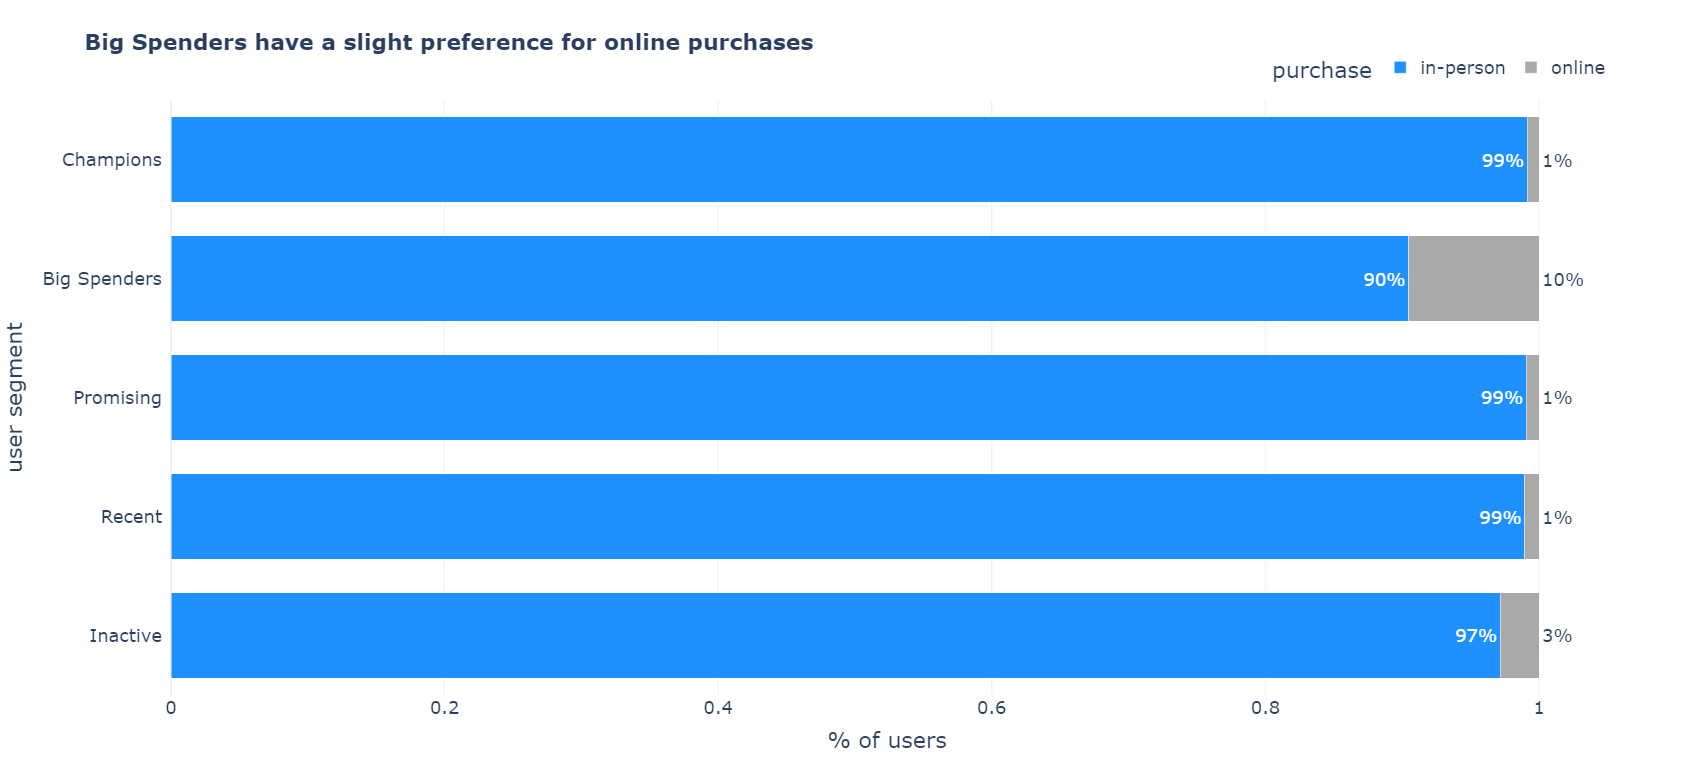

## Denied Transactions

**Notes:** Big Spenders and Recent customers have a higher likelihood of transaction rejection

In [64]:
fig = px.box(
    df_users, 
    y="rate_denied", 
    x="rfm_segment_desc",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Big Spenders and Recent customers have a higher likelihood of transaction rejection</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="transactions rejection rate (%)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

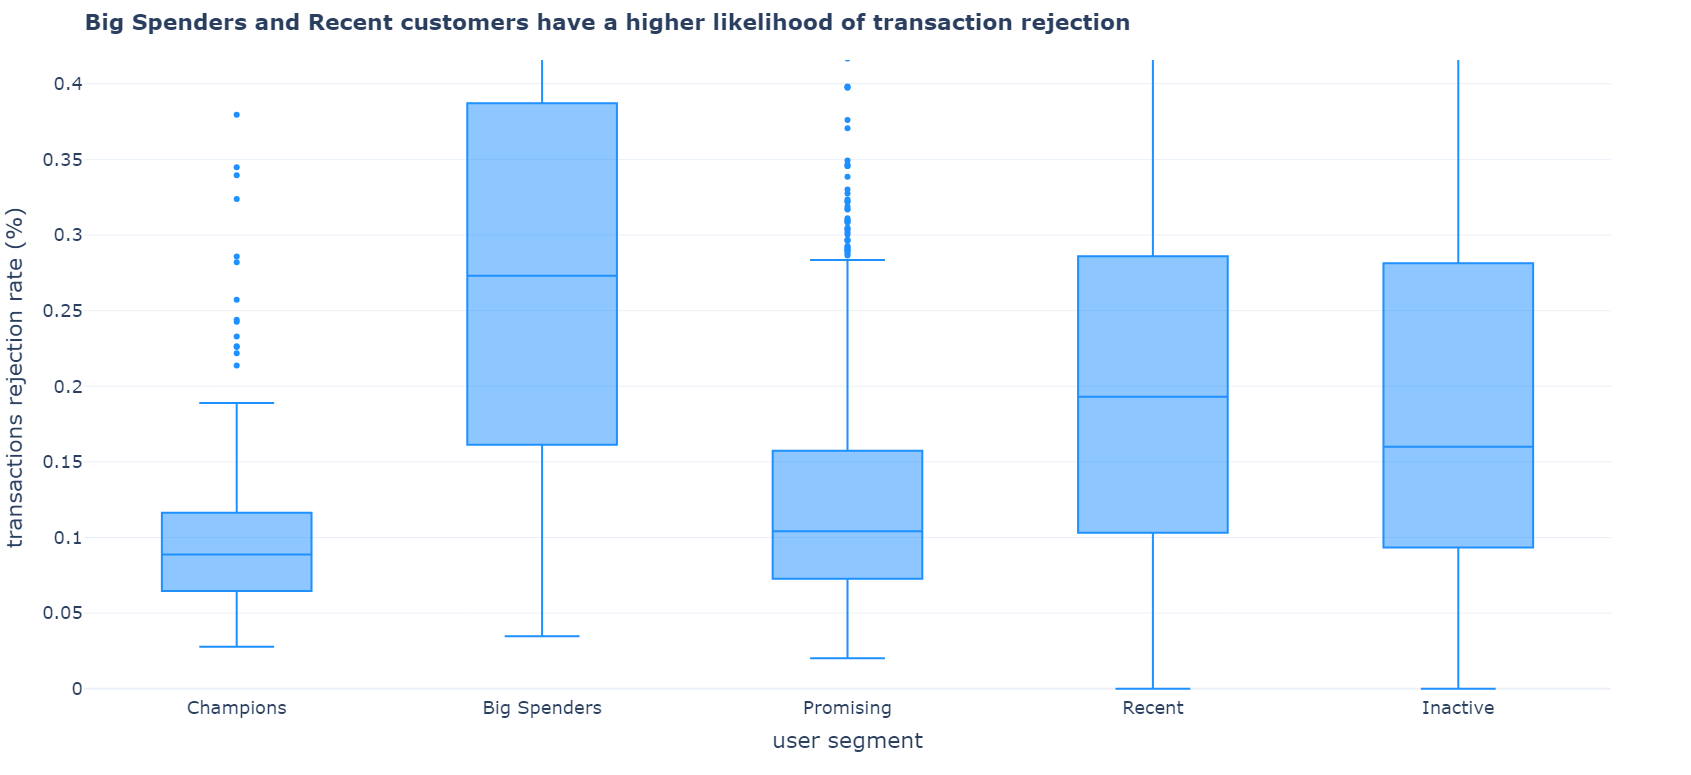

In [65]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["rate_denied"].describe()

rfm_segment_desc   count      mean       std       min       25%       50%  \
0     Big Spenders    84.0  0.299860  0.179658  0.034714  0.162625  0.272992   
1        Champions   234.0  0.103354  0.062709  0.027778  0.064654  0.088713   
2         Inactive  1453.0  0.202186  0.148686  0.000000  0.093567  0.160000   
3        Promising  1079.0  0.129426  0.088826  0.020134  0.072814  0.104101   
4           Recent   193.0  0.212733  0.138137  0.000000  0.103448  0.192982   

        75%       max  
0  0.384588  0.818966  
1  0.116038  0.525194  
2  0.281250  0.857585  
3  0.157407  0.770380  
4  0.283951  0.700000

## Installment Preference

**Notes:** Big Spenders, Recent and Inactive customers consistently opt for installment plans for their purchases

In [66]:
fig = px.box(
    df_users, 
    y="rate_transactions_installment", 
    x="rfm_segment_desc",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Big Spenders, Recent and Inactive customers<br>consistently opt for installment plans for their purchases</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="preference of installment plans (%)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

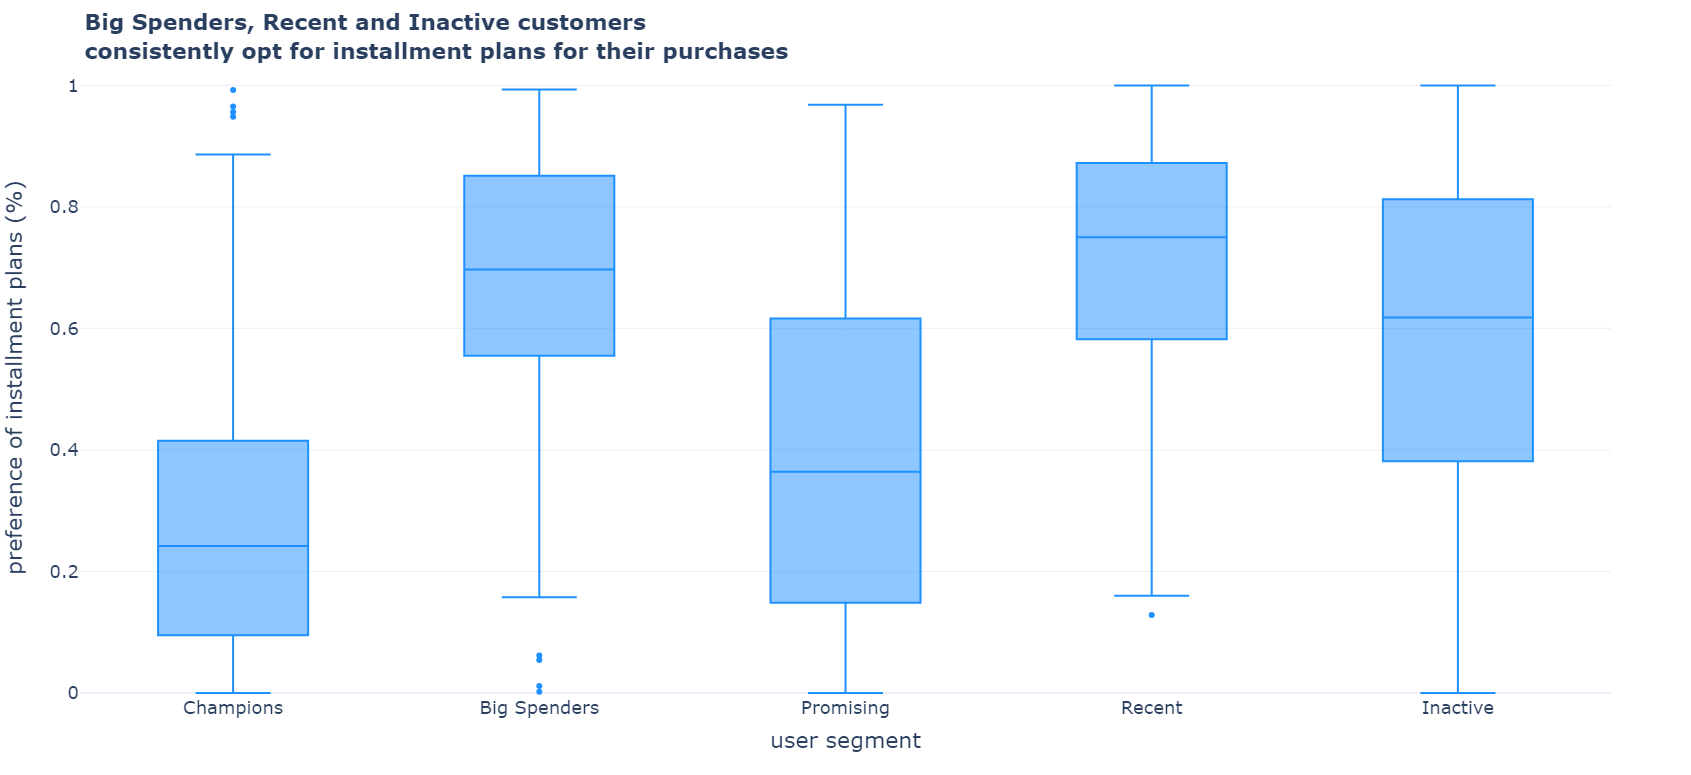

In [67]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["rate_transactions_installment"].describe()

rfm_segment_desc   count      mean       std       min       25%       50%  \
0     Big Spenders    84.0  0.663006  0.243419  0.001867  0.557653  0.697031   
1        Champions   234.0  0.282384  0.227728  0.000000  0.095447  0.241956   
2         Inactive  1453.0  0.586047  0.269473  0.000000  0.381679  0.617886   
3        Promising  1079.0  0.389939  0.268455  0.000000  0.148611  0.363914   
4           Recent   193.0  0.702753  0.208507  0.128205  0.583333  0.750000   

        75%       max  
0  0.849693  0.993421  
1  0.414874  0.992481  
2  0.812500  1.000000  
3  0.615963  0.967972  
4  0.872340  1.000000

# Segment Repayment Behavior

## Loan Repayment Amount

**Notes:** Big Spenders and Recent customers exhibit the highest repayment averages

In [68]:
fig = px.box(
    df_users, 
    y="median_repayment_amount", 
    x="rfm_segment_desc",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Big Spenders and Recent customers exhibit the highest repayment averages</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="repayment amount (R$)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

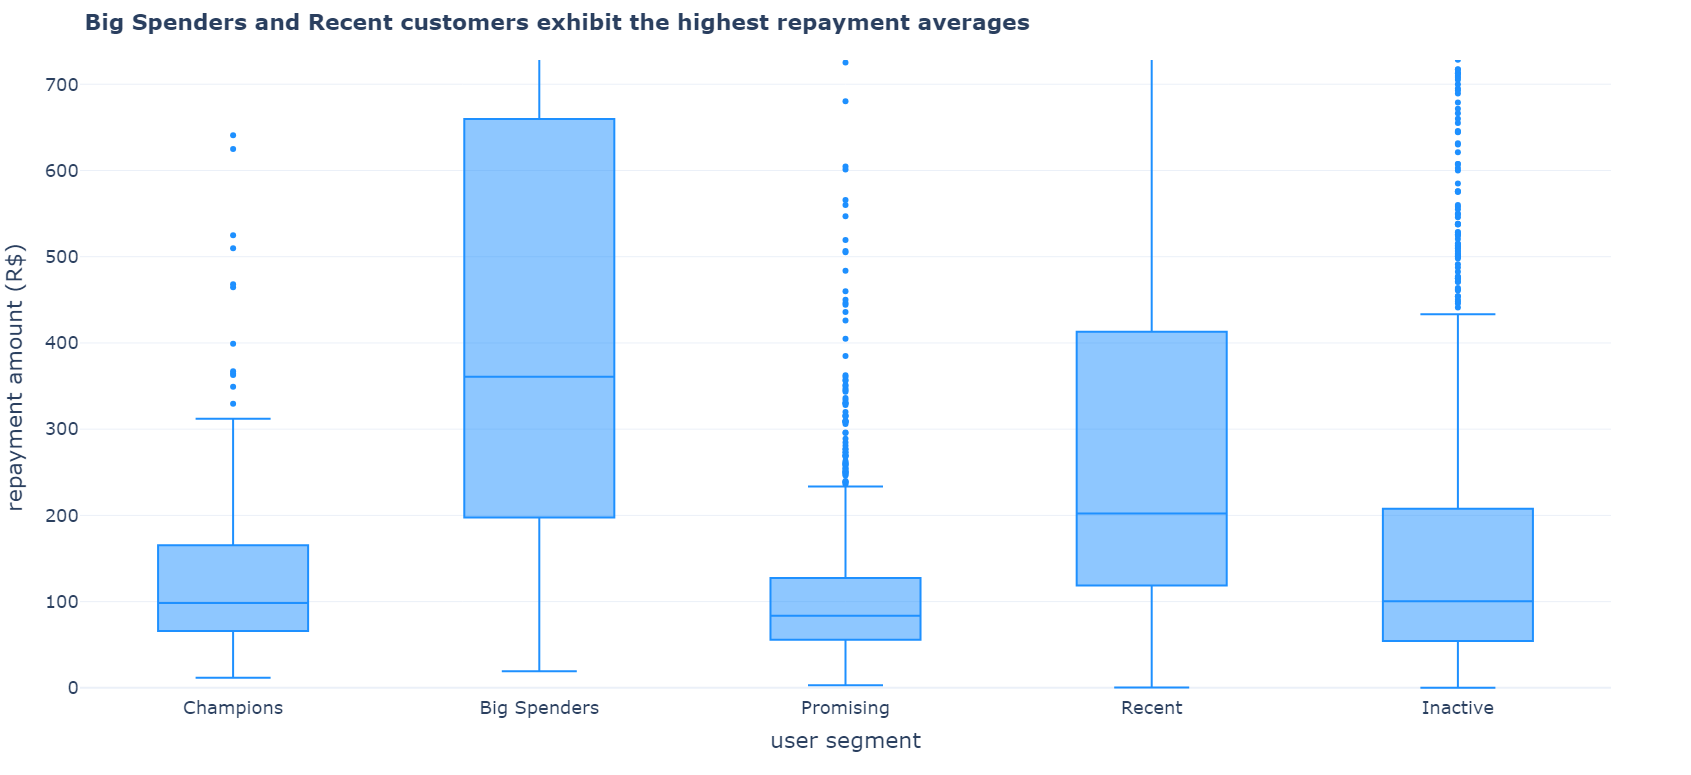

In [69]:
df_users.groupby("rfm_segment_desc", as_index=False)["median_repayment_amount"].describe()

rfm_segment_desc   count        mean         std     min         25%  \
0     Big Spenders    83.0  556.188795  580.374784  19.120  197.625000   
1        Champions   222.0  135.552185  115.870231  11.820   65.383125   
2         Inactive  1210.0  342.592316  814.131437   0.150   46.468125   
3        Promising   973.0  123.846873  186.941290   3.075   52.000000   
4           Recent   172.0  409.158590  575.930410   0.400  107.596875   

         50%         75%      max  
0  360.82000  659.765000  3111.76  
1   98.50000  176.034375   862.50  
2  100.53125  269.670000  6439.62  
3   83.75000  136.060000  3336.58  
4  202.23250  484.359375  3500.00

## Loan Repayment Lag

**Notes:** Customers, regardles of the segment they belong to, have frequent repayments

In [70]:
# Customers, regardles of the segment they belong to, have frequent repayments
df_users.groupby("rfm_segment_desc", as_index=False)["median_days_lag_repayment"].describe()

rfm_segment_desc   count      mean       std  min  25%  50%  75%    max
0     Big Spenders    83.0  2.475904  2.465498  1.0  1.0  2.0  3.0   19.5
1        Champions   222.0  1.045045  0.252136  0.0  1.0  1.0  1.0    3.0
2         Inactive  1210.0  4.978926  9.021283  0.0  1.0  2.0  5.0  104.0
3        Promising   973.0  1.536999  1.720928  0.0  1.0  1.0  2.0   31.0
4           Recent   172.0  5.069767  4.436137  0.0  2.5  4.0  6.0   33.0

## User Default Rate

**Notes:**
- Frequent customers exhibit a higher tendency towards defaulting
- However, Recent and Inactive customers exhibit higher repayment uncertainty (higher default rates)

In [71]:
labels = ["Inactive", "Recent", "Promising", "Big Spenders", "Champions",]

fig = go.Figure([
    go.Bar(y=labels,
           x=[
               df_users[(df_users["rfm_segment_desc"] == label) & (df_users["has_defaulted"] == "has defaulted")]["user_id"].count() \
               / df_users[df_users["rfm_segment_desc"] == label]["user_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_purple"],
           orientation="h",
           name="has defaulted"),
    go.Bar(y=labels,
           x=[
               df_users[(df_users["rfm_segment_desc"] == label) & (df_users["has_defaulted"] == "hasn't defaulted")]["user_id"].count() \
               / df_users[df_users["rfm_segment_desc"] == label]["user_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_blue"],
           orientation="h",
           name="hasn't defaulted")
])

fig.update_layout(
    title="<b>Frequent customers exhibit a higher tendency towards defaulting</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="% of users",
    yaxis_title="user segment",
    barmode="stack",
    bargroupgap=0.1,
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=labels
)
fig.update_traces(
    texttemplate="%{x:.0%}",
    textposition="inside"
)

fig.show()

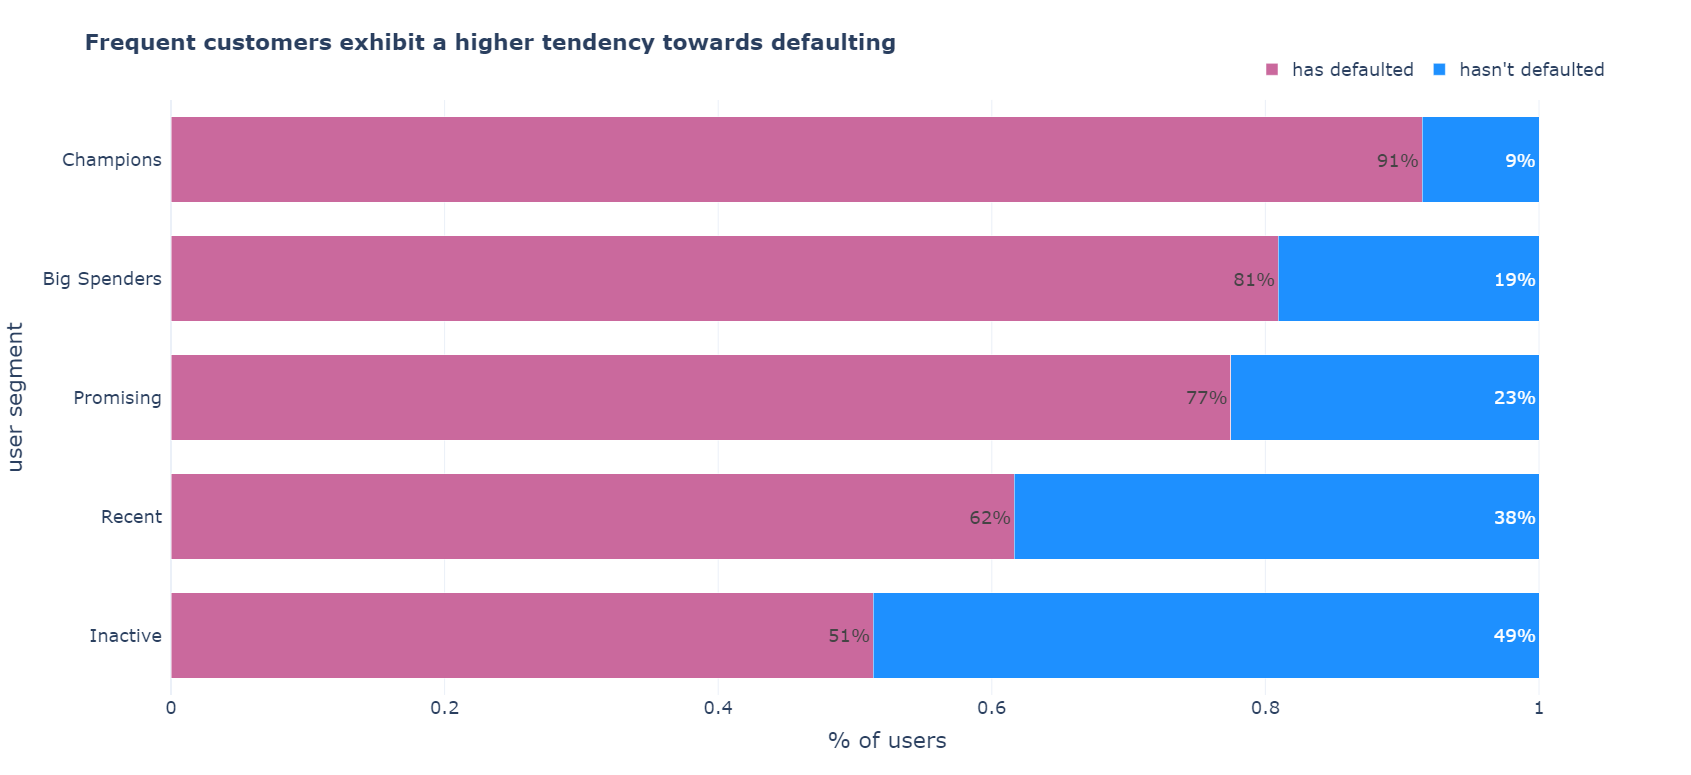

In [72]:
fig = px.box(
    y=df_users[df_users["has_defaulted"] == "has defaulted"]["rate_default"] * 100, 
    x=df_users[df_users["has_defaulted"] == "has defaulted"]["rfm_segment_desc"],
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Recent and Inactive customers exhibit higher repayment uncertainty</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="default rate (%)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

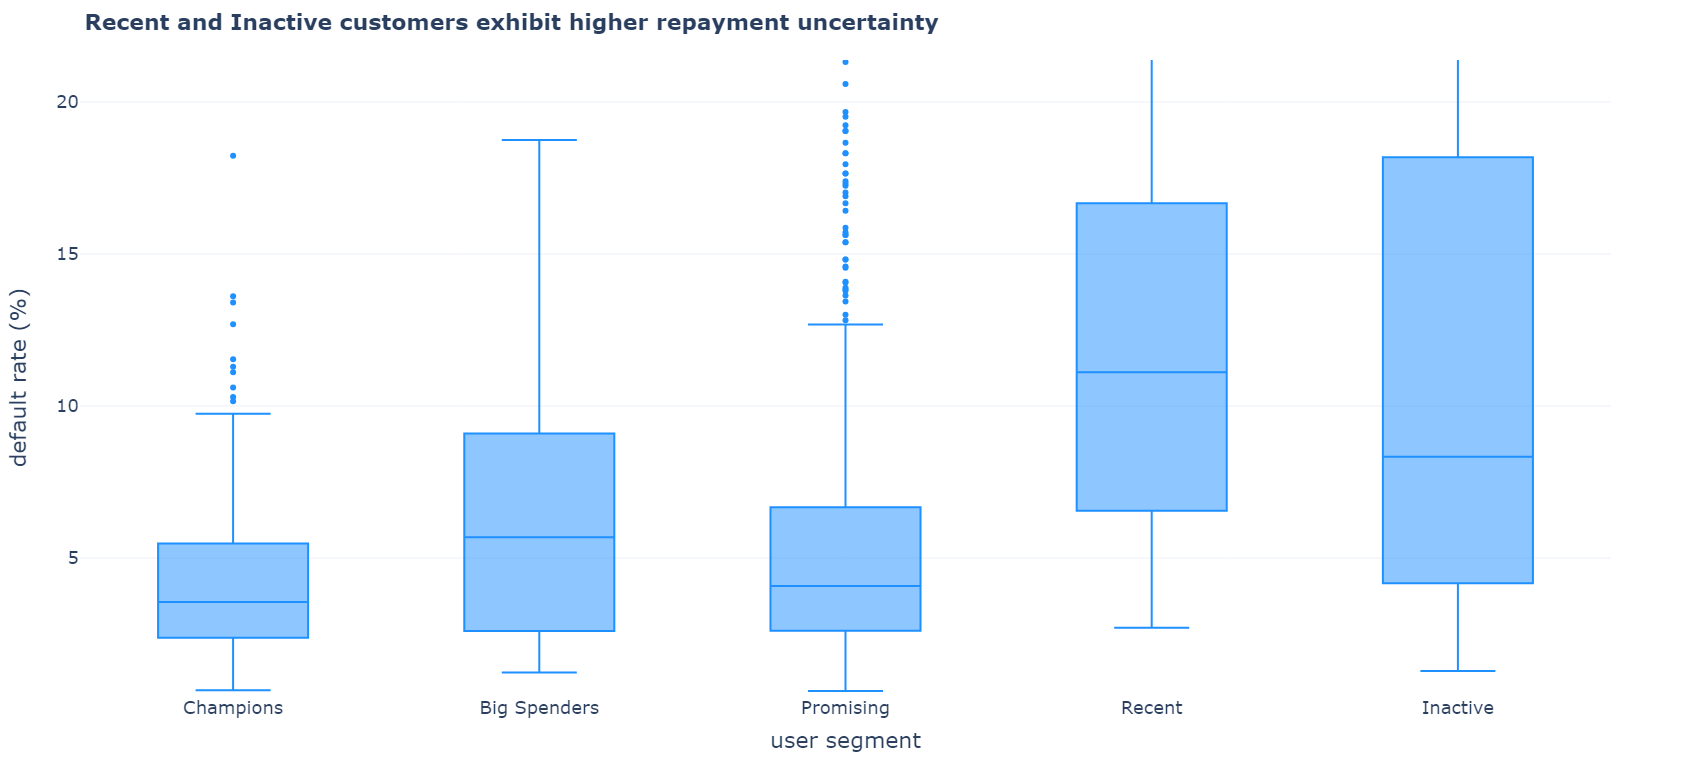

In [73]:
df_users[df_users["has_defaulted"] == "has defaulted"].groupby("rfm_segment_desc", as_index=False)["rate_default"].describe()

rfm_segment_desc  count      mean       std       min       25%       50%  \
0     Big Spenders   68.0  0.067186  0.053423  0.012346  0.026520  0.056848   
1        Champions  214.0  0.043346  0.027680  0.006536  0.023810  0.035504   
2         Inactive  746.0  0.163273  0.214180  0.012821  0.041667  0.083333   
3        Promising  836.0  0.056398  0.055083  0.006250  0.026087  0.040816   
4           Recent  119.0  0.139792  0.104424  0.027027  0.065942  0.111111   

        75%       max  
0  0.090909  0.265306  
1  0.054795  0.182320  
2  0.181818  1.000000  
3  0.066667  0.571429  
4  0.166667  0.571429

In [74]:
df = (
    df_users[df_users["has_defaulted"] == "has defaulted"]
    .groupby('rfm_segment_desc', as_index=False)
    ['rate_default'].median()
    .rename(columns={'rate_default': 'median_rate_default'})
)

fig = px.bar(
    y=df['median_rate_default'] * 100,
    x=df['rfm_segment_desc'],
    color=df['rfm_segment_desc'],
    color_discrete_sequence=[colors["dark_blue"], colors["dark_blue"], colors["dark_purple"], colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title='<b>Recent and Inactive customers exhibit higher repayment uncertainty</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="median default rate (%)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)
fig.update_traces(
    texttemplate='%{y:.0f}%',
    textposition='inside'
)

fig.show()

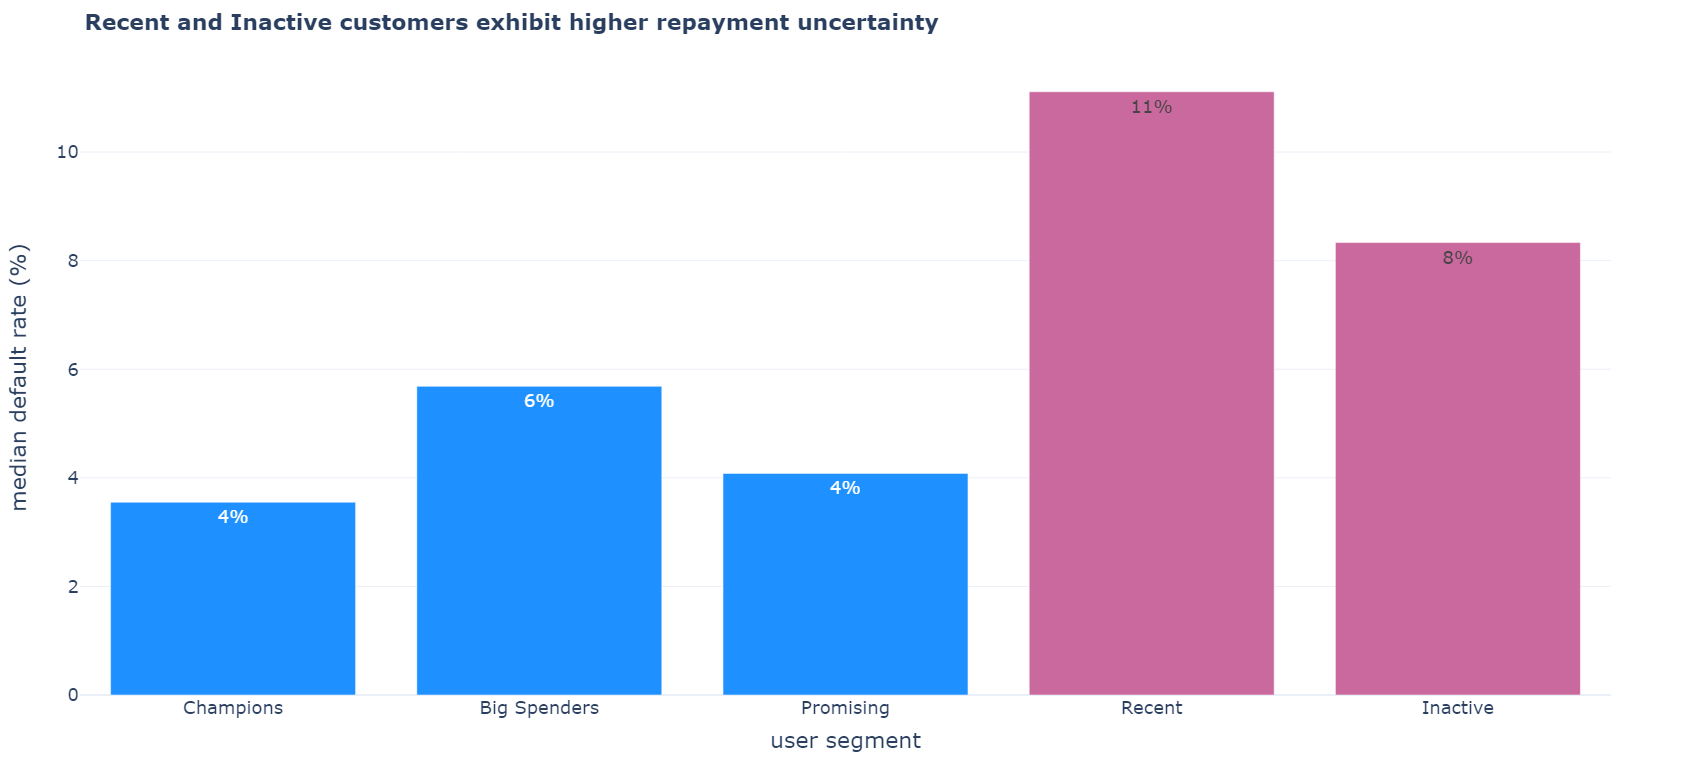

## User Overdue

**Notes:**
- Customers with low to moderate spending habits are likely to fall behind the due date
- Customers who exceed the due date, regardles of the segment they belong to, tend to delay the repayments by up to 2 weeks
- Big Spenders, Recent and Inactive customers have the highest late repayments rates

In [75]:
labels = ["Inactive", "Recent", "Promising", "Big Spenders", "Champions",]

fig = go.Figure([
    go.Bar(y=labels,
           x=[
               df_users[(df_users["rfm_segment_desc"] == label) & (df_users["has_exceeded_due_date"] == "overdue")]["user_id"].count() \
               / df_users[df_users["rfm_segment_desc"] == label]["user_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_purple"],
           orientation="h",
           name="overdue"),
    go.Bar(y=labels,
           x=[
               df_users[(df_users["rfm_segment_desc"] == label) & (df_users["has_exceeded_due_date"] == "on time")]["user_id"].count() \
               / df_users[df_users["rfm_segment_desc"] == label]["user_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_blue"],
           orientation="h",
           name="on time")
])

fig.update_layout(
    title="<b>Customers with low to moderate spending habits are likely to fall behind the due date</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="% of users",
    yaxis_title="user segment",
    barmode="stack",
    bargroupgap=0.1,
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=labels
)
fig.update_traces(
    texttemplate="%{x:.0%}",
    textposition="inside"
)

fig.show()

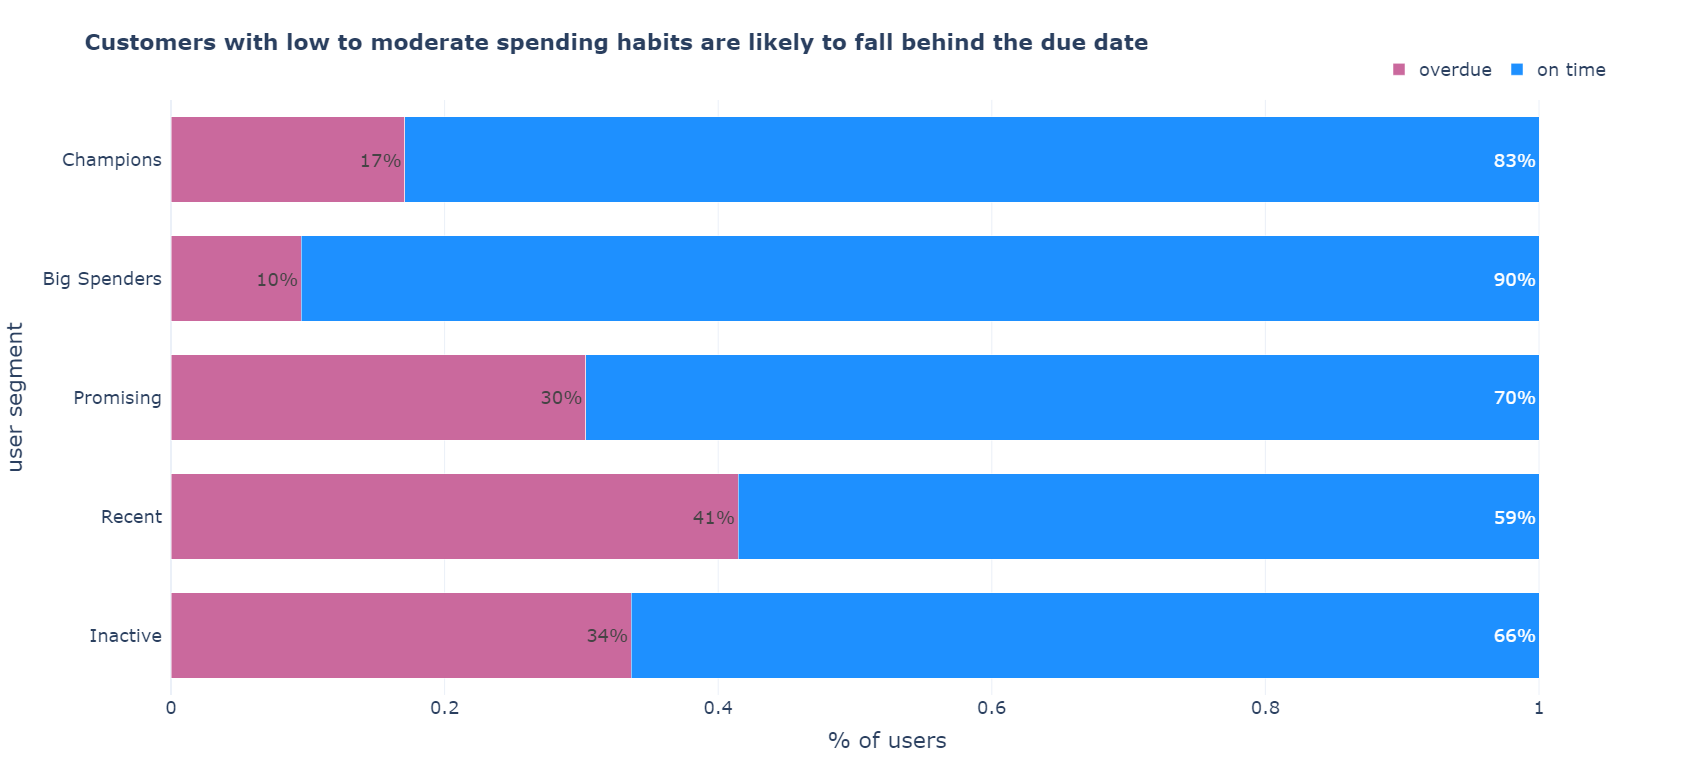

In [76]:
# Customers who exceed the due date, regardles of the segment they belong to, tend to delay the repayments by up to 2 weeks
df_users[df_users["has_exceeded_due_date"] == "overdue"].groupby("rfm_segment_desc", as_index=False)["max_repayment_delay"].describe()

rfm_segment_desc  count       mean        std   min    25%   50%   75%  \
0     Big Spenders    8.0  31.625000  54.313738  10.0  11.75  13.0  14.0   
1        Champions   40.0   9.725000  15.197820   1.0   2.00   8.5  13.0   
2         Inactive  489.0  10.468303  19.630906   1.0   7.00  10.0  13.0   
3        Promising  327.0   8.709480  12.871164   1.0   2.00   9.0  13.5   
4           Recent   80.0   6.975000   4.663282   1.0   2.00   7.0  11.0   

     max  
0  166.0  
1   98.0  
2  391.0  
3  220.0  
4   15.0

In [77]:
fig = px.box(
    y=df_users[df_users["has_exceeded_due_date"] == "overdue"]["rate_late_repayment"] * 100, 
    x=df_users[df_users["has_exceeded_due_date"] == "overdue"]["rfm_segment_desc"],
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Big Spenders, Recent and Inactive customers have the highest late repayments rates</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="late repayments rate (%)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

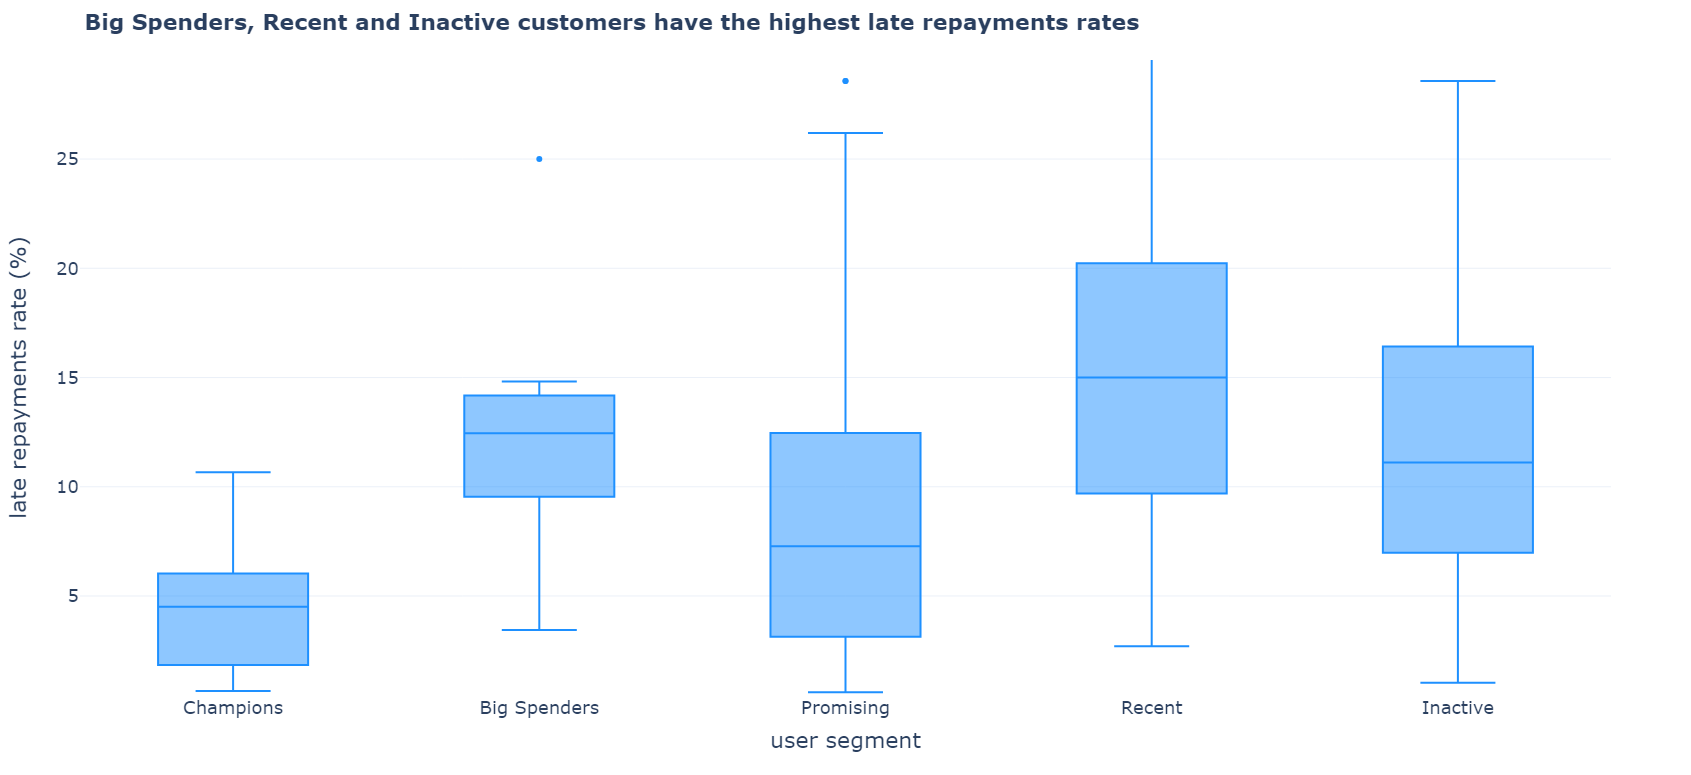

In [78]:
df_users[df_users["has_exceeded_due_date"] == "overdue"].groupby("rfm_segment_desc", as_index=False)["rate_late_repayment"].describe()

rfm_segment_desc  count      mean       std       min       25%       50%  \
0     Big Spenders    8.0  0.125999  0.061276  0.034483  0.097727  0.124516   
1        Champions   40.0  0.044877  0.027666  0.006536  0.019707  0.045115   
2         Inactive  489.0  0.135024  0.124039  0.010309  0.069767  0.111111   
3        Promising  327.0  0.081937  0.060145  0.005988  0.031498  0.072727   
4           Recent   80.0  0.175928  0.137026  0.027027  0.098438  0.150000   

        75%       max  
0  0.138600  0.250000  
1  0.059567  0.106667  
2  0.164179  1.000000  
3  0.124298  0.428571  
4  0.201136  0.714286

In [79]:
df = (
    df_users[df_users["has_exceeded_due_date"] == "overdue"]
    .groupby('rfm_segment_desc', as_index=False)
    ['rate_late_repayment'].median()
    .rename(columns={'rate_late_repayment': 'median_rate_late_repayment'})
)

fig = px.bar(
    y=df['median_rate_late_repayment'] * 100,
    x=df['rfm_segment_desc'],
    color=df['rfm_segment_desc'],
    color_discrete_sequence=[colors["dark_purple"], colors["dark_blue"], colors["dark_purple"], colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title='<b>Big Spenders, Recent and Inactive customers have the highest late repayments rates</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="median<br>late repayments rate (%)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)
fig.update_traces(
    texttemplate='%{y:.0f}%',
    textposition='inside'
)

fig.show()

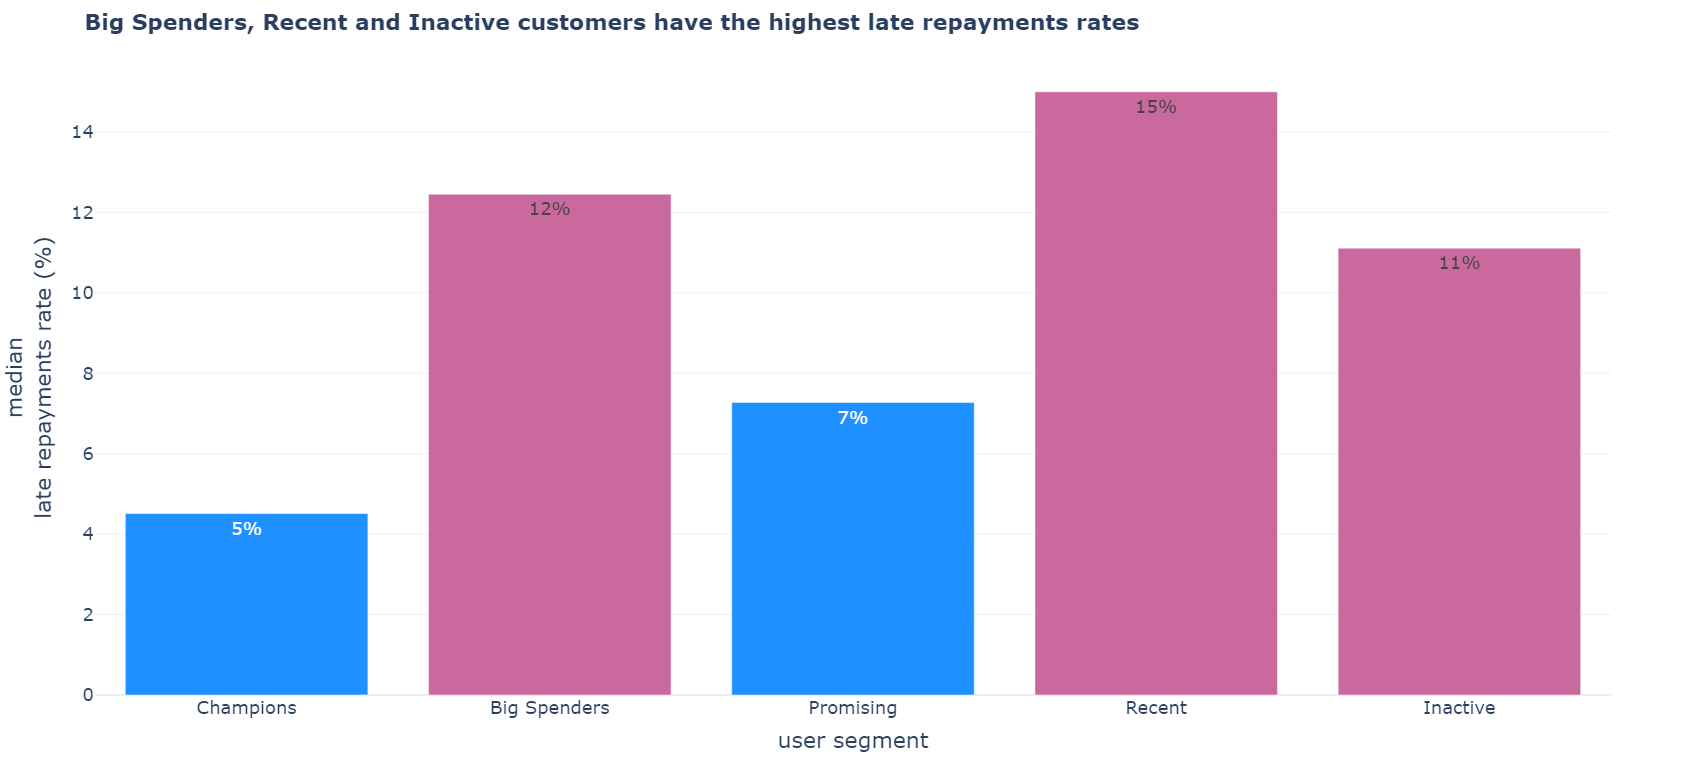

# Segment Loan Suitability

**Note:** 
- Moving forward, we change the terminology of **good/bad loans** to **good/bad candidates**.
- That is, because the goodness of a loan is assessed based on the loan's characteristics with the user's characteristics.

In [80]:
df_loans = df_loans[["id", "user_id", 'status_cleaned', "amount_bin", 'amount_cat', "interest_rate_bin", 'rate_default', 
                     'median_repayment_amount', 'num_repayments', 'ratio_repaid_total', 'max_repayment_delay', 
                     'due_date_exceeded', 'num_late_repayment', 'loan_quality']]
df_loans = df_loans.rename(columns={
    "status_cleaned": "loan_status_cleaned",
    "rate_default": "loan_rate_default",
    "max_repayment_delay": "loan_max_repayment_delay",
})

df_users = df_users[["user_id", 'rate_denied', 'rate_transactions_installment', 
                     'rate_credit_debit', 'credit_debit_preference', 'ratio_online_person', 
                     'online_person_preference', 'rate_default', 'max_repayment_delay',
                     'rate_due_date_exceeded', 'rate_late_repayment', 'rate_manual_auto_repayments',
                     'rate_repaid_loans', 'has_defaulted', 'has_exceeded_due_date', 'rfm_segment_desc']]
df_users = df_users.rename(columns={
    "rate_default": "user_rate_default",
    "max_repayment_delay": "user_max_repayment_delay",
})

df_data = df_loans.merge(df_users, how="left", on="user_id").rename(columns={"id": "loan_id"})

In [81]:
df_data = df_data[~df_data["rfm_segment_desc"].isna()]

## Loan Debt

**Note:** Customers with lower activity levels exhibit a higher risk of incurring loan debt


In [82]:
labels = ["Inactive", "Recent", "Promising", "Big Spenders", "Champions",]

fig = go.Figure([
    go.Bar(y=labels,
           x=[
               df_data[(df_data["rfm_segment_desc"] == label) & (df_data["loan_status_cleaned"] == "repaid")]["loan_id"].count() \
               / df_data[df_data["rfm_segment_desc"] == label]["loan_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_blue"],
           orientation="h",
           name="repaid loans"),
    go.Bar(y=labels,
           x=[
               df_data[(df_data["rfm_segment_desc"] == label) & (df_data["loan_status_cleaned"] == "debt")]["loan_id"].count() \
               / df_data[df_data["rfm_segment_desc"] == label]["loan_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_purple"],
           orientation="h",
           name="loan debt")
])

fig.update_layout(
    title="<b>Customers with lower activity levels exhibit a higher risk of incurring loan debt</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="% of loans",
    yaxis_title="user segment",
    barmode="stack",
    bargroupgap=0.1,
    legend=dict(
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=labels
)
fig.update_traces(
    texttemplate="%{x:.0%}",
    textposition="outside"
)

fig.show()

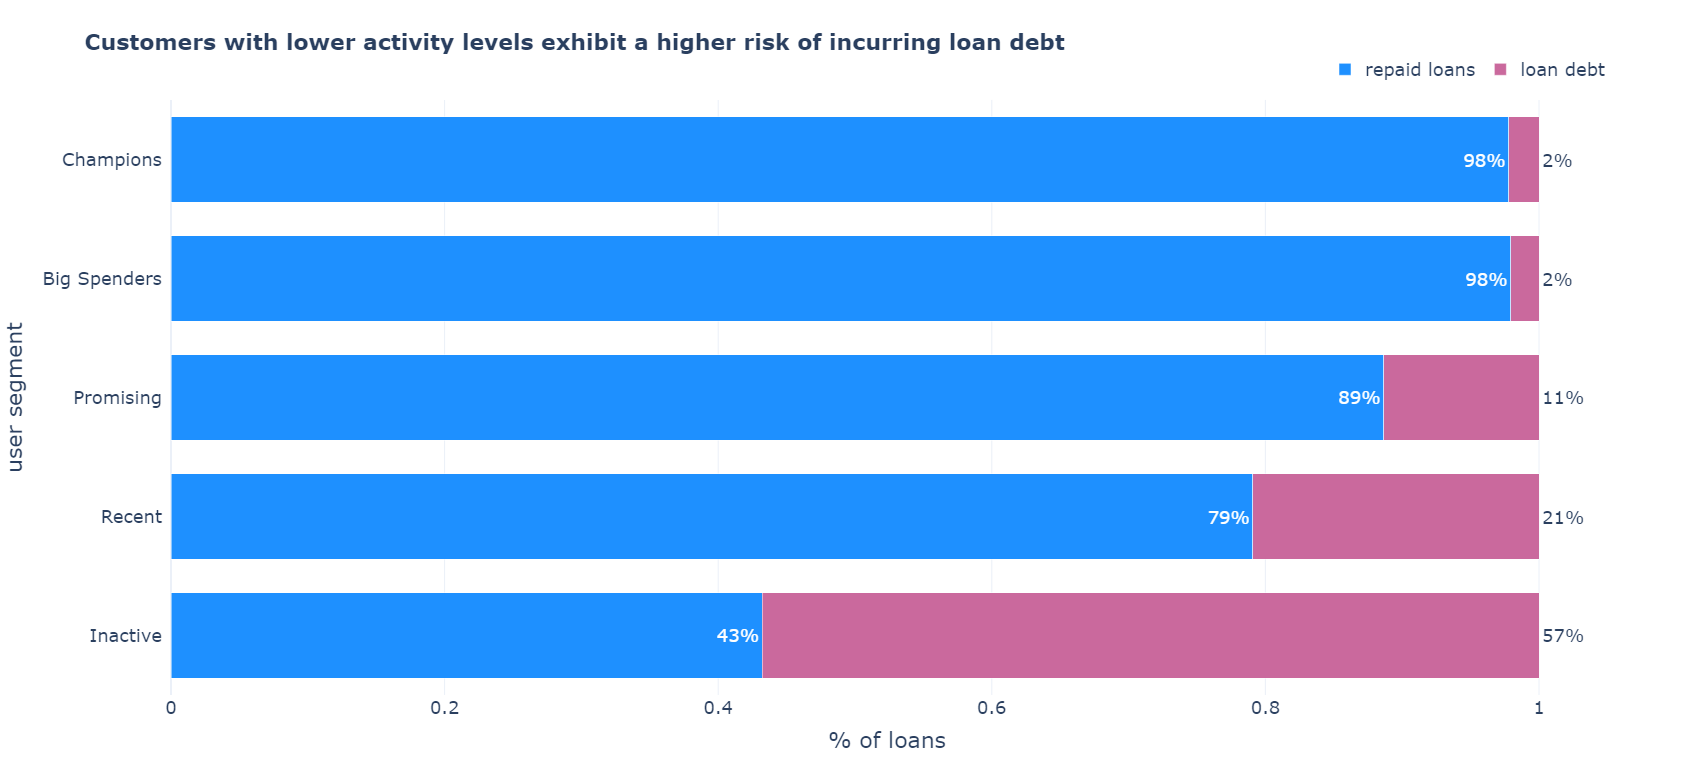

## Candidate Quality

**Note:** Customers with lower activity levels present a high-risk repayment behavior

In [83]:
labels = ["Inactive", "Recent", "Promising", "Big Spenders", "Champions",]

fig = go.Figure([
    go.Bar(y=labels,
           x=[
               df_data[(df_data["rfm_segment_desc"] == label) & (df_data["loan_quality"] == "high")]["loan_id"].count() \
               / df_data[df_data["rfm_segment_desc"] == label]["loan_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_blue"],
           orientation="h",
           name="good candidate"),
    go.Bar(y=labels,
           x=[
               df_data[(df_data["rfm_segment_desc"] == label) & (df_data["loan_quality"] == "low")]["loan_id"].count() \
               / df_data[df_data["rfm_segment_desc"] == label]["loan_id"].count() 
               for label in labels
           ],
           marker_color=colors["dark_purple"],
           orientation="h",
           name="bad candidate")
])

fig.update_layout(
    title="<b>Customers with lower activity levels present a high-risk repayment behavior</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="% of loans",
    yaxis_title="user segment",
    barmode="stack",
    bargroupgap=0.1,
    legend=dict(
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=labels
)
fig.update_traces(
    texttemplate="%{x:.0%}",
    textposition="inside"
)

fig.show()

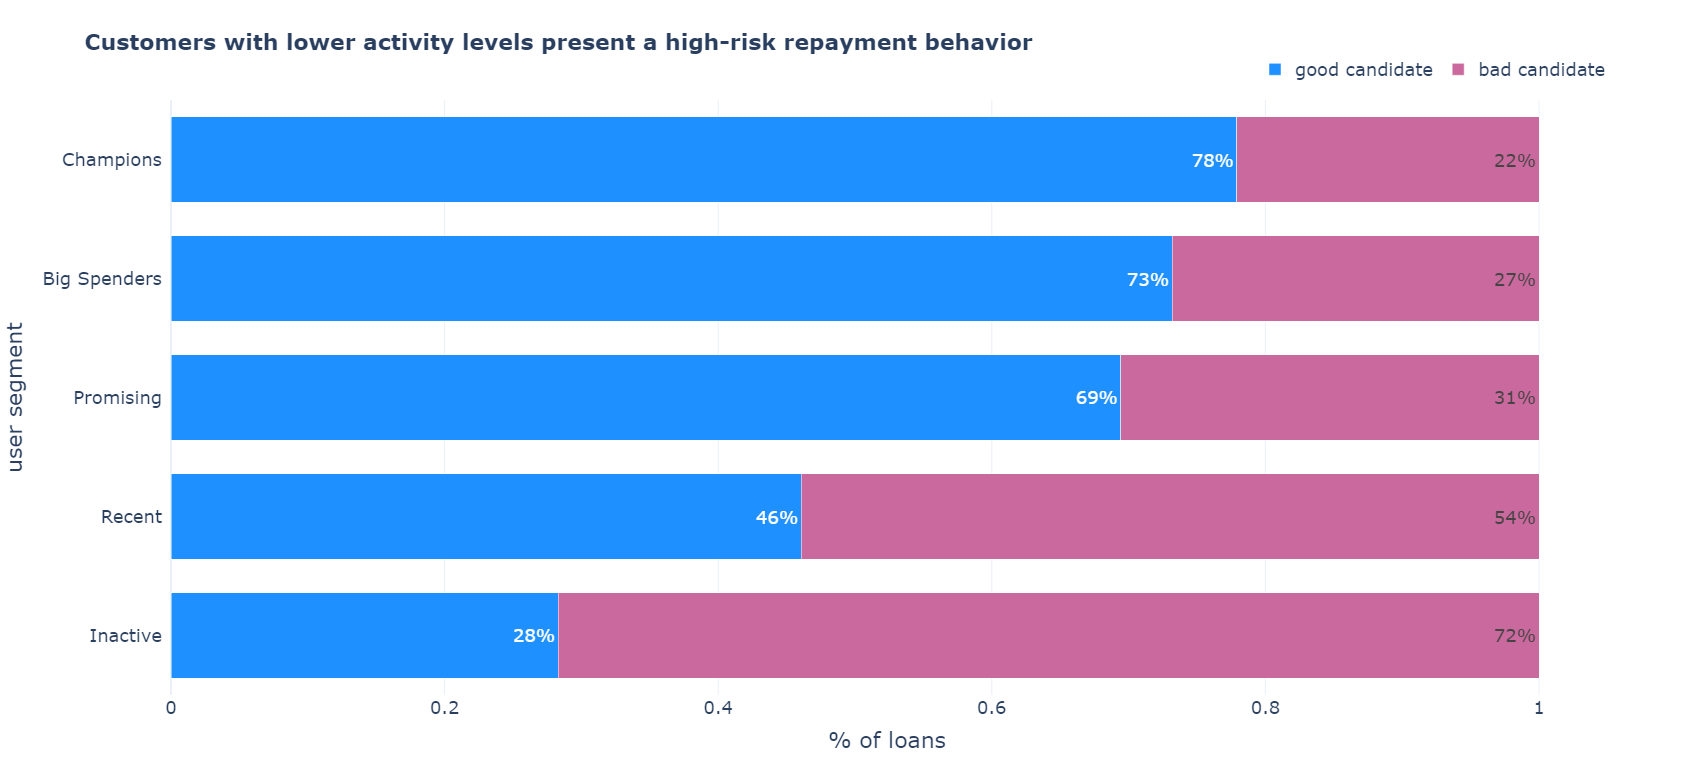

## User Default Rate

**Note:** Risk increases as the default rate increases, with Recent customers exhibiting higher chances of poor repayment behavior

In [84]:
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["user_rate_default"].median() * 100], 
            x=["good<br>candidate"],
            marker_color=colors["dark_blue"],
            name="high"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["user_rate_default"].median() * 100], 
            x=["bad<br>candidate"],
            marker_color=colors["dark_purple"],
            name="low"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>Risk increases as the default rate increases,<br>with Recent customers exhibiting higher chances of poor repayment behavior</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="median default rate (%)",
    barmode="group",
    bargroupgap=0.1,
    showlegend=False,
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0f}%",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

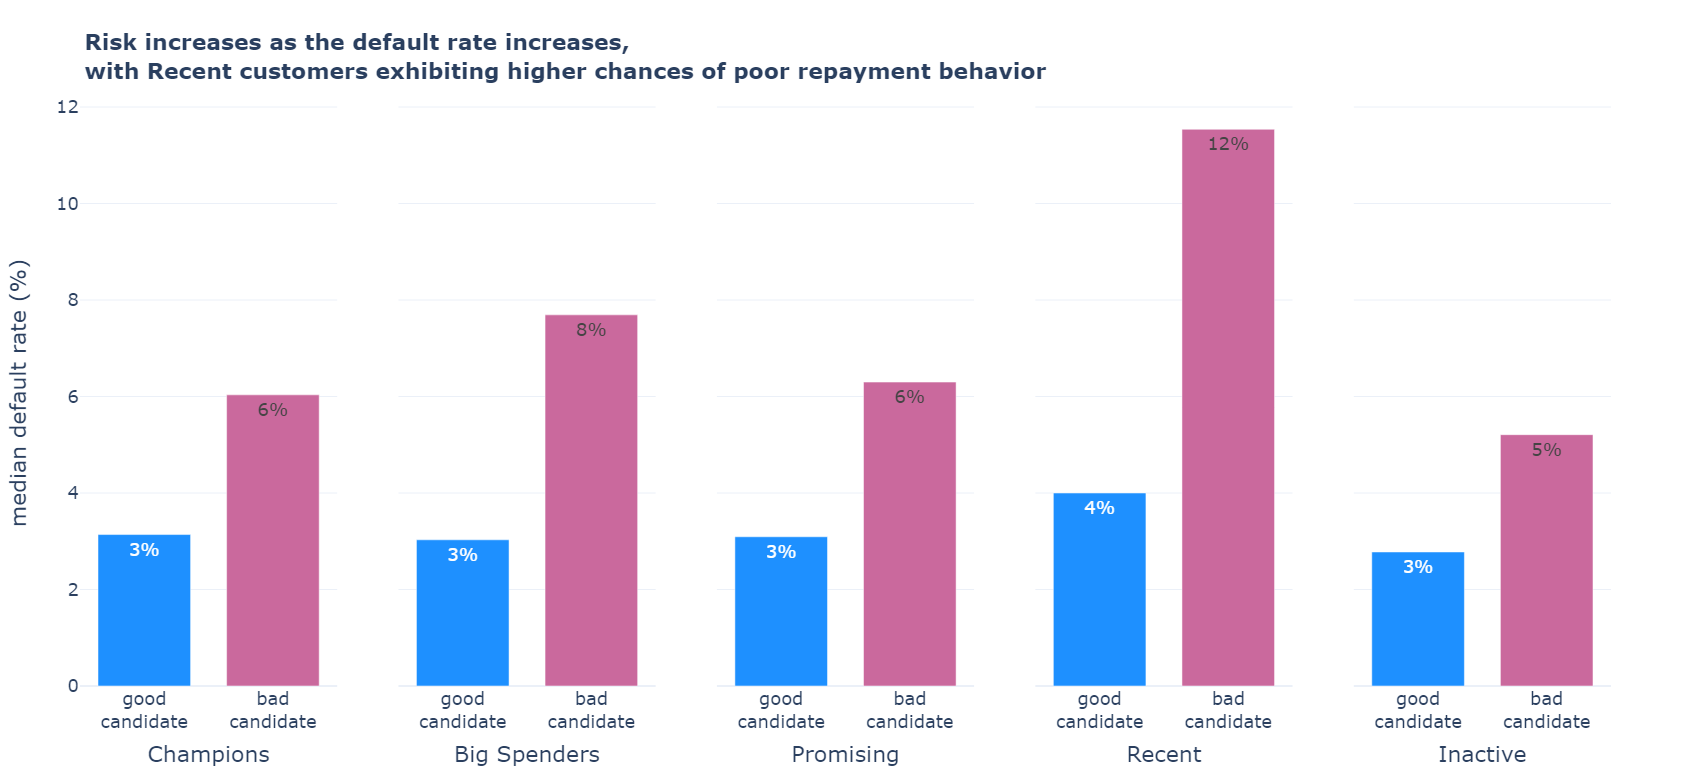

## Late Repayment Rate

**Note:** The repayment behavior of each customer segment isn't highly impacted by the individuals' late repayments rate

In [85]:
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high") & (df_data["has_exceeded_due_date"] == "overdue")]["rate_late_repayment"].median() * 100], 
            x=["good<br>candidate"],
            marker_color=colors["dark_blue"],
            name="high"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low") & (df_data["has_exceeded_due_date"] == "overdue")]["rate_late_repayment"].median() * 100], 
            x=["bad<br>candidate"],
            marker_color=colors["dark_purple"],
            name="low"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>The repayment behavior of each customer segment<br>isn't highly impacted by the individuals' late repayments rate</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="median<br>late repayments rate (%)",
    barmode="group",
    bargroupgap=0.1,
    showlegend=False,
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0f}%",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

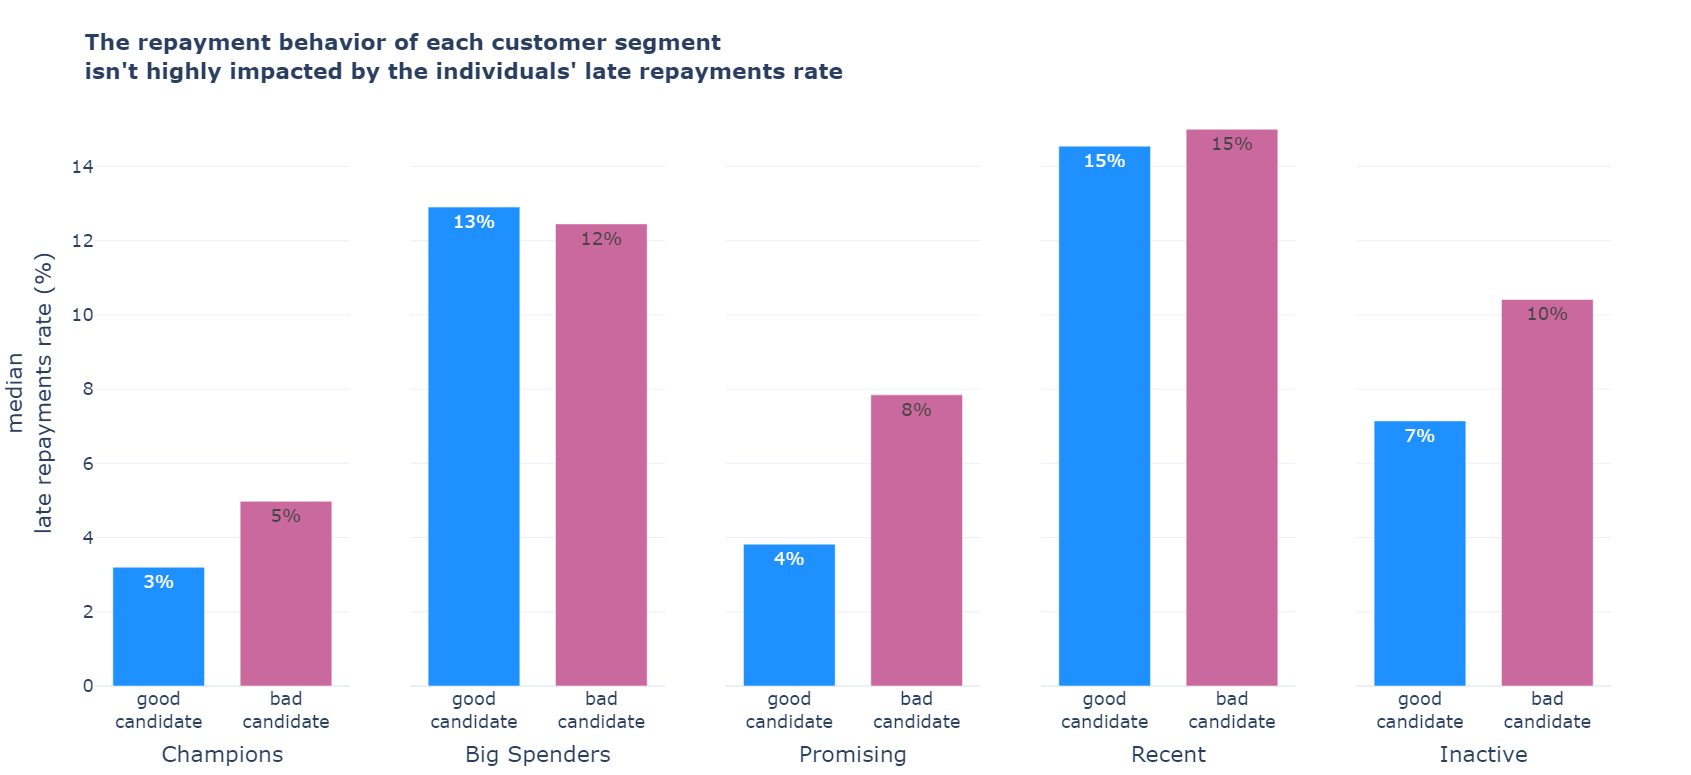

## Manual Repayment Preference

**Note:** Regardless of the customer segment, bad candidates exhibit a slight tendency for repaying loans manually, especially Recent and Inactive customers

In [86]:
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,shared_xaxes=True,
    vertical_spacing=0.001,
)

for i, segment in enumerate(segments):
    fig.add_trace(
        go.Box(
            y=df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["rate_manual_auto_repayments"],
            showlegend=False,
            marker_color=colors["dark_blue"],
            name="good<br>candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Box(
            y=df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["rate_manual_auto_repayments"], 
            showlegend=False,
            marker_color=colors["dark_purple"],
            name="bad<br>candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)
    
fig.add_hline(y=1, 
          line_width=3, 
          line_dash="dash", 
          line_color=colors["dark_gray"],
          annotation_text="<b>baseline</b>",
          annotation_position="top right",
          annotation_font_size=font_size,
          annotation_yshift=0,
          annotation_xshift=50,
          annotation_font_color=colors["dark_gray"])

fig.update_layout(
    title="<b>Regardless of the customer segment,<br>bad candidates exhibit a tendency for repaying loans manually</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="preference<br>manual to auto repayment (%)",
    template=template,
)
fig.update_annotations(font_size=font_size)

fig.show()

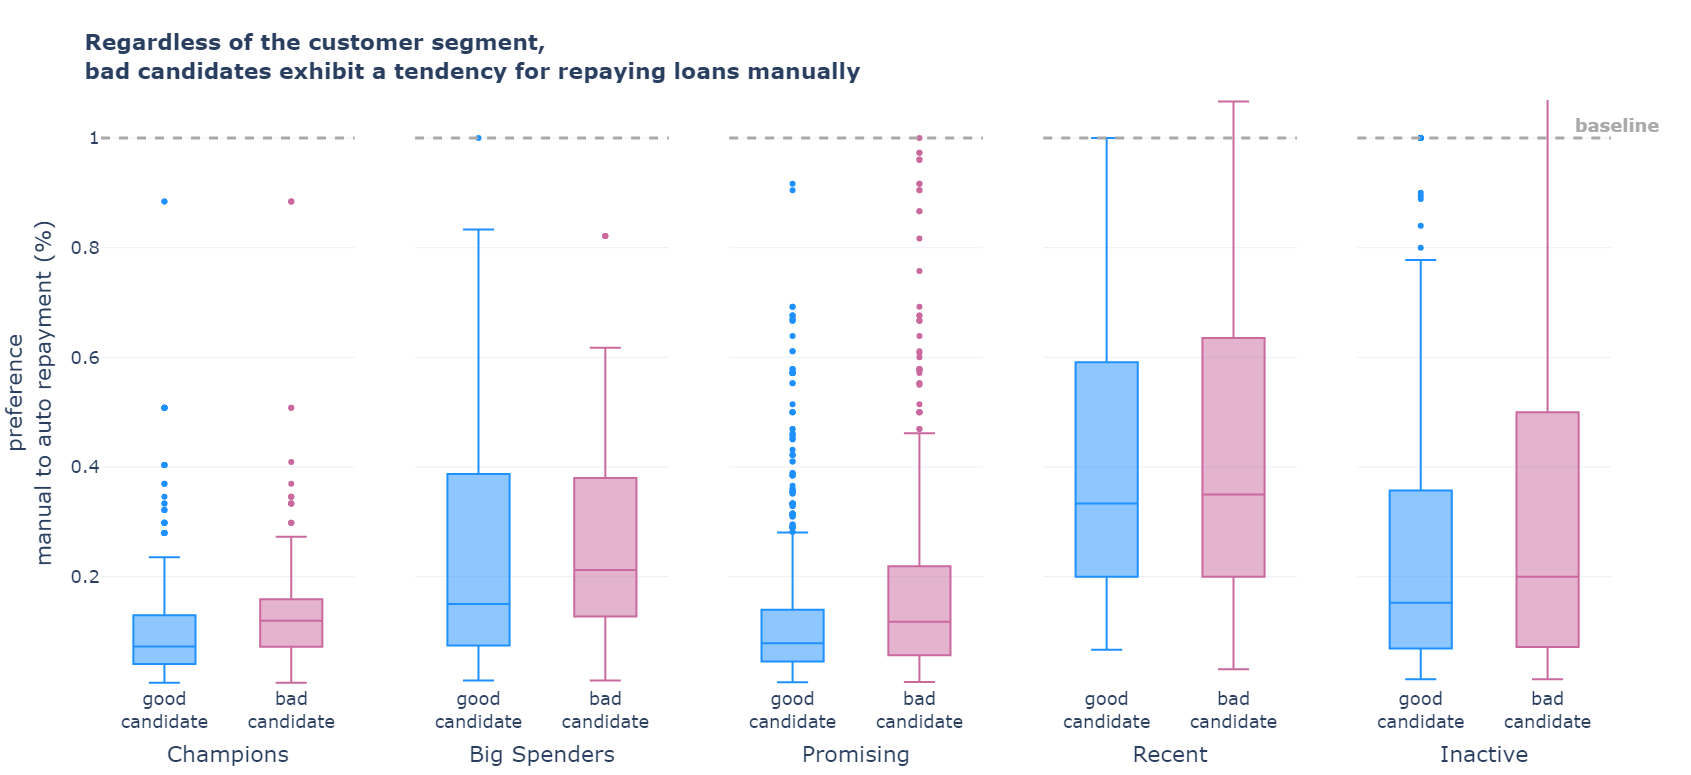

In [87]:
df_data.groupby(["rfm_segment_desc", "loan_quality"], as_index=False)["rate_manual_auto_repayments"].describe()

rfm_segment_desc loan_quality   count      mean       std       min  \
0     Big Spenders         high   281.0  0.230321  0.200180  0.010309   
1     Big Spenders          low   103.0  0.261202  0.187769  0.010309   
2        Champions         high   667.0  0.098288  0.092114  0.006494   
3        Champions          low   189.0  0.141964  0.127376  0.006494   
4         Inactive         high   458.0  0.383771  0.645056  0.012987   
5         Inactive          low  1160.0  0.543846  1.194832  0.012658   
6        Promising         high  1461.0  0.141984  0.282465  0.007194   
7        Promising          low   643.0  0.277907  0.625306  0.007937   
8           Recent         high   141.0  0.644543  1.148545  0.066667   
9           Recent          low   165.0  0.672119  1.082033  0.031250   

        25%       50%       75%        max  
0  0.074561  0.150000  0.387097   1.000000  
1  0.129167  0.212121  0.380000   0.821429  
2  0.040610  0.072464  0.128988   0.884058  
3  0.072222  0.119718  0.158537   0.884058  
4  0.069581  0.152174  0.357143   6.000000  
5  0.071429  0.200000  0.500000  16.000000  
6  0.045161  0.078431  0.139706   3.500000  
7  0.056661  0.117647  0.219024   7.000000  
8  0.200000  0.333333  0.588235   6.200000  
9  0.200000  0.350000  0.631579   6.200000

In [88]:
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["rate_manual_auto_repayments"].median()], 
            x=["good<br>candidate"],
            marker_color=colors["dark_blue"],
            name="high"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["rate_manual_auto_repayments"].median()], 
            x=["bad<br>candidate"],
            marker_color=colors["dark_purple"],
            name="low"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)
    
fig.add_hline(y=1, 
          line_width=3, 
          line_dash="dash", 
          line_color=colors["dark_gray"],
          annotation_text="<b>baseline</b>",
          annotation_position="top right",
          annotation_font_size=font_size,
          annotation_yshift=0,
          annotation_xshift=50,
          annotation_font_color=colors["dark_gray"])

fig.update_layout(
    title="<b>Regardless of the customer segment,<br>bad candidates exhibit a tendency for repaying loans manually</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="median preference<br>manual to auto repayment (%)",
    barmode="group",
    bargroupgap=0.1,
    showlegend=False,
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.2f}%",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

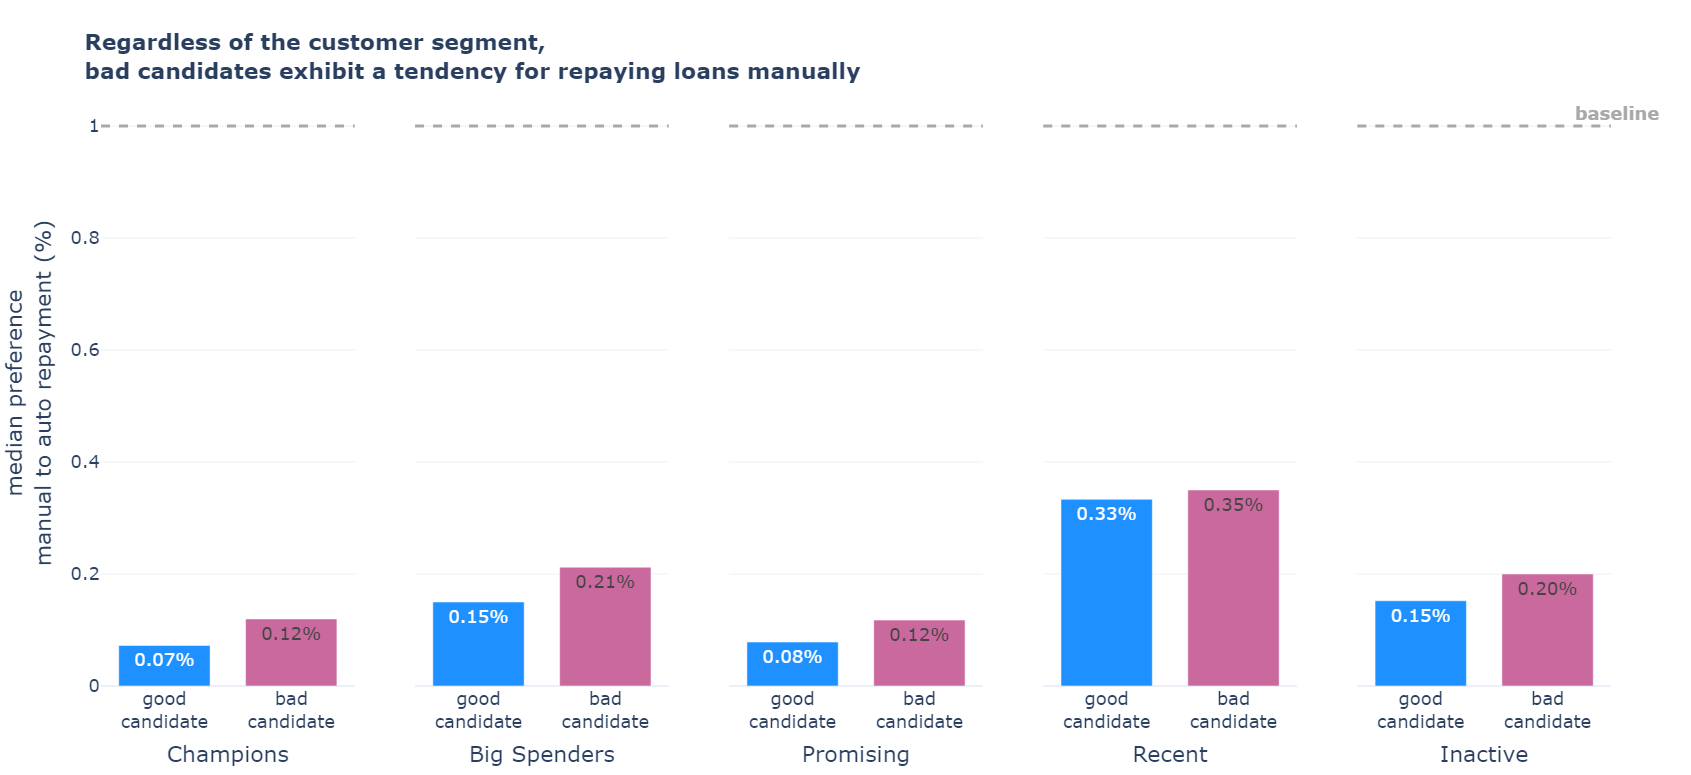

## Loan Principal Amount

**Note:** 
- Risk increases as the loan amount increases, with Recent and Inactive customers exhibiting a greater poor repayment behavior
- Big Spenders have a limited amount of small and medium sized loans, thus the % isn't statistically significant there

In [89]:
labels = ["small", "medium", "large"]
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[
               df_data[(df_data["amount_cat"] == label) & (df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["loan_id"].count() \
               / df_data[(df_data["amount_cat"] == label) & (df_data["rfm_segment_desc"] == segment)]["loan_id"].count() 
               for label in labels
            ], 
            x=labels,
            showlegend=True if i == 0 else False,
            marker_color=colors["dark_blue"],
            name="good candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[
               df_data[(df_data["amount_cat"] == label) & (df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["loan_id"].count() \
               / df_data[(df_data["amount_cat"] == label) & (df_data["rfm_segment_desc"] == segment)]["loan_id"].count() 
               for label in labels
            ], 
            x=labels,
            showlegend=True if i == 0 else False,
            marker_color=colors["dark_purple"],
            name="bad candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>Risk increases as the loan amount increases,<br>with Recent and Inactive customers exhibiting a greater poor repayment behavior</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="% of loans",
    barmode="stack",
    legend=dict(
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0%}",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

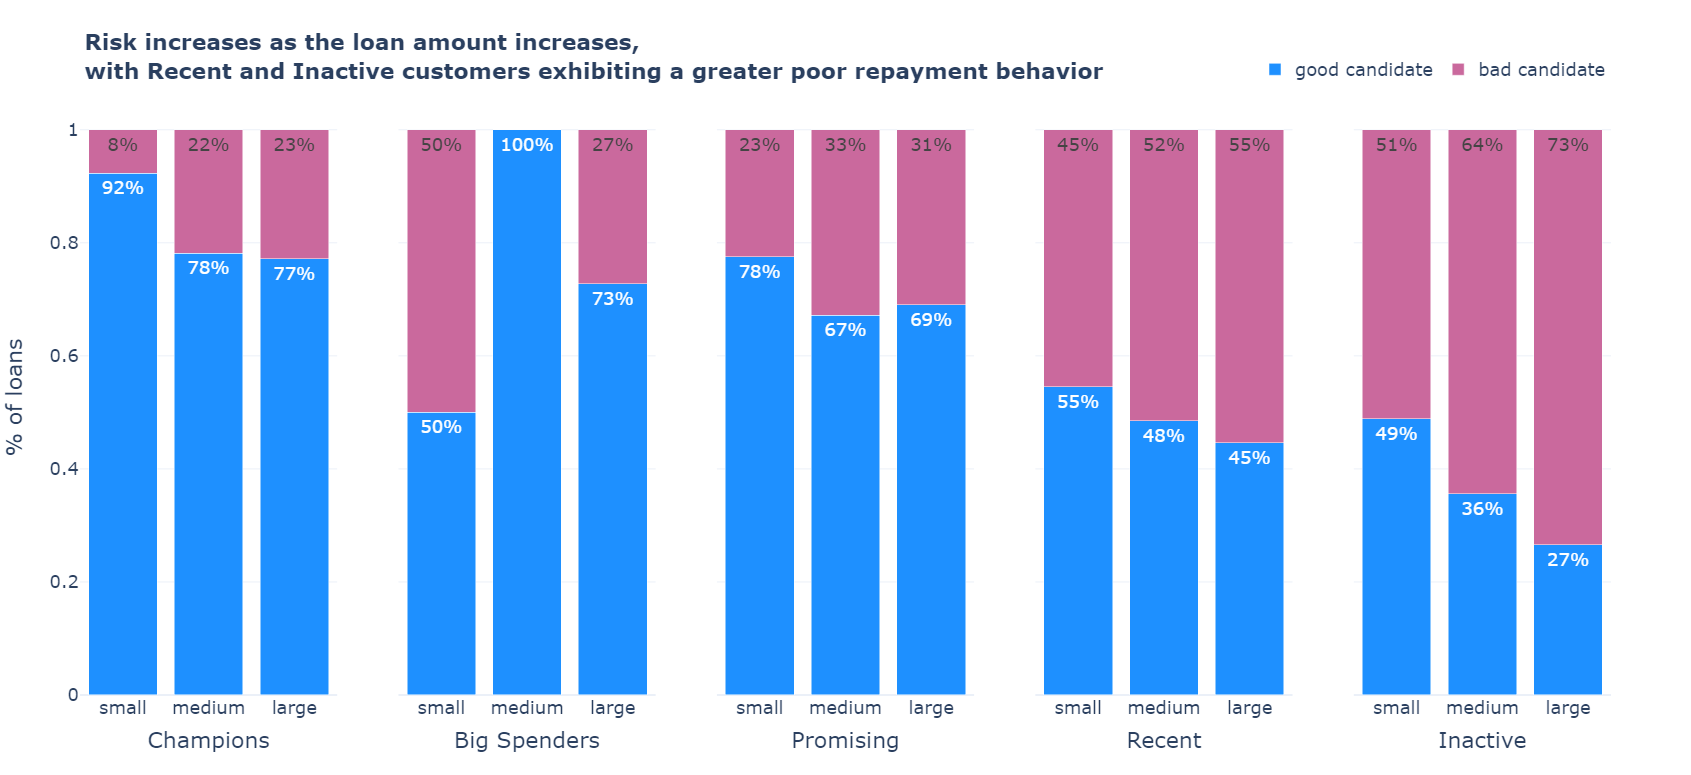

## Loan Interest Rate

**Note:** 
- Risk increases as the loan interest rate increases, with Recent and Inactive customers exhibiting poor repayment behavior
- Inactive customers have a limited amount of loans with large interest rates, thus the % isn't statistically significant there

In [90]:
labels = ["small", "medium", "large"]
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[
               df_data[(df_data["interest_rate_bin"] == label) & (df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["loan_id"].count() \
               / df_data[(df_data["interest_rate_bin"] == label) & (df_data["rfm_segment_desc"] == segment)]["loan_id"].count() 
               for label in labels
            ], 
            x=labels,
            showlegend=True if i == 0 else False,
            marker_color=colors["dark_blue"],
            name="good candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[
               df_data[(df_data["interest_rate_bin"] == label) & (df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["loan_id"].count() \
               / df_data[(df_data["interest_rate_bin"] == label) & (df_data["rfm_segment_desc"] == segment)]["loan_id"].count() 
               for label in labels
            ], 
            x=labels,
            showlegend=True if i == 0 else False,
            marker_color=colors["dark_purple"],
            name="bad candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>Risk increases as the loan interest rate increases,<br>with Recent and Inactive customers exhibiting poor repayment behavior</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="% of loans",
    barmode="stack",
    legend=dict(
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0%}",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

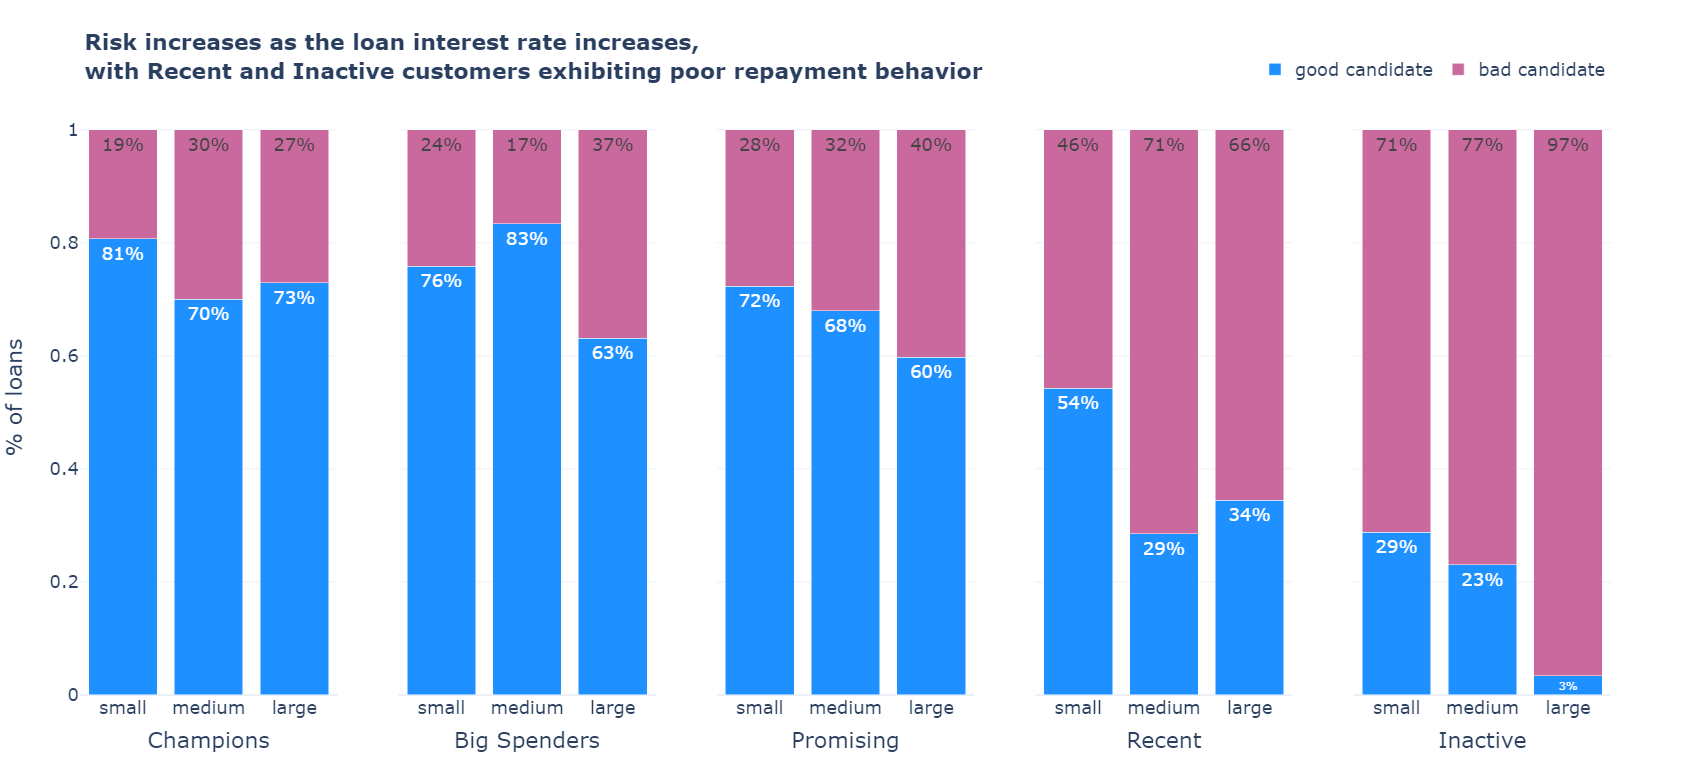

## Denied Transaction

**Note:** The repayment behavior of each customer segment isn't highly impacted by the individuals' transaction rejection rate

In [91]:
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["rate_denied"].median() * 100], 
            x=["good<br>candidate"],
            marker_color=colors["dark_blue"],
            name="high"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["rate_denied"].median() * 100], 
            x=["bad<br>candidate"],
            marker_color=colors["dark_purple"],
            name="low"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>The repayment behavior of each customer segment<br>isn't highly impacted by the individuals' transaction rejection rate</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="median<br>transaction rejection rate (%)",
    barmode="group",
    bargroupgap=0.1,
    showlegend=False,
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0f}%",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

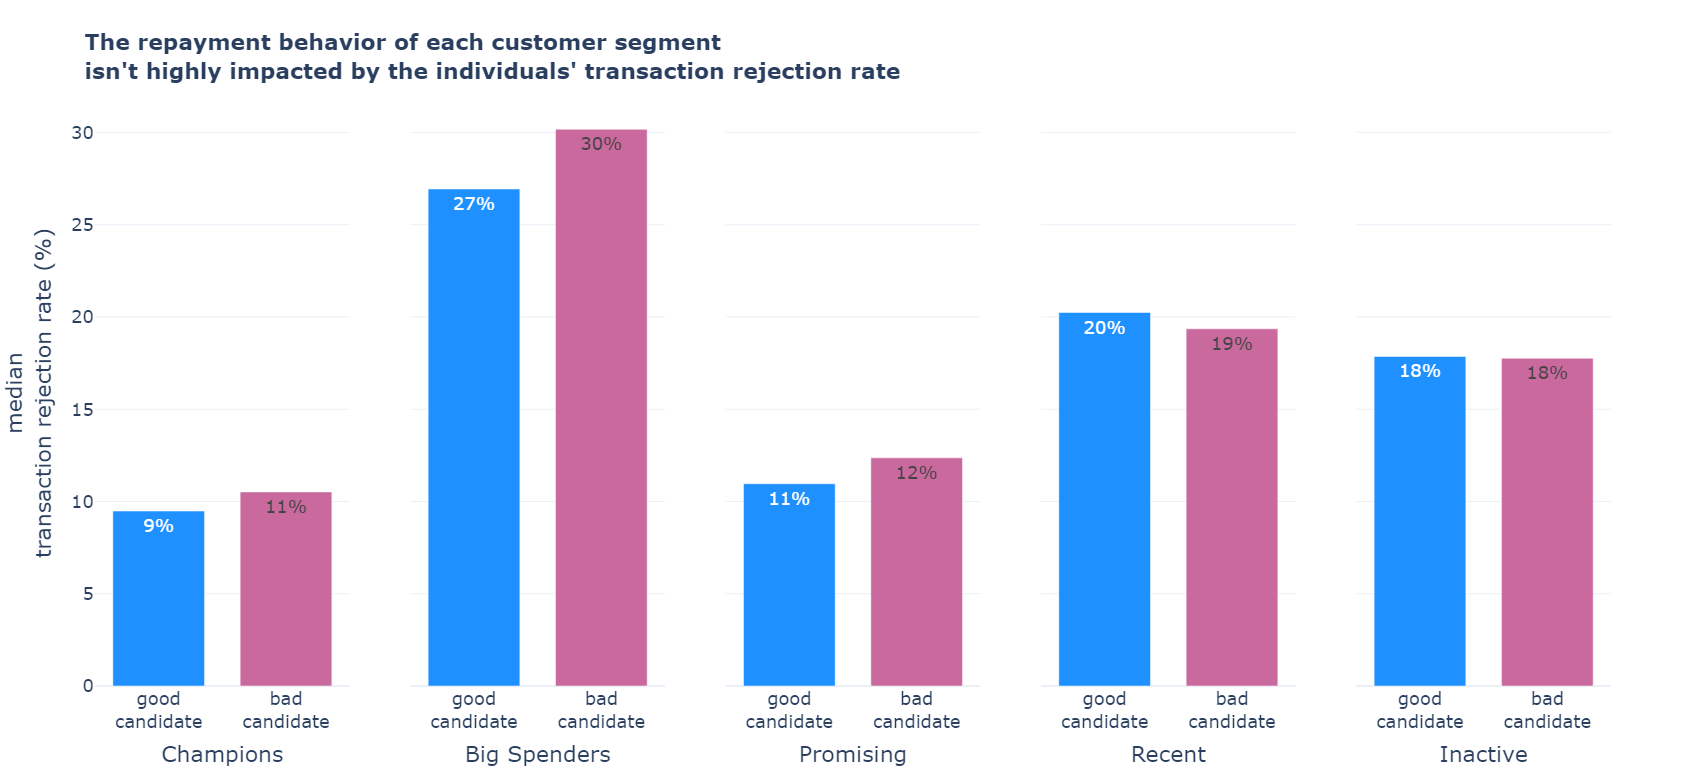

## Denied Transaction

**Note:** The repayment behavior of each customer segment isn't highly impacted by the preference of installment plans for financing purchases

In [92]:
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["rate_transactions_installment"].median() * 100], 
            x=["good<br>candidate"],
            marker_color=colors["dark_blue"],
            name="high"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[df_data[(df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["rate_transactions_installment"].median() * 100], 
            x=["bad<br>candidate"],
            marker_color=colors["dark_purple"],
            name="low"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>The repayment behavior of each customer segment isn't highly impacted<br>by the preference of installment plans for financing purchases</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="median preference<br>installment plans (%)",
    barmode="group",
    bargroupgap=0.1,
    showlegend=False,
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0f}%",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

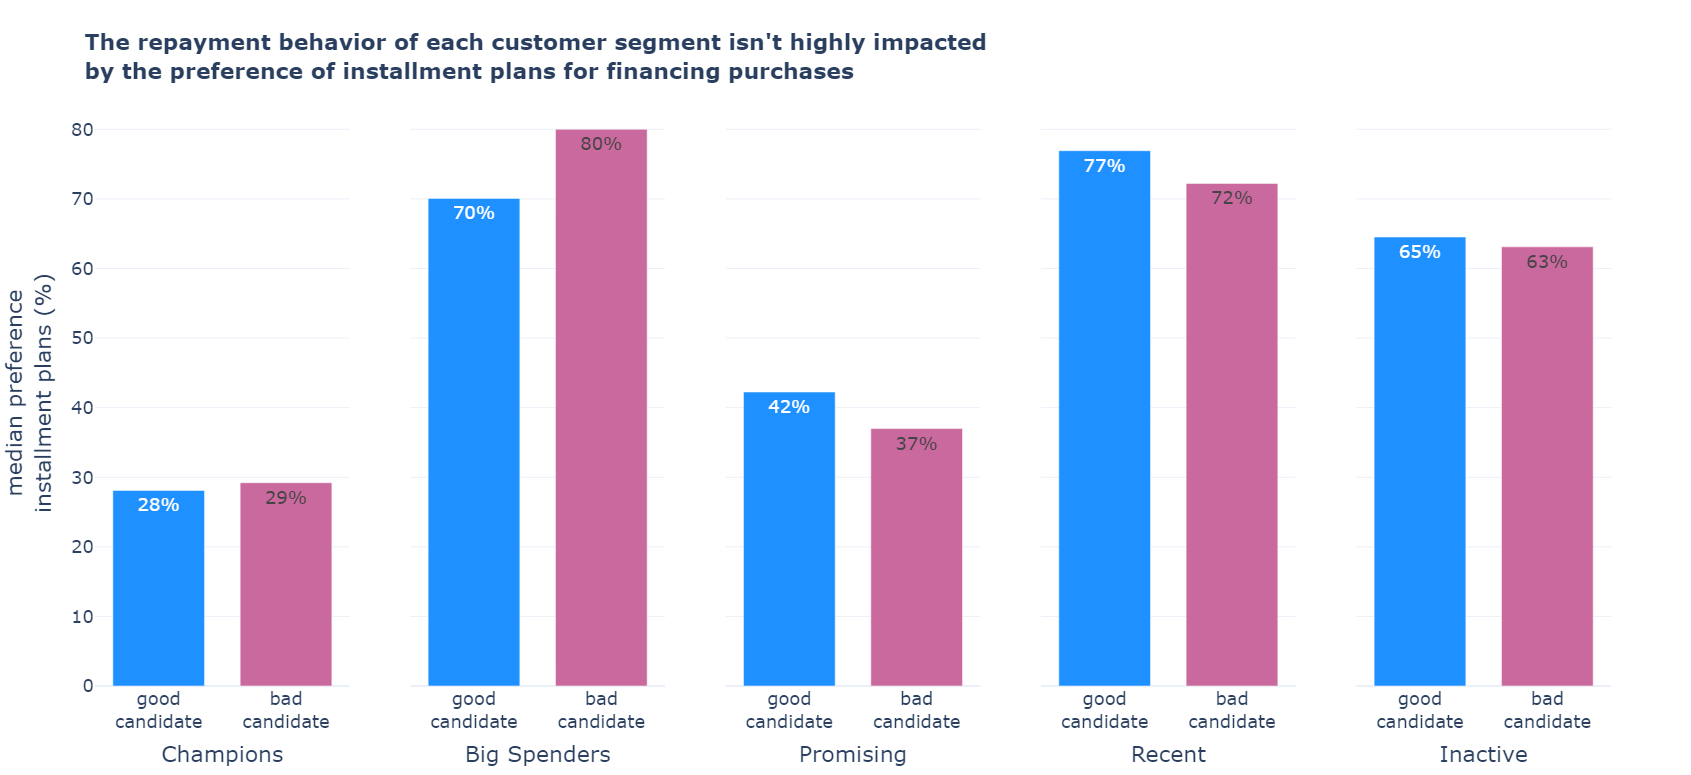

## Purchases Mode

**Note:** Regardless of the customer segment, customers with online spending habits exhibit a higher risk

In [93]:
labels = ["in-person", "online"]
segments = ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]

fig = make_subplots(
    rows=1, 
    cols=df_data["rfm_segment_desc"].unique().shape[0],
    shared_yaxes=True,
    vertical_spacing=0.001,
)
for i, segment in enumerate(segments):
    fig.add_trace(
        go.Bar(
            y=[
               df_data[(df_data["online_person_preference"] == label) & (df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "high")]["user_id"].count() \
               / df_data[(df_data["online_person_preference"] == label) & (df_data["rfm_segment_desc"] == segment)]["user_id"].count() 
               for label in labels
            ], 
            x=labels,
            showlegend=True if i == 0 else False,
            marker_color=colors["dark_blue"],
            name="good candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.add_trace(
        go.Bar(
            y=[
               df_data[(df_data["online_person_preference"] == label) & (df_data["rfm_segment_desc"] == segment) & (df_data["loan_quality"] == "low")]["user_id"].count() \
               / df_data[(df_data["online_person_preference"] == label) & (df_data["rfm_segment_desc"] == segment)]["user_id"].count() 
               for label in labels
            ], 
            x=labels,
            showlegend=True if i == 0 else False,
            marker_color=colors["dark_purple"],
            name="bad candidate"
        ),
        row=1, 
        col=i+1
    )
    fig.update_xaxes(title_text=f"{segment}", row=1, col=i+1)

fig.update_layout(
    title="<b>Regardless of the customer segment,<br>customers with online spending habits exhibit a higher risk</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    yaxis_title="% of users",
    barmode="stack",
    legend=dict(
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template=template,
)
fig.update_traces(
    texttemplate="%{y:.0%}",
    textposition="inside"
)
fig.update_annotations(font_size=font_size)

fig.show()

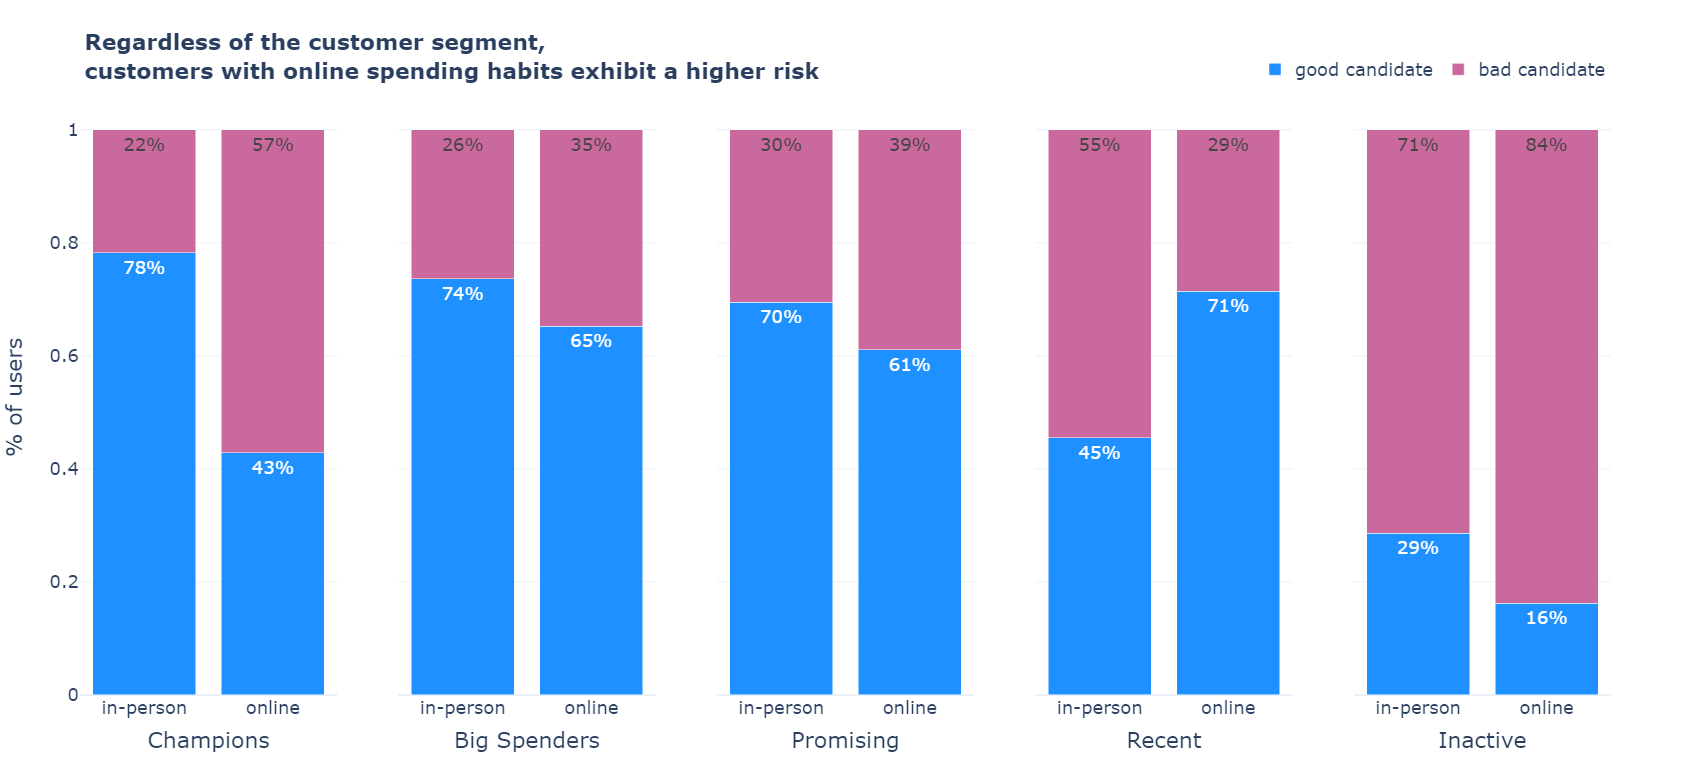